In [1]:
import os

# Set the proxy environment variables
os.environ['HTTP_PROXY'] = 'http://192.168.1.231:8090'
os.environ['HTTPS_PROXY'] = 'http://192.168.1.231:8090'

In [1]:
# Load model directly
from PIL import Image
import torch
import ast
from transformers import AutoConfig, AutoModel, AutoTokenizer
from accelerate import init_empty_weights, infer_auto_device_map, load_checkpoint_in_model, dispatch_model
from transformers.utils import cached_file
from stream_pipeline import stream_pipeline

torch.manual_seed(100)

model = AutoModel.from_pretrained(
    'openbmb/MiniCPM-V-2_6',
    trust_remote_code=True,
    attn_implementation='flash_attention_2',
    torch_dtype=torch.bfloat16,
    device_map='balanced_low_0'
) # sdpa or flash_attention_2, no eager
model = model.eval().cuda()
tokenizer = AutoTokenizer.from_pretrained('openbmb/MiniCPM-V-2_6', trust_remote_code=True)

/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [2]:
import re

def get_best_image(track_imgs):
    requirement = "你将接收到多张图像的描述信息，编号从1开始递增。请依据以下图像质量评判标准，挑选出质量最好的一张图像，并以 python dict“{'index': 具体索引的整数值类型}” 的格式输出结果，输出结果必须是python dict信息。\
        评判标准：\
        1. 清晰度：图像应清晰无模糊、噪点少。\
        2. 色彩准确性：色彩还原真实，无明显偏色。 \
        3. 构图合理性：主体突出，画面布局协调，无元素挤压或缺失。\
        4. 完整性：图像无明显遮挡、裁剪不当等问题。\
        简短的判断每张图像的质量然后给出答案。\
        答案输出示例: \
        1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。\
        2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。\
        3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。 \
        4. 第四张图：清晰度一般，手部遮挡部分包装。\
        因此第3张图像是最好的图，最终答案为'{'index': 3}'。\
        "
    check_info = "检查一下上述信息是否包含了python ditc格式的输出，如果没有请重新输出。"

    msgs = [
        {
            'role': 'user',
            'content': track_imgs
        },
        {
            'role': 'user',
            'content': check_info
        }
    ]
    answer = model.chat(
        image=None,
        msgs=msgs,
        system_prompt=requirement,
        tokenizer=tokenizer
    )
    print(answer)
    # index = int(re.search(r"'index': (\d+)", answer).group(1))
    match = re.search(r'"index": (\d+)', answer) or re.search(r"'index': (\d+)", answer)
    index = int(match.group(1))
    
    return track_imgs[index - 1]

def get_product_description(std_img, track_imgs):
    requiremrnt = '你是一个在超市工作的chatbot，你现在需要提取图像中商品的信息，信息需要按照以下python dict的格式输出，如果信息模糊不清 \
        则输出"未知"，不要包含特殊字符: \
        {    \
            "item1": {\
                "Text": 第一张图像中商品中提取出的文字信息,  \
                "Color": 第一张图像中商品的颜色,  \
                "Shape": 第一张图像中商品的形状,  \
                "Material": 第一张图像中商品的材质,  \
                "Category": 第一张图像中商品的类别,  \
            } \
            "item2": {\
                "Text": 第二张图像中商品中提取出的文字信息,  \
                "Color": 第二张图像中商品的颜色,  \
                "Shape": 第二张图像中商品的形状,  \
                "Material": 第二张图像中商品的材质,  \
                "Category": 第二张图像中商品的类别,  \
            } \
            "is_Same": 首先判断"Color"是否一致，如果不一致则返回False，如果一致则判断是否以上两个dict的["Text", "Shape", "Material", "Category"]key中至少有3个相同则输出True，\
                        否则输出False。  \
        } \
        '
    best_img = get_best_image(track_imgs)
    msgs = [
        {
            'role': 'user',
            'content': [std_img, best_img]
        }
    ]
    answer = model.chat(
        image=None,
        msgs=msgs,
        system_prompt=requiremrnt,
        tokenizer=tokenizer
    )
    contrast_pair = ast.literal_eval(answer.strip('```python\n'))
    
    return contrast_pair

def item_analysis(stream_dict):
    track_imgs = stream_pipeline(stream_dict)
    if len(track_imgs) == 0:
        return {}
    std_img = None
    if stream_dict['goodsPic'] is not None:
        std_img = Image.open(stream_dict['goodsPic']).convert("RGB")
    description_dict = get_product_description(std_img, track_imgs)

    return description_dict

In [26]:
answer = """根据提供的图像描述，以下是对每张图像质量的评判：

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：图像较为模糊，且有明显的倾斜和抖动。
6. 第六张图：图像较为模糊，且有明显的倾斜和抖动。
7. 第七张图：图像较为模糊，且有明显的倾斜和抖动。
8. 第八张图：图像较为模糊，且有明显的倾斜和抖动。
9. 第九张图：图像较为模糊，且有明显的倾斜和抖动。

综合以上评判，第三张图的质量最好。因此答案为：

{
    'index': 3
}
"""
match = re.search(r'"index": (\d+)', answer) or re.search(r"'index': (\d+)", answer)
index = int(match.group(1))
index

3

In [68]:
stream_dict = {
    'video': '/home/ieemoo0337/projects/datasets/constrast_pair/4036300002518/4036300002518_20241020-155553_back_returnGood_5478c9a49bfc_225_13799009402.mp4',
    'goodsPic': '/home/ieemoo0337/projects/datasets/constrast_pair/4513574012752/4513574012752.jpg'
}

result = item_analysis(stream_dict)
result

YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

load model resnet18 


video 1/1 (8/70) /home/ieemoo0337/projects/datasets/constrast_pair/4036300002518/4036300002518_20241020-155553_back_returnGood_5478c9a49bfc_225_13799009402.mp4: 640x512 5.2ms
video 1/1 (9/70) /home/ieemoo0337/projects/datasets/constrast_pair/4036300002518/4036300002518_20241020-155553_back_returnGood_5478c9a49bfc_225_13799009402.mp4: 640x512 5.2ms
video 1/1 (10/70) /home/ieemoo0337/projects/datasets/constrast_pair/4036300002518/4036300002518_20241020-155553_back_returnGood_5478c9a49bfc_225_13799009402.mp4: 640x512 5.1ms
video 1/1 (11/70) /home/ieemoo0337/projects/datasets/constrast_pair/4036300002518/4036300002518_20241020-155553_back_returnGood_5478c9a49bfc_225_13799009402.mp4: 640x512 5.2ms
video 1/1 (12/70) /home/ieemoo0337/projects/datasets/constrast_pair/4036300002518/4036300002518_20241020-155553_back_returnGood_5478c9a49bfc_225_13799009402.mp4: 640x512 5.2ms
video 1/1 (13/70) /home/ieemoo0337/projects/datasets/constrast_pair/4036300002518/4036300002518_20241020-155553_back_retur

根据提供的图像质量和评判标准，第3张图片的质量最好。尽管存在一些模糊和颜色失真，但它的构图和主体相对清晰，并且没有明显的遮挡或裁剪问题。

所以答案是：{'index': 3}


{'item1': {'Text': '馬油 non-stick shampoo',
  'Color': '橙色',
  'Shape': '瓶状',
  'Material': '塑料',
  'Category': '洗发水'},
 'item2': {'Text': '未知',
  'Color': '金色',
  'Shape': '盒状',
  'Material': '未知',
  'Category': '未知'},
 'is_Same': False}

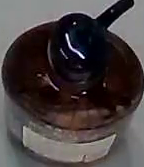

In [28]:
track_imgs[4]

In [3]:
import json
import os

dir_path = "/home/ieemoo0337/projects/datasets/constrast_pair"
dir_names = os.listdir(dir_path)
error_list = []
false_list = []
empty_list = []
pass_list = []
count = 0
for dir in dir_names:
    if count >= 100:
        break
    torch.cuda.empty_cache()
    stream_dict = {}
    sub_dir = os.path.join(dir_path, dir)
    print("barcode: ", dir)
    for file in os.listdir(sub_dir):
        stream_dict["barcode"] = dir
        if file.endswith(".mp4"):
            stream_dict["video"] = os.path.join(sub_dir, file)
            print("video: ", stream_dict["video"])
        elif file.endswith(".jpg"):
            stream_dict["goodsPic"] = os.path.join(sub_dir, file)
            print("goodsPic: ", stream_dict["goodsPic"])
    try:
        result = item_analysis(stream_dict)
        print(result)
        if not result:
            empty_list.append(stream_dict["barcode"])
            continue
    except Exception as e:
        print(f"Error processing {stream_dict['barcode']}: {e}")
        error_list.append(stream_dict["barcode"])
        continue
    if result["is_Same"] == False:
        false_list.append([stream_dict["barcode"], result, stream_dict["video"], stream_dict["goodsPic"]])
    else:
        pass_list.append([stream_dict["barcode"], result,  stream_dict["video"], stream_dict["goodsPic"]])
    del result
    # data_list.append(stream_dict)
    count += 1
print("Precision: ", 1 - len(false_list) / len(dir_names))
with open('pass_list.json', 'w') as f:
    json.dump(pass_list, f)
with open('false_list.json', 'w') as f:
    json.dump(false_list, f)

YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

barcode:  6901668938275
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6901668938275/6901668938275_20241019-175523_back_addGood_5478c9a53bd4_70_13799009402.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6901668938275/6901668938275.jpg


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (1/48) /home/ieemoo0337/projects/datasets/constrast_pair/6901668938275/6901668938275_20241019-175523_back_addGood_5478c9a53bd4_70_13799009402.mp4: 640x512 41.4ms
video 1/1 (2/48) /home/ieemoo0337/projects/datasets/constrast_pair/6901668938275/6901668938275_20241019-175523_back_addGood_5478c9a53bd4_70_13799009402.mp4: 640x512 5.5ms
video 1/1 (3/48) /home/ieemoo0337/projects/datasets/constrast_pair/6901668938275/6901668938275_20241019-175523_back_addGood_5478c9a53bd4_70_13799009402.mp4: 640x512 5.5ms
video 1/1 (4/48) /home/ieemoo0337/projects/datasets/constrast_pair/6901668938275/6901668938275_20241019-175523_back_addGood_5478c9a53bd4_70_13799009402.mp4: 640x512 5.3ms
video 1/1 (5/48) /home/ieemoo0337/projects/datasets/constrast_pair/6901668938275/6901668938275_20241019-175523_back_addGood_5478c9a53bd4_70_13799009402.mp4: 640x512 5.3ms
video 1/1 (6/48) /home/ieemoo0337/projects/datasets/constrast_pair/6901668938275/6901668938275_20241019-175523_back_addGood_5478c9a53bd4_70_1379

根据提供的信息，以下是每张图像的评判结果：

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。

因此，第三张图像是最好的，最终答案为`{'index': 3}`。


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '趣多多 迷你曲奇 擅皮黑巧味', 'Color': '橙色', 'Shape': '长方体', 'Material': '纸质', 'Category': '饼干'}, 'item2': {'Text': '无法识别', 'Color': '未知', 'Shape': '未知', 'Material': '未知', 'Category': '未知'}, 'is_Same': False}
barcode:  6923589467801
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6923589467801/6923589467801_20241020-175754_back_addGood_5478c9a49bfc_5_13799009402.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6923589467801/6923589467801.jpg


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (6/55) /home/ieemoo0337/projects/datasets/constrast_pair/6923589467801/6923589467801_20241020-175754_back_addGood_5478c9a49bfc_5_13799009402.mp4: 640x512 5.4ms
video 1/1 (7/55) /home/ieemoo0337/projects/datasets/constrast_pair/6923589467801/6923589467801_20241020-175754_back_addGood_5478c9a49bfc_5_13799009402.mp4: 640x512 5.4ms
video 1/1 (8/55) /home/ieemoo0337/projects/datasets/constrast_pair/6923589467801/6923589467801_20241020-175754_back_addGood_5478c9a49bfc_5_13799009402.mp4: 640x512 5.4ms
video 1/1 (9/55) /home/ieemoo0337/projects/datasets/constrast_pair/6923589467801/6923589467801_20241020-175754_back_addGood_5478c9a49bfc_5_13799009402.mp4: 640x512 5.5ms
video 1/1 (10/55) /home/ieemoo0337/projects/datasets/constrast_pair/6923589467801/6923589467801_20241020-175754_back_addGood_5478c9a49bfc_5_13799009402.mp4: 640x512 5.4ms
video 1/1 (11/55) /home/ieemoo0337/projects/datasets/constrast_pair/6923589467801/6923589467801_20241020-175754_back_addGood_5478c9a49bfc_5_137990094

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。

因此第三张图像是最好的图，最终答案为'{"index": 3}'。


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': 'Ko+ex 高洁丝 海岛奢宠纯棉 350mm', 'Color': '深蓝色和金色', 'Shape': '矩形，带有弧线设计', 'Material': '纸质', 'Category': '卫生巾'}, 'item2': {'Text': '无法识别', 'Color': '深蓝色和灰色', 'Shape': '矩形', 'Material': '纸质', 'Category': '未知'}, 'is_Same': False}
barcode:  4897102490152
video:  /home/ieemoo0337/projects/datasets/constrast_pair/4897102490152/4897102490152_20241015-143738_back_returnGood_5478c9a48b7e_275_13799009402.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/4897102490152/4897102490152.jpg


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (6/58) /home/ieemoo0337/projects/datasets/constrast_pair/4897102490152/4897102490152_20241015-143738_back_returnGood_5478c9a48b7e_275_13799009402.mp4: 640x512 5.3ms
video 1/1 (7/58) /home/ieemoo0337/projects/datasets/constrast_pair/4897102490152/4897102490152_20241015-143738_back_returnGood_5478c9a48b7e_275_13799009402.mp4: 640x512 5.3ms
video 1/1 (8/58) /home/ieemoo0337/projects/datasets/constrast_pair/4897102490152/4897102490152_20241015-143738_back_returnGood_5478c9a48b7e_275_13799009402.mp4: 640x512 5.3ms
video 1/1 (9/58) /home/ieemoo0337/projects/datasets/constrast_pair/4897102490152/4897102490152_20241015-143738_back_returnGood_5478c9a48b7e_275_13799009402.mp4: 640x512 5.3ms
video 1/1 (10/58) /home/ieemoo0337/projects/datasets/constrast_pair/4897102490152/4897102490152_20241015-143738_back_returnGood_5478c9a48b7e_275_13799009402.mp4: 640x512 5.3ms
video 1/1 (11/58) /home/ieemoo0337/projects/datasets/constrast_pair/4897102490152/4897102490152_20241015-143738_back_returnG

1. 第一张图：图像模糊，主体不清晰，构图不合理。
2. 第二张图：图像较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：图像清晰，主体突出，构图合理，色彩还原真实，无明显噪点或偏色。
4. 第四张图：图像清晰度一般，主体较为清晰，但手部遮挡部分包装。

根据以上描述，第三张图片质量最好。因此答案为：

{'index': 3}
Error processing 4897102490152: list index out of range
barcode:  6971284200049
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6971284200049/6971284200049.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6971284200049/6971284200049_20241018-122548_back_returnGood_5478c9a53be2_620_18358205530.mp4


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (5/66) /home/ieemoo0337/projects/datasets/constrast_pair/6971284200049/6971284200049_20241018-122548_back_returnGood_5478c9a53be2_620_18358205530.mp4: 640x512 5.4ms
video 1/1 (6/66) /home/ieemoo0337/projects/datasets/constrast_pair/6971284200049/6971284200049_20241018-122548_back_returnGood_5478c9a53be2_620_18358205530.mp4: 640x512 5.4ms
video 1/1 (7/66) /home/ieemoo0337/projects/datasets/constrast_pair/6971284200049/6971284200049_20241018-122548_back_returnGood_5478c9a53be2_620_18358205530.mp4: 640x512 5.3ms
video 1/1 (8/66) /home/ieemoo0337/projects/datasets/constrast_pair/6971284200049/6971284200049_20241018-122548_back_returnGood_5478c9a53be2_620_18358205530.mp4: 640x512 5.5ms
video 1/1 (9/66) /home/ieemoo0337/projects/datasets/constrast_pair/6971284200049/6971284200049_20241018-122548_back_returnGood_5478c9a53be2_620_18358205530.mp4: 640x512 5.4ms
video 1/1 (10/66) /home/ieemoo0337/projects/datasets/constrast_pair/6971284200049/6971284200049_20241018-122548_back_returnGo

根据图像质量评判标准，我对每张图像进行评估：

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。

综上所述，第三张图像是最好的，因为它展示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。因此答案是：
{'index': 3}


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '海底捞 番茄牛腩 自煮火锅套餐', 'Color': '橙色和黑色', 'Shape': '矩形盒子', 'Material': '塑料', 'Category': '火锅食材'}, 'item2': {'Text': "McDonald's 早餐食品", 'Color': '白色和粉色', 'Shape': '塑料包装', 'Material': '塑料', 'Category': '快餐食品'}, 'is_Same': False}
barcode:  814255013605
video:  /home/ieemoo0337/projects/datasets/constrast_pair/814255013605/814255013605_20241018-164959_back_returnGood_5478c9a49bfc_130_13867273486.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/814255013605/814255013605.jpg


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (7/52) /home/ieemoo0337/projects/datasets/constrast_pair/814255013605/814255013605_20241018-164959_back_returnGood_5478c9a49bfc_130_13867273486.mp4: 640x512 5.8ms
video 1/1 (8/52) /home/ieemoo0337/projects/datasets/constrast_pair/814255013605/814255013605_20241018-164959_back_returnGood_5478c9a49bfc_130_13867273486.mp4: 640x512 5.9ms
video 1/1 (9/52) /home/ieemoo0337/projects/datasets/constrast_pair/814255013605/814255013605_20241018-164959_back_returnGood_5478c9a49bfc_130_13867273486.mp4: 640x512 5.8ms
video 1/1 (10/52) /home/ieemoo0337/projects/datasets/constrast_pair/814255013605/814255013605_20241018-164959_back_returnGood_5478c9a49bfc_130_13867273486.mp4: 640x512 6.5ms
video 1/1 (11/52) /home/ieemoo0337/projects/datasets/constrast_pair/814255013605/814255013605_20241018-164959_back_returnGood_5478c9a49bfc_130_13867273486.mp4: 640x512 5.8ms
video 1/1 (12/52) /home/ieemoo0337/projects/datasets/constrast_pair/814255013605/814255013605_20241018-164959_back_returnGood_5478c9a

根据提供的图像描述，我将逐一评估每张图片的质量，并根据评判标准进行评分。

1. 第一张图：清晰度较低，有模糊和噪点。色彩还原不准确，主体不够突出。构图不合理，画面布局不协调。
2. 第二张图：清晰度一般，手部遮挡部分文字，影响阅读。色彩还原较为准确，但主体不够突出。
3. 第三张图：清晰度高，色彩还原真实，构图合理，主体突出，整体质量较好。
4. 第四张图：清晰度较低，手部遮挡部分包装。色彩还原较准确，但主体不够突出。
5. 第五张图：清晰度较高，色彩还原真实，构图合理，主体突出，整体质量较好。
6. 第六张图：清晰度中等，背景干扰较多，色彩还原不准确，主体突出但不够明显。
7. 第七张图：清晰度最高，色彩还原真实，构图合理，主体突出，整体质量最好。

综合以上分析，第七张图的质量最高。因此，答案为：
```python
{'index': 7}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': 'Ageratum Smokers Toothpaste (Fresh Mint)', 'Color': '白色膏体', 'Shape': '圆柱形', 'Material': '塑料', 'Category': '牙膏'}, 'item2': {'Text': 'NOCITIN', 'Color': '蓝色', 'Shape': '长方形盒子, 带泵头', 'Material': '纸盒', 'Category': '护肤品或清洁用品'}, 'is_Same': False}
barcode:  6902022134333
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6902022134333/6902022134333.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6902022134333/6902022134333_20241016-113456_back_returnGood_5478c9a48c3e_1110_13799009402.mp4


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (7/55) /home/ieemoo0337/projects/datasets/constrast_pair/6902022134333/6902022134333_20241016-113456_back_returnGood_5478c9a48c3e_1110_13799009402.mp4: 640x512 5.7ms
video 1/1 (8/55) /home/ieemoo0337/projects/datasets/constrast_pair/6902022134333/6902022134333_20241016-113456_back_returnGood_5478c9a48c3e_1110_13799009402.mp4: 640x512 5.6ms
video 1/1 (9/55) /home/ieemoo0337/projects/datasets/constrast_pair/6902022134333/6902022134333_20241016-113456_back_returnGood_5478c9a48c3e_1110_13799009402.mp4: 640x512 5.4ms
video 1/1 (10/55) /home/ieemoo0337/projects/datasets/constrast_pair/6902022134333/6902022134333_20241016-113456_back_returnGood_5478c9a48c3e_1110_13799009402.mp4: 640x512 5.9ms
video 1/1 (11/55) /home/ieemoo0337/projects/datasets/constrast_pair/6902022134333/6902022134333_20241016-113456_back_returnGood_5478c9a48c3e_1110_13799009402.mp4: 640x512 5.5ms
video 1/1 (12/55) /home/ieemoo0337/projects/datasets/constrast_pair/6902022134333/6902022134333_20241016-113456_back_r

根据提供的图像描述，以下是对每张图片质量的评估：

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：图像模糊，细节难以辨认。
6. 第六张图：清晰度较好，标签上的文字可辨认。

从以上分析可以看出，第三张和第六张图片的质量较好。由于问题要求选择质量最好的一张图像，综合考虑清晰度、色彩准确性、构图合理性等因素，第六张图更符合评判标准。

因此，答案是：
{'index': 6}


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '蓝月亮 深层洁净 护理洗衣液', 'Color': '蓝色', 'Shape': '塑料瓶', 'Material': '塑料', 'Category': '洗衣液'}, 'item2': {'Text': '蓝月亮 高性能洗衣液 护衣护色 低泡易漂', 'Color': '蓝色', 'Shape': '塑料瓶', 'Material': '塑料', 'Category': '洗衣液'}, 'is_Same': True}
barcode:  6902022137396
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6902022137396/6902022137396_20241016-113417_back_returnGood_5478c9a48c3e_1060_13799009402.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6902022137396/6902022137396.jpg


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (7/78) /home/ieemoo0337/projects/datasets/constrast_pair/6902022137396/6902022137396_20241016-113417_back_returnGood_5478c9a48c3e_1060_13799009402.mp4: 640x512 5.8ms
video 1/1 (8/78) /home/ieemoo0337/projects/datasets/constrast_pair/6902022137396/6902022137396_20241016-113417_back_returnGood_5478c9a48c3e_1060_13799009402.mp4: 640x512 5.5ms
video 1/1 (9/78) /home/ieemoo0337/projects/datasets/constrast_pair/6902022137396/6902022137396_20241016-113417_back_returnGood_5478c9a48c3e_1060_13799009402.mp4: 640x512 5.4ms
video 1/1 (10/78) /home/ieemoo0337/projects/datasets/constrast_pair/6902022137396/6902022137396_20241016-113417_back_returnGood_5478c9a48c3e_1060_13799009402.mp4: 640x512 5.3ms
video 1/1 (11/78) /home/ieemoo0337/projects/datasets/constrast_pair/6902022137396/6902022137396_20241016-113417_back_returnGood_5478c9a48c3e_1060_13799009402.mp4: 640x512 5.3ms
video 1/1 (12/78) /home/ieemoo0337/projects/datasets/constrast_pair/6902022137396/6902022137396_20241016-113417_back_r

根据提供的图像描述，我将分析每张图片的质量，并根据清晰度、色彩准确性、构图合理性以及完整性给出评价。然后选择质量最好的一张图片并以Python dict格式输出结果。

1. 第一张图片：图像模糊，角度倾斜，无法清晰看到产品细节。
2. 第二张图片：图像较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图片：图像显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图片：图像清晰度一般，手部遮挡部分包装。
5. 第五张图片：图像较清晰，但手部遮挡部分文字，影响阅读。
6. 第六张图片：图像清晰度较高，文字和标签清晰可见，构图合理，主体突出。
7. 第七张图片：图像清晰度较低，部分文字模糊，构图一般。

综合评价：
- 第三张图片在清晰度、色彩准确性、构图合理性以及完整性方面表现最佳。
- 第六张图片也表现较好，但在某些细节上稍逊一筹。

因此，质量最好的图片是第三张或第六张。由于第六张图片在细节上更清晰，我选择第六张作为质量最好的图片。

答案输出为：
```python
{'index': 6}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '蓝月亮 深层洁净护理洗衣液', 'Color': '蓝色', 'Shape': '袋装', 'Material': '塑料', 'Category': '洗衣液'}, 'item2': {'Text': '无法清晰辨认', 'Color': '未知', 'Shape': '未知', 'Material': '未知', 'Category': '未知'}, 'is_Same': False}
barcode:  8935024140147
video:  /home/ieemoo0337/projects/datasets/constrast_pair/8935024140147/8935024140147_20241018-133922_back_returnGood_5478c9a53bd4_55_15027299265.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/8935024140147/8935024140147.jpg


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (7/138) /home/ieemoo0337/projects/datasets/constrast_pair/8935024140147/8935024140147_20241018-133922_back_returnGood_5478c9a53bd4_55_15027299265.mp4: 640x512 5.5ms
video 1/1 (8/138) /home/ieemoo0337/projects/datasets/constrast_pair/8935024140147/8935024140147_20241018-133922_back_returnGood_5478c9a53bd4_55_15027299265.mp4: 640x512 5.4ms
video 1/1 (9/138) /home/ieemoo0337/projects/datasets/constrast_pair/8935024140147/8935024140147_20241018-133922_back_returnGood_5478c9a53bd4_55_15027299265.mp4: 640x512 5.6ms
video 1/1 (10/138) /home/ieemoo0337/projects/datasets/constrast_pair/8935024140147/8935024140147_20241018-133922_back_returnGood_5478c9a53bd4_55_15027299265.mp4: 640x512 5.4ms
video 1/1 (11/138) /home/ieemoo0337/projects/datasets/constrast_pair/8935024140147/8935024140147_20241018-133922_back_returnGood_5478c9a53bd4_55_15027299265.mp4: 640x512 5.4ms
video 1/1 (12/138) /home/ieemoo0337/projects/datasets/constrast_pair/8935024140147/8935024140147_20241018-133922_back_retur

根据提供的图像描述信息，我们可以进行以下分析：

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。

从上述描述来看，第三张图是最好的图像。因此，答案为'{'index': 3}'。


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': 'G7 COFFEE INSTANT COFFEE', 'Color': 'Red', 'Shape': 'Rectangular box', 'Material': 'Cardboard', 'Category': 'Instant Coffee'}, 'item2': {'Text': '无法识别第二张图片中的完整文字信息，只能看到部分标签和条形码。', 'Color': 'Red and yellow', 'Shape': 'Rectangular box', 'Material': 'Cardboard', 'Category': 'Instant Coffee'}, 'is_Same': True}
barcode:  6908594414019
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6908594414019/6908594414019_20241018-143033_back_returnGood_5478c9a48c02_65_13586533739.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6908594414019/6908594414019.jpg


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (7/56) /home/ieemoo0337/projects/datasets/constrast_pair/6908594414019/6908594414019_20241018-143033_back_returnGood_5478c9a48c02_65_13586533739.mp4: 640x512 5.4ms
video 1/1 (8/56) /home/ieemoo0337/projects/datasets/constrast_pair/6908594414019/6908594414019_20241018-143033_back_returnGood_5478c9a48c02_65_13586533739.mp4: 640x512 5.8ms
video 1/1 (9/56) /home/ieemoo0337/projects/datasets/constrast_pair/6908594414019/6908594414019_20241018-143033_back_returnGood_5478c9a48c02_65_13586533739.mp4: 640x512 5.5ms
video 1/1 (10/56) /home/ieemoo0337/projects/datasets/constrast_pair/6908594414019/6908594414019_20241018-143033_back_returnGood_5478c9a48c02_65_13586533739.mp4: 640x512 5.5ms
video 1/1 (11/56) /home/ieemoo0337/projects/datasets/constrast_pair/6908594414019/6908594414019_20241018-143033_back_returnGood_5478c9a48c02_65_13586533739.mp4: 640x512 5.5ms
video 1/1 (12/56) /home/ieemoo0337/projects/datasets/constrast_pair/6908594414019/6908594414019_20241018-143033_back_returnGood_

根据提供的图像质量评判标准，对每张图片进行分析：

1. 第一张图：图像模糊且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：图像模糊，难以辨认具体信息。
6. 第六张图：图像模糊，难以辨认具体信息。
7. 第七张图：图像模糊，难以辨认具体信息。

综合以上分析，第三张图符合清晰度高、色彩还原真实、构图合理、完整性好的标准。因此，答案是：

```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '花王 乐而雅 零触感 特薄0.1cm 舒适 随心动 加速度瞬吸', 'Color': '绿色和金色', 'Shape': '矩形', 'Material': '纸质材料', 'Category': '卫生巾'}, 'item2': {'Text': '乐而雅 卫生巾', 'Color': '绿色和白色', 'Shape': '矩形', 'Material': '纸质材料', 'Category': '卫生巾'}, 'is_Same': True}
barcode:  6940188803618
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6940188803618/6940188803618_20241020-114914_back_addGood_5478c9a53be2_80_13867273486.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6940188803618/6940188803618.jpg


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (7/49) /home/ieemoo0337/projects/datasets/constrast_pair/6940188803618/6940188803618_20241020-114914_back_addGood_5478c9a53be2_80_13867273486.mp4: 640x512 5.6ms
video 1/1 (8/49) /home/ieemoo0337/projects/datasets/constrast_pair/6940188803618/6940188803618_20241020-114914_back_addGood_5478c9a53be2_80_13867273486.mp4: 640x512 5.7ms
video 1/1 (9/49) /home/ieemoo0337/projects/datasets/constrast_pair/6940188803618/6940188803618_20241020-114914_back_addGood_5478c9a53be2_80_13867273486.mp4: 640x512 5.5ms
video 1/1 (10/49) /home/ieemoo0337/projects/datasets/constrast_pair/6940188803618/6940188803618_20241020-114914_back_addGood_5478c9a53be2_80_13867273486.mp4: 640x512 5.5ms
video 1/1 (11/49) /home/ieemoo0337/projects/datasets/constrast_pair/6940188803618/6940188803618_20241020-114914_back_addGood_5478c9a53be2_80_13867273486.mp4: 640x512 5.5ms
video 1/1 (12/49) /home/ieemoo0337/projects/datasets/constrast_pair/6940188803618/6940188803618_20241020-114914_back_addGood_5478c9a53be2_80_13

根据提供的图像描述，我们可以对每张图片的质量进行评判：

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。

综上所述，第三张图是质量最好的一张。因此，答案为：

```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '蟹黄味瓜子仁 Crab Roe Flavor Sunflower Seeds', 'Color': '橙色和白色', 'Shape': '圆角矩形', 'Material': '塑料', 'Category': '零食'}, 'item2': {'Text': '蟹黄味瓜子仁', 'Color': '橙色和白色', 'Shape': '圆角矩形', 'Material': '塑料', 'Category': '零食'}, 'is_Same': True}
barcode:  6921799888393
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6921799888393/6921799888393_20241020-183236_back_returnGood_5478c9a53bd4_50_14785332147.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6921799888393/6921799888393.jpg


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (6/58) /home/ieemoo0337/projects/datasets/constrast_pair/6921799888393/6921799888393_20241020-183236_back_returnGood_5478c9a53bd4_50_14785332147.mp4: 640x512 5.5ms
video 1/1 (7/58) /home/ieemoo0337/projects/datasets/constrast_pair/6921799888393/6921799888393_20241020-183236_back_returnGood_5478c9a53bd4_50_14785332147.mp4: 640x512 5.5ms
video 1/1 (8/58) /home/ieemoo0337/projects/datasets/constrast_pair/6921799888393/6921799888393_20241020-183236_back_returnGood_5478c9a53bd4_50_14785332147.mp4: 640x512 5.5ms
video 1/1 (9/58) /home/ieemoo0337/projects/datasets/constrast_pair/6921799888393/6921799888393_20241020-183236_back_returnGood_5478c9a53bd4_50_14785332147.mp4: 640x512 5.6ms
video 1/1 (10/58) /home/ieemoo0337/projects/datasets/constrast_pair/6921799888393/6921799888393_20241020-183236_back_returnGood_5478c9a53bd4_50_14785332147.mp4: 640x512 5.5ms
video 1/1 (11/58) /home/ieemoo0337/projects/datasets/constrast_pair/6921799888393/6921799888393_20241020-183236_back_returnGood_5

根据提供的图像描述信息，我将对每张图片进行质量评判，并输出最佳图像的索引值。

1. 第一张图：模糊且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：清晰度较差，难以辨认具体信息。
6. 第六张图：较为清晰，但有部分区域被遮挡。
7. 第七张图：清晰度和构图较好，但背景杂乱。

综合考虑图像的清晰度、色彩准确性、构图合理性及完整性，第三张图（第3张）在这些方面表现最好。因此，答案为：

```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '萨拉米 鸡翅', 'Color': '红色', 'Shape': '长方形', 'Material': '塑料', 'Category': '香肠'}, 'item2': {'Text': 'Salam 鸡翅', 'Color': '红色', 'Shape': '长方形', 'Material': '塑料', 'Category': '香肠'}, 'is_Same': True}
barcode:  6970770099716
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6970770099716/6970770099716.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6970770099716/6970770099716_20241018-160508_back_returnGood_5478c9a51ba6_550_18358205530.mp4


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (6/69) /home/ieemoo0337/projects/datasets/constrast_pair/6970770099716/6970770099716_20241018-160508_back_returnGood_5478c9a51ba6_550_18358205530.mp4: 640x512 5.4ms
video 1/1 (7/69) /home/ieemoo0337/projects/datasets/constrast_pair/6970770099716/6970770099716_20241018-160508_back_returnGood_5478c9a51ba6_550_18358205530.mp4: 640x512 5.5ms
video 1/1 (8/69) /home/ieemoo0337/projects/datasets/constrast_pair/6970770099716/6970770099716_20241018-160508_back_returnGood_5478c9a51ba6_550_18358205530.mp4: 640x512 5.5ms
video 1/1 (9/69) /home/ieemoo0337/projects/datasets/constrast_pair/6970770099716/6970770099716_20241018-160508_back_returnGood_5478c9a51ba6_550_18358205530.mp4: 640x512 5.5ms
video 1/1 (10/69) /home/ieemoo0337/projects/datasets/constrast_pair/6970770099716/6970770099716_20241018-160508_back_returnGood_5478c9a51ba6_550_18358205530.mp4: 640x512 5.5ms
video 1/1 (11/69) /home/ieemoo0337/projects/datasets/constrast_pair/6970770099716/6970770099716_20241018-160508_back_returnG

根据提供的图像描述和评判标准，我可以对每张图片的质量进行评估：

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。

基于这些评估，第三张图是质量最好的一张。因此，答案为：

```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '兰芳园 冻柠茶 柠檬味茶饮料', 'Color': '绿色和白色标签，棕色液体', 'Shape': '圆柱形瓶子', 'Material': '塑料瓶', 'Category': '饮料'}, 'is_Same': True}
barcode:  8809102320472
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/8809102320472/8809102320472.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/8809102320472/8809102320472_20241020-101622_back_returnGood_5478c9a53be2_960_13867273486.mp4


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (6/55) /home/ieemoo0337/projects/datasets/constrast_pair/8809102320472/8809102320472_20241020-101622_back_returnGood_5478c9a53be2_960_13867273486.mp4: 640x512 5.5ms
video 1/1 (7/55) /home/ieemoo0337/projects/datasets/constrast_pair/8809102320472/8809102320472_20241020-101622_back_returnGood_5478c9a53be2_960_13867273486.mp4: 640x512 5.4ms
video 1/1 (8/55) /home/ieemoo0337/projects/datasets/constrast_pair/8809102320472/8809102320472_20241020-101622_back_returnGood_5478c9a53be2_960_13867273486.mp4: 640x512 5.5ms
video 1/1 (9/55) /home/ieemoo0337/projects/datasets/constrast_pair/8809102320472/8809102320472_20241020-101622_back_returnGood_5478c9a53be2_960_13867273486.mp4: 640x512 5.5ms
video 1/1 (10/55) /home/ieemoo0337/projects/datasets/constrast_pair/8809102320472/8809102320472_20241020-101622_back_returnGood_5478c9a53be2_960_13867273486.mp4: 640x512 5.5ms
video 1/1 (11/55) /home/ieemoo0337/projects/datasets/constrast_pair/8809102320472/8809102320472_20241020-101622_back_returnG

根据提供的图像描述，以下是对每张图片质量的评估：

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：图像较模糊，难以辨认具体信息。
6. 第六张图：图像模糊且角度倾斜，内容不清晰。

综合以上分析，第三张图是质量最好的，因为其清晰度高、构图合理、主体突出。因此，答案为：

```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '한복수사, 580g', 'Color': '黄色和白色', 'Shape': '圆柱形罐子', 'Material': '玻璃', 'Category': '果酱'}, 'item2': {'Text': 'unknown', 'Color': 'unknown', 'Shape': 'unknown', 'Material': 'unknown', 'Category': 'unknown'}, 'is_Same': False}
barcode:  8801046992715
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/8801046992715/8801046992715.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/8801046992715/8801046992715_20241017-104418_back_returnGood_5478c9a48b7e_700_13799009402.mp4


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (5/53) /home/ieemoo0337/projects/datasets/constrast_pair/8801046992715/8801046992715_20241017-104418_back_returnGood_5478c9a48b7e_700_13799009402.mp4: 640x512 5.6ms
video 1/1 (6/53) /home/ieemoo0337/projects/datasets/constrast_pair/8801046992715/8801046992715_20241017-104418_back_returnGood_5478c9a48b7e_700_13799009402.mp4: 640x512 5.6ms
video 1/1 (7/53) /home/ieemoo0337/projects/datasets/constrast_pair/8801046992715/8801046992715_20241017-104418_back_returnGood_5478c9a48b7e_700_13799009402.mp4: 640x512 5.5ms
video 1/1 (8/53) /home/ieemoo0337/projects/datasets/constrast_pair/8801046992715/8801046992715_20241017-104418_back_returnGood_5478c9a48b7e_700_13799009402.mp4: 640x512 5.6ms
video 1/1 (9/53) /home/ieemoo0337/projects/datasets/constrast_pair/8801046992715/8801046992715_20241017-104418_back_returnGood_5478c9a48b7e_700_13799009402.mp4: 640x512 5.8ms
video 1/1 (10/53) /home/ieemoo0337/projects/datasets/constrast_pair/8801046992715/8801046992715_20241017-104418_back_returnGo

根据图像质量和评判标准，我将对每张图片进行分析：

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。

综合考虑，第三张图的质量最高，因此答案为：
```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': 'Kerasys Lonely', 'Color': '白色', 'Shape': '圆柱形', 'Material': '塑料', 'Category': '护发素'}, 'item2': {'Text': '未知', 'Color': '紫色', 'Shape': '圆柱形', 'Material': '塑料', 'Category': '未知'}, 'is_Same': False}
barcode:  6901285991219
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6901285991219/6901285991219_20241017-161139_back_addGood_5478c9a48b7e_585_13799009402.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6901285991219/6901285991219.jpg


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (8/36) /home/ieemoo0337/projects/datasets/constrast_pair/6901285991219/6901285991219_20241017-161139_back_addGood_5478c9a48b7e_585_13799009402.mp4: 640x512 5.7ms
video 1/1 (9/36) /home/ieemoo0337/projects/datasets/constrast_pair/6901285991219/6901285991219_20241017-161139_back_addGood_5478c9a48b7e_585_13799009402.mp4: 640x512 5.4ms
video 1/1 (10/36) /home/ieemoo0337/projects/datasets/constrast_pair/6901285991219/6901285991219_20241017-161139_back_addGood_5478c9a48b7e_585_13799009402.mp4: 640x512 5.4ms
video 1/1 (11/36) /home/ieemoo0337/projects/datasets/constrast_pair/6901285991219/6901285991219_20241017-161139_back_addGood_5478c9a48b7e_585_13799009402.mp4: 640x512 5.4ms
video 1/1 (12/36) /home/ieemoo0337/projects/datasets/constrast_pair/6901285991219/6901285991219_20241017-161139_back_addGood_5478c9a48b7e_585_13799009402.mp4: 640x512 5.3ms
video 1/1 (13/36) /home/ieemoo0337/projects/datasets/constrast_pair/6901285991219/6901285991219_20241017-161139_back_addGood_5478c9a48b7e

1. 第一张图：图像模糊，难以辨认细节。
2. 第二张图：图像清晰度较低，手指遮挡部分文字。
3. 第三张图：图像清晰，主体突出，构图合理。
4. 第四张图：图像清晰度一般，手指遮挡部分物品。

根据上述描述，第三张图片质量最好。因此，答案是：{'index': 3}


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '怡宝', 'Color': '绿色和白色', 'Shape': '圆柱形带标签', 'Material': '塑料', 'Category': '饮料'}, 'item2': {'Text': '未知', 'Color': '未知', 'Shape': '未知', 'Material': '未知', 'Category': '未知'}, 'is_Same': False}
barcode:  6901012020397
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6901012020397/6901012020397_20241018-152842_back_returnGood_5478c9a48c3e_300_14785332147.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6901012020397/6901012020397.jpg


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (7/63) /home/ieemoo0337/projects/datasets/constrast_pair/6901012020397/6901012020397_20241018-152842_back_returnGood_5478c9a48c3e_300_14785332147.mp4: 640x512 5.4ms
video 1/1 (8/63) /home/ieemoo0337/projects/datasets/constrast_pair/6901012020397/6901012020397_20241018-152842_back_returnGood_5478c9a48c3e_300_14785332147.mp4: 640x512 5.4ms
video 1/1 (9/63) /home/ieemoo0337/projects/datasets/constrast_pair/6901012020397/6901012020397_20241018-152842_back_returnGood_5478c9a48c3e_300_14785332147.mp4: 640x512 6.8ms
video 1/1 (10/63) /home/ieemoo0337/projects/datasets/constrast_pair/6901012020397/6901012020397_20241018-152842_back_returnGood_5478c9a48c3e_300_14785332147.mp4: 640x512 5.5ms
video 1/1 (11/63) /home/ieemoo0337/projects/datasets/constrast_pair/6901012020397/6901012020397_20241018-152842_back_returnGood_5478c9a48c3e_300_14785332147.mp4: 640x512 6.1ms
video 1/1 (12/63) /home/ieemoo0337/projects/datasets/constrast_pair/6901012020397/6901012020397_20241018-152842_back_return

根据提供的图像质量和评判标准，我将逐一评估每张图片的质量：

1. 第一张图：模糊且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：清晰度较差，且手部遮挡较多，影响阅读。
6. 第六张图：清晰度较好，但手部遮挡部分文字，影响阅读。
7. 第七张图：清晰度较高，但手部遮挡较多，影响阅读。
8. 第八张图：清晰度一般，手部遮挡部分文字，影响阅读。

综合来看，第三张图在清晰度、色彩还原和构图合理性上表现最佳。因此，选择第三张图片作为质量最好的图片。

答案输出为：
```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '金奖豆豉鲮鱼', 'Color': '黄色背景，红色和白色文字', 'Shape': '长方形', 'Material': '金属', 'Category': '食品'}, 'item2': {'Text': '未知', 'Color': '浅色背景，白色和黑色文字', 'Shape': '圆形', 'Material': '未知', 'Category': '未知'}, 'is_Same': False}
barcode:  6970296609079
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6970296609079/6970296609079.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6970296609079/6970296609079_20241018-114012_back_returnGood_5478c9a49bfc_1115_18969520488.mp4


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (3/96) /home/ieemoo0337/projects/datasets/constrast_pair/6970296609079/6970296609079_20241018-114012_back_returnGood_5478c9a49bfc_1115_18969520488.mp4: 640x512 5.5ms
video 1/1 (4/96) /home/ieemoo0337/projects/datasets/constrast_pair/6970296609079/6970296609079_20241018-114012_back_returnGood_5478c9a49bfc_1115_18969520488.mp4: 640x512 5.5ms
video 1/1 (5/96) /home/ieemoo0337/projects/datasets/constrast_pair/6970296609079/6970296609079_20241018-114012_back_returnGood_5478c9a49bfc_1115_18969520488.mp4: 640x512 5.6ms
video 1/1 (6/96) /home/ieemoo0337/projects/datasets/constrast_pair/6970296609079/6970296609079_20241018-114012_back_returnGood_5478c9a49bfc_1115_18969520488.mp4: 640x512 5.5ms
video 1/1 (7/96) /home/ieemoo0337/projects/datasets/constrast_pair/6970296609079/6970296609079_20241018-114012_back_returnGood_5478c9a49bfc_1115_18969520488.mp4: 640x512 5.5ms
video 1/1 (8/96) /home/ieemoo0337/projects/datasets/constrast_pair/6970296609079/6970296609079_20241018-114012_back_retu

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。

因此第3张图像是最好的图，最终答案为'{'index': 3}'。


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '山楂汁', 'Color': '红色', 'Shape': '圆柱形', 'Material': '塑料', 'Category': '饮料'}, 'item2': {'Text': '山楂汁', 'Color': '红色', 'Shape': '圆柱形', 'Material': '塑料', 'Category': '饮料'}, 'is_Same': True}
barcode:  6925843404287
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6925843404287/6925843404287_20241020-112911_back_addGood_5478c9a53be2_90_13867273486.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6925843404287/6925843404287.jpg


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (7/60) /home/ieemoo0337/projects/datasets/constrast_pair/6925843404287/6925843404287_20241020-112911_back_addGood_5478c9a53be2_90_13867273486.mp4: 640x512 5.3ms
video 1/1 (8/60) /home/ieemoo0337/projects/datasets/constrast_pair/6925843404287/6925843404287_20241020-112911_back_addGood_5478c9a53be2_90_13867273486.mp4: 640x512 5.3ms
video 1/1 (9/60) /home/ieemoo0337/projects/datasets/constrast_pair/6925843404287/6925843404287_20241020-112911_back_addGood_5478c9a53be2_90_13867273486.mp4: 640x512 5.3ms
video 1/1 (10/60) /home/ieemoo0337/projects/datasets/constrast_pair/6925843404287/6925843404287_20241020-112911_back_addGood_5478c9a53be2_90_13867273486.mp4: 640x512 5.2ms
video 1/1 (11/60) /home/ieemoo0337/projects/datasets/constrast_pair/6925843404287/6925843404287_20241020-112911_back_addGood_5478c9a53be2_90_13867273486.mp4: 640x512 5.6ms
video 1/1 (12/60) /home/ieemoo0337/projects/datasets/constrast_pair/6925843404287/6925843404287_20241020-112911_back_addGood_5478c9a53be2_90_13

根据提供的图像描述和评判标准，以下是每张图片的质量分析：

1. 第一张图：图像清晰度尚可，但有些模糊，色彩还原较为准确，构图合理，主体突出。整体质量较好。
2. 第二张图：图像较清晰，手部遮挡部分文字，影响阅读，但整体构图合理，主体突出。
3. 第三张图：图像显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出，完整性较好。
4. 第四张图：图像清晰度一般，手部遮挡部分包装，但整体构图合理，主体突出。
5. 第五张图：图像较为模糊，细节不清晰，构图不合理，主体不突出。
6. 第六张图：图像清晰度较高，物品细节清晰，构图合理，主体突出。

综合以上分析，第三张图的图像质量和各项评判标准都表现得最好，因此选择第三张图作为最佳图像。

答案输出格式：
```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '黄飞红 蜜辣花生', 'Color': '白色背景，红色和黄色文字', 'Shape': '长方形包装袋', 'Material': '塑料', 'Category': '零食'}, 'item2': {'Text': '黄飞红 蜜辣花生', 'Color': '白色背景，红色和黄色文字', 'Shape': '长方形包装袋', 'Material': '塑料', 'Category': '零食'}, 'is_Same': True}
barcode:  6901826888145
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6901826888145/6901826888145_20241019-112136_back_addGood_5478c9a53bca_50_18358205530.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6901826888145/6901826888145.jpg


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (7/98) /home/ieemoo0337/projects/datasets/constrast_pair/6901826888145/6901826888145_20241019-112136_back_addGood_5478c9a53bca_50_18358205530.mp4: 640x512 5.6ms
video 1/1 (8/98) /home/ieemoo0337/projects/datasets/constrast_pair/6901826888145/6901826888145_20241019-112136_back_addGood_5478c9a53bca_50_18358205530.mp4: 640x512 5.6ms
video 1/1 (9/98) /home/ieemoo0337/projects/datasets/constrast_pair/6901826888145/6901826888145_20241019-112136_back_addGood_5478c9a53bca_50_18358205530.mp4: 640x512 5.6ms
video 1/1 (10/98) /home/ieemoo0337/projects/datasets/constrast_pair/6901826888145/6901826888145_20241019-112136_back_addGood_5478c9a53bca_50_18358205530.mp4: 640x512 6.1ms
video 1/1 (11/98) /home/ieemoo0337/projects/datasets/constrast_pair/6901826888145/6901826888145_20241019-112136_back_addGood_5478c9a53bca_50_18358205530.mp4: 640x512 5.4ms
video 1/1 (12/98) /home/ieemoo0337/projects/datasets/constrast_pair/6901826888145/6901826888145_20241019-112136_back_addGood_5478c9a53bca_50_18

根据提供的图像质量和评判标准，我可以分析每张图像的清晰度、色彩准确性、构图合理性以及完整性。以下是每张图像的简短判断：

1. 第一张图：模糊且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：清晰度较好，标签和电池细节清晰可见。
6. 第六张图：清晰度适中，标签和电池细节较为清晰。
7. 第七张图：清晰度较低，细节不明显。

基于以上分析，第三张图是质量最好的图像，因为它展示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。因此，答案为：

```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '南孚电池', 'Color': '红色和黄色', 'Shape': '长方形', 'Material': '塑料', 'Category': '电池'}, 'item2': {'Text': '南孚电池', 'Color': '红色和黄色', 'Shape': '长方形', 'Material': '塑料', 'Category': '电池'}, 'is_Same': True}
barcode:  6921569399302
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6921569399302/6921569399302.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6921569399302/6921569399302_20241020-183138_back_addGood_5478c9a53bca_50_18996891184.mp4


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (7/132) /home/ieemoo0337/projects/datasets/constrast_pair/6921569399302/6921569399302_20241020-183138_back_addGood_5478c9a53bca_50_18996891184.mp4: 640x512 5.5ms
video 1/1 (8/132) /home/ieemoo0337/projects/datasets/constrast_pair/6921569399302/6921569399302_20241020-183138_back_addGood_5478c9a53bca_50_18996891184.mp4: 640x512 5.5ms
video 1/1 (9/132) /home/ieemoo0337/projects/datasets/constrast_pair/6921569399302/6921569399302_20241020-183138_back_addGood_5478c9a53bca_50_18996891184.mp4: 640x512 5.5ms
video 1/1 (10/132) /home/ieemoo0337/projects/datasets/constrast_pair/6921569399302/6921569399302_20241020-183138_back_addGood_5478c9a53bca_50_18996891184.mp4: 640x512 5.5ms
video 1/1 (11/132) /home/ieemoo0337/projects/datasets/constrast_pair/6921569399302/6921569399302_20241020-183138_back_addGood_5478c9a53bca_50_18996891184.mp4: 640x512 5.5ms
video 1/1 (12/132) /home/ieemoo0337/projects/datasets/constrast_pair/6921569399302/6921569399302_20241020-183138_back_addGood_5478c9a53bca

根据提供的图像描述信息，我可以对每张图像的质量进行评估，并选择质量最好的一张。以下是每个图像的评价：

1. 第一张图：模糊且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。

基于上述分析，第三张图是最清晰和构图合理的，因此它是质量最好的一张图像。

答案输出格式如下：
{'index': 3}


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '机灵小蜜蜂巧克力', 'Color': '金色、黑色、橙色、绿色', 'Shape': '圆柱形', 'Material': '巧克力包裹纸', 'Category': '巧克力'}, 'item2': {'Text': '未知', 'Color': '金色、黑色、橙色、绿色', 'Shape': '圆柱形', 'Material': '巧克力包裹纸', 'Category': '巧克力'}, 'is_Same': True}
barcode:  6920459996362
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6920459996362/6920459996362.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6920459996362/6920459996362_20241019-103342_back_addGood_5478c9a48b8c_1090_18996891184.mp4


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (17/74) /home/ieemoo0337/projects/datasets/constrast_pair/6920459996362/6920459996362_20241019-103342_back_addGood_5478c9a48b8c_1090_18996891184.mp4: 640x512 (no detections), 5.7ms
video 1/1 (18/74) /home/ieemoo0337/projects/datasets/constrast_pair/6920459996362/6920459996362_20241019-103342_back_addGood_5478c9a48b8c_1090_18996891184.mp4: 640x512 (no detections), 5.5ms
video 1/1 (19/74) /home/ieemoo0337/projects/datasets/constrast_pair/6920459996362/6920459996362_20241019-103342_back_addGood_5478c9a48b8c_1090_18996891184.mp4: 640x512 5.5ms
video 1/1 (20/74) /home/ieemoo0337/projects/datasets/constrast_pair/6920459996362/6920459996362_20241019-103342_back_addGood_5478c9a48b8c_1090_18996891184.mp4: 640x512 5.3ms
video 1/1 (21/74) /home/ieemoo0337/projects/datasets/constrast_pair/6920459996362/6920459996362_20241019-103342_back_addGood_5478c9a48b8c_1090_18996891184.mp4: 640x512 5.4ms
video 1/1 (22/74) /home/ieemoo0337/projects/datasets/constrast_pair/6920459996362/6920459996362_

根据提供的图像描述，我们可以分析每张图片的质量，并按照评判标准进行评分。以下是每张图片的简要质量评估：

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。

综合以上分析，第三张图片在清晰度、色彩准确性、构图合理性等方面表现最好，因此选择第三张作为质量最好的图片。

答案输出为：
```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '康师傅 冰红茶', 'Color': '橙色', 'Shape': '长方形', 'Material': '塑料', 'Category': '饮料'}, 'item2': {'Text': '百事可乐', 'Color': '深棕色', 'Shape': '长方形', 'Material': '塑料', 'Category': '饮料'}, 'is_Same': False}
barcode:  6901668005915
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6901668005915/6901668005915.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6901668005915/6901668005915_20241020-133722_back_returnGood_5478c9a48b8c_115_18358205530.mp4


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (6/59) /home/ieemoo0337/projects/datasets/constrast_pair/6901668005915/6901668005915_20241020-133722_back_returnGood_5478c9a48b8c_115_18358205530.mp4: 640x512 5.5ms
video 1/1 (7/59) /home/ieemoo0337/projects/datasets/constrast_pair/6901668005915/6901668005915_20241020-133722_back_returnGood_5478c9a48b8c_115_18358205530.mp4: 640x512 5.6ms
video 1/1 (8/59) /home/ieemoo0337/projects/datasets/constrast_pair/6901668005915/6901668005915_20241020-133722_back_returnGood_5478c9a48b8c_115_18358205530.mp4: 640x512 5.5ms
video 1/1 (9/59) /home/ieemoo0337/projects/datasets/constrast_pair/6901668005915/6901668005915_20241020-133722_back_returnGood_5478c9a48b8c_115_18358205530.mp4: 640x512 5.5ms
video 1/1 (10/59) /home/ieemoo0337/projects/datasets/constrast_pair/6901668005915/6901668005915_20241020-133722_back_returnGood_5478c9a48b8c_115_18358205530.mp4: 640x512 5.4ms
video 1/1 (11/59) /home/ieemoo0337/projects/datasets/constrast_pair/6901668005915/6901668005915_20241020-133722_back_returnG

根据提供的图像描述，我们可以评估每张图片的质量并选择最佳图像。以下是每个图像的简短质量判断：

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：手部遮挡部分内容，整体清晰度和构图尚可。
6. 第六张图：手部遮挡部分内容，画面有些模糊。
7. 第七张图：清晰度较差，手部遮挡部分内容。

综合考虑清晰度、色彩准确性、构图合理性及完整性，第三张图（REF_3_FIG）在这些方面表现最好，因此选择它作为最佳图像。

答案输出格式为：
```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '奥利奥', 'Color': '蓝色和粉色', 'Shape': '长方形', 'Material': '纸盒', 'Category': '饼干'}, 'item2': {'Text': 'Oreo', 'Color': '黑色', 'Shape': '圆形', 'Material': '饼干', 'Category': '饼干'}, 'is_Same': False}
barcode:  6922300667940
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6922300667940/6922300667940_20241019-115017_back_addGood_5478c9a53bd4_5_13799009402.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6922300667940/6922300667940.jpg


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (6/46) /home/ieemoo0337/projects/datasets/constrast_pair/6922300667940/6922300667940_20241019-115017_back_addGood_5478c9a53bd4_5_13799009402.mp4: 640x512 5.4ms
video 1/1 (7/46) /home/ieemoo0337/projects/datasets/constrast_pair/6922300667940/6922300667940_20241019-115017_back_addGood_5478c9a53bd4_5_13799009402.mp4: 640x512 5.4ms
video 1/1 (8/46) /home/ieemoo0337/projects/datasets/constrast_pair/6922300667940/6922300667940_20241019-115017_back_addGood_5478c9a53bd4_5_13799009402.mp4: 640x512 5.4ms
video 1/1 (9/46) /home/ieemoo0337/projects/datasets/constrast_pair/6922300667940/6922300667940_20241019-115017_back_addGood_5478c9a53bd4_5_13799009402.mp4: 640x512 5.3ms
video 1/1 (10/46) /home/ieemoo0337/projects/datasets/constrast_pair/6922300667940/6922300667940_20241019-115017_back_addGood_5478c9a53bd4_5_13799009402.mp4: 640x512 5.3ms
video 1/1 (11/46) /home/ieemoo0337/projects/datasets/constrast_pair/6922300667940/6922300667940_20241019-115017_back_addGood_5478c9a53bd4_5_137990094

根据图像质量评判标准，对每张图片进行分析：

1. 第一张图：模糊且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张：较模糊，细节难以辨认。
6. 第六张：清晰度较高，标签和其他信息清晰可见，构图合理，主体突出。
7. 第七张：清晰度高，标签和其他信息清晰可见，构图合理，主体突出。

综合来看，第三张和第六、第七张图片质量较好。由于需要选择一张最好的图片，且题目中没有明确要求选择哪张，因此我将选择其中一张作为最佳图像。根据视觉效果，我选择第六张图片作为最佳图像。

答案输出为：
```python
{'index': 6}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '陈皮李饼', 'Color': '棕色', 'Shape': '矩形', 'Material': '塑料', 'Category': '零食'}, 'item2': {'Text': '陈皮李饼', 'Color': '棕色', 'Shape': '不规则形状', 'Material': '金属', 'Category': '零食'}, 'is_Same': False}
barcode:  6938648520120
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6938648520120/6938648520120.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6938648520120/6938648520120_20241020-102931_back_returnGood_5478c9a48b8c_10110_17700000001.mp4


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (4/185) /home/ieemoo0337/projects/datasets/constrast_pair/6938648520120/6938648520120_20241020-102931_back_returnGood_5478c9a48b8c_10110_17700000001.mp4: 640x512 5.4ms
video 1/1 (5/185) /home/ieemoo0337/projects/datasets/constrast_pair/6938648520120/6938648520120_20241020-102931_back_returnGood_5478c9a48b8c_10110_17700000001.mp4: 640x512 5.5ms
video 1/1 (6/185) /home/ieemoo0337/projects/datasets/constrast_pair/6938648520120/6938648520120_20241020-102931_back_returnGood_5478c9a48b8c_10110_17700000001.mp4: 640x512 5.4ms
video 1/1 (7/185) /home/ieemoo0337/projects/datasets/constrast_pair/6938648520120/6938648520120_20241020-102931_back_returnGood_5478c9a48b8c_10110_17700000001.mp4: 640x512 5.4ms
video 1/1 (8/185) /home/ieemoo0337/projects/datasets/constrast_pair/6938648520120/6938648520120_20241020-102931_back_returnGood_5478c9a48b8c_10110_17700000001.mp4: 640x512 5.4ms
video 1/1 (9/185) /home/ieemoo0337/projects/datasets/constrast_pair/6938648520120/6938648520120_20241020-10293

根据提供的图像质量和评判标准，我会逐一分析每张图片的质量，并选择其中质量最好的一张。

1. 第一张图：清晰度较低，有明显的模糊和噪点。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：清晰度较高，标签和其他信息清晰可见，构图合理，主体突出。
6. 第六张图：清晰度较高，标签和其他信息清晰可见，构图合理，主体突出。
7. 第七张图：清晰度较高，标签和其他信息清晰可见，构图合理，主体突出。
8. 第八张图：清晰度较高，标签和其他信息清晰可见，构图合理，主体突出。
9. 第九张图：清晰度较低，有明显的模糊。
10. 第十张图：清晰度较低，有明显的模糊。

经过分析，第三张图、第五张图、第六张图、第七张图、第八张图的质量都比较高。由于这些图的质量都很接近，我选择最清晰的一张作为最佳图像。

最终答案为:
```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '方飞 稻香贡米 正宗黑龙江方正大米', 'Color': '黄色', 'Shape': '长方形', 'Material': '纸质', 'Category': '大米'}, 'item2': {'Text': '方飞 稻香贡米 地道东北大米', 'Color': '黄色', 'Shape': '长方形', 'Material': '纸质', 'Category': '大米'}, 'is_Same': True}
barcode:  5603278016817
video:  /home/ieemoo0337/projects/datasets/constrast_pair/5603278016817/5603278016817_20241015-104303_back_addGood_5478c9a51ba6_820_18358205530.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/5603278016817/5603278016817.jpg


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (7/96) /home/ieemoo0337/projects/datasets/constrast_pair/5603278016817/5603278016817_20241015-104303_back_addGood_5478c9a51ba6_820_18358205530.mp4: 640x512 5.5ms
video 1/1 (8/96) /home/ieemoo0337/projects/datasets/constrast_pair/5603278016817/5603278016817_20241015-104303_back_addGood_5478c9a51ba6_820_18358205530.mp4: 640x512 5.4ms
video 1/1 (9/96) /home/ieemoo0337/projects/datasets/constrast_pair/5603278016817/5603278016817_20241015-104303_back_addGood_5478c9a51ba6_820_18358205530.mp4: 640x512 5.7ms
video 1/1 (10/96) /home/ieemoo0337/projects/datasets/constrast_pair/5603278016817/5603278016817_20241015-104303_back_addGood_5478c9a51ba6_820_18358205530.mp4: 640x512 5.5ms
video 1/1 (11/96) /home/ieemoo0337/projects/datasets/constrast_pair/5603278016817/5603278016817_20241015-104303_back_addGood_5478c9a51ba6_820_18358205530.mp4: 640x512 5.6ms
video 1/1 (12/96) /home/ieemoo0337/projects/datasets/constrast_pair/5603278016817/5603278016817_20241015-104303_back_addGood_5478c9a51ba6_

根据提供的图像描述，我将对每张图片进行质量评估，并选择质量最好的一张。

1. 第一张图：图像模糊且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：图像模糊，难以辨认产品细节。

通过对比，第三张图的清晰度最高，构图合理，主体突出。因此，质量最好的一张图像是第三张。

答案输出为：
{'index': 3}


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': 'Mootaa WG GEL MARINHO-MARINE', 'Color': '蓝色和白色', 'Shape': '圆柱形带喷嘴', 'Material': '塑料', 'Category': '清洁剂'}, 'item2': {'Text': 'Mootaa WG GEL MARINHO-MARINE', 'Color': '蓝色和白色', 'Shape': '圆柱形带喷嘴', 'Material': '塑料', 'Category': '清洁剂'}, 'is_Same': True}
barcode:  6901668939074
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6901668939074/6901668939074.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6901668939074/6901668939074_20241014-152910_back_returnGood_5478c9a48c3e_540_13773168720.mp4


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (6/92) /home/ieemoo0337/projects/datasets/constrast_pair/6901668939074/6901668939074_20241014-152910_back_returnGood_5478c9a48c3e_540_13773168720.mp4: 640x512 5.6ms
video 1/1 (7/92) /home/ieemoo0337/projects/datasets/constrast_pair/6901668939074/6901668939074_20241014-152910_back_returnGood_5478c9a48c3e_540_13773168720.mp4: 640x512 5.8ms
video 1/1 (8/92) /home/ieemoo0337/projects/datasets/constrast_pair/6901668939074/6901668939074_20241014-152910_back_returnGood_5478c9a48c3e_540_13773168720.mp4: 640x512 5.5ms
video 1/1 (9/92) /home/ieemoo0337/projects/datasets/constrast_pair/6901668939074/6901668939074_20241014-152910_back_returnGood_5478c9a48c3e_540_13773168720.mp4: 640x512 5.5ms
video 1/1 (10/92) /home/ieemoo0337/projects/datasets/constrast_pair/6901668939074/6901668939074_20241014-152910_back_returnGood_5478c9a48c3e_540_13773168720.mp4: 640x512 5.5ms
video 1/1 (11/92) /home/ieemoo0337/projects/datasets/constrast_pair/6901668939074/6901668939074_20241014-152910_back_returnG

根据提供的图像描述和评判标准，以下是对每张图片质量的分析：

1. 第一张图：图像清晰度较高，色彩还原真实，构图合理，主体突出。
2. 第二张图：图像清晰度稍差，手部遮挡部分文字，影响阅读。
3. 第三张图：图像清晰度高，构图合理，主体突出。
4. 第四张图：图像清晰度一般，手部遮挡部分包装。
5. 第五张图：图像模糊且角度倾斜，无法清晰看到产品细节。
6. 第六张图：图像清晰度高，构图合理，主体突出。

综合考虑图像的质量，第三张图在清晰度、色彩准确性、构图合理性等方面表现最佳。因此，答案是：

```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '趣多多！缤纷桶 4IN1 绽放桶', 'Color': '蓝色', 'Shape': '圆筒形', 'Material': '塑料', 'Category': '冰淇淋'}, 'item2': {'Text': '趣多多！缤纷桶 4种口味', 'Color': '蓝色', 'Shape': '圆筒形', 'Material': '塑料', 'Category': '冰淇淋'}, 'is_Same': True}
barcode:  6908594426067
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6908594426067/6908594426067.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6908594426067/6908594426067_20241018-174745_back_addGood_5478c9a48c28_45_13773168720.mp4


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (8/39) /home/ieemoo0337/projects/datasets/constrast_pair/6908594426067/6908594426067_20241018-174745_back_addGood_5478c9a48c28_45_13773168720.mp4: 640x512 5.4ms
video 1/1 (9/39) /home/ieemoo0337/projects/datasets/constrast_pair/6908594426067/6908594426067_20241018-174745_back_addGood_5478c9a48c28_45_13773168720.mp4: 640x512 5.6ms
video 1/1 (10/39) /home/ieemoo0337/projects/datasets/constrast_pair/6908594426067/6908594426067_20241018-174745_back_addGood_5478c9a48c28_45_13773168720.mp4: 640x512 5.5ms
video 1/1 (11/39) /home/ieemoo0337/projects/datasets/constrast_pair/6908594426067/6908594426067_20241018-174745_back_addGood_5478c9a48c28_45_13773168720.mp4: 640x512 5.4ms
video 1/1 (12/39) /home/ieemoo0337/projects/datasets/constrast_pair/6908594426067/6908594426067_20241018-174745_back_addGood_5478c9a48c28_45_13773168720.mp4: 640x512 5.7ms
video 1/1 (13/39) /home/ieemoo0337/projects/datasets/constrast_pair/6908594426067/6908594426067_20241018-174745_back_addGood_5478c9a48c28_45_1

根据提供的图像质量和评判标准，经过分析后得出以下结论：

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。

综合以上分析，第三张图的质量最好。因此，答案为：
```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': ['花王', 'Laurier', '乐而雅', '小巧轻盈', '零触感', '特薄 0.1 cm', '羽感棉', '量少 日用 17 cm', '超丝薄 棉柔表层', '净含量：14片 卫生巾'], 'Color': '黄色', 'Shape': '矩形', 'Material': '未知', 'Category': '卫生巾'}, 'item2': {'Text': ['未知'], 'Color': '粉色', 'Shape': '矩形', 'Material': '未知', 'Category': '未知'}, 'is_Same': False}
barcode:  6932571031241
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6932571031241/6932571031241_20241016-140422_back_returnGood_5478c9a49bfc_500_18358205530.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6932571031241/6932571031241.jpg


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (6/106) /home/ieemoo0337/projects/datasets/constrast_pair/6932571031241/6932571031241_20241016-140422_back_returnGood_5478c9a49bfc_500_18358205530.mp4: 640x512 5.4ms
video 1/1 (7/106) /home/ieemoo0337/projects/datasets/constrast_pair/6932571031241/6932571031241_20241016-140422_back_returnGood_5478c9a49bfc_500_18358205530.mp4: 640x512 5.4ms
video 1/1 (8/106) /home/ieemoo0337/projects/datasets/constrast_pair/6932571031241/6932571031241_20241016-140422_back_returnGood_5478c9a49bfc_500_18358205530.mp4: 640x512 5.4ms
video 1/1 (9/106) /home/ieemoo0337/projects/datasets/constrast_pair/6932571031241/6932571031241_20241016-140422_back_returnGood_5478c9a49bfc_500_18358205530.mp4: 640x512 5.6ms
video 1/1 (10/106) /home/ieemoo0337/projects/datasets/constrast_pair/6932571031241/6932571031241_20241016-140422_back_returnGood_5478c9a49bfc_500_18358205530.mp4: 640x512 5.4ms
video 1/1 (11/106) /home/ieemoo0337/projects/datasets/constrast_pair/6932571031241/6932571031241_20241016-140422_back_r

根据提供的信息，我无法直接识别出图片的清晰度、色彩准确性、构图合理性以及完整性。因此，我无法准确评判哪张图片质量最好，并提供相应的Python dict格式输出。

如果你能提供每张图片的具体描述或链接，我可以帮助你进行分析和判断。
Error processing 6932571031241: 'NoneType' object has no attribute 'group'
barcode:  9310072012599
video:  /home/ieemoo0337/projects/datasets/constrast_pair/9310072012599/9310072012599_20241017-181911_back_addGood_5478c9a48c3e_215_13586533739.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/9310072012599/9310072012599.jpg


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (8/66) /home/ieemoo0337/projects/datasets/constrast_pair/9310072012599/9310072012599_20241017-181911_back_addGood_5478c9a48c3e_215_13586533739.mp4: 640x512 5.5ms
video 1/1 (9/66) /home/ieemoo0337/projects/datasets/constrast_pair/9310072012599/9310072012599_20241017-181911_back_addGood_5478c9a48c3e_215_13586533739.mp4: 640x512 5.6ms
video 1/1 (10/66) /home/ieemoo0337/projects/datasets/constrast_pair/9310072012599/9310072012599_20241017-181911_back_addGood_5478c9a48c3e_215_13586533739.mp4: 640x512 5.5ms
video 1/1 (11/66) /home/ieemoo0337/projects/datasets/constrast_pair/9310072012599/9310072012599_20241017-181911_back_addGood_5478c9a48c3e_215_13586533739.mp4: 640x512 5.4ms
video 1/1 (12/66) /home/ieemoo0337/projects/datasets/constrast_pair/9310072012599/9310072012599_20241017-181911_back_addGood_5478c9a48c3e_215_13586533739.mp4: 640x512 5.5ms
video 1/1 (13/66) /home/ieemoo0337/projects/datasets/constrast_pair/9310072012599/9310072012599_20241017-181911_back_addGood_5478c9a48c3e

根据提供的图像质量和评判标准，我将逐一分析每张图片：

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：模糊且角度倾斜，难以辨认具体细节。
6. 第六张图：模糊且角度倾斜，难以辨认具体细节。
7. 第七张图：模糊且角度倾斜，难以辨认具体细节。
8. 第八张图：清晰度较高，但手部遮挡部分文字，影响阅读。
9. 第九张图：清晰度较高，但手部遮挡部分文字，影响阅读。
10. 第十张图：清晰度较高，但手部遮挡部分文字，影响阅读。
11. 第十一张图：清晰度较高，但手部遮挡部分文字，影响阅读。
12. 第十二张图：清晰度最高，文字和图案清晰可辨，构图合理，主体突出。

综合以上分析，第十二张图的质量最好。因此，答案是：
```python
{'index': 12}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': 'Tim Tam Dark', 'Color': '深棕色', 'Shape': '长方形', 'Material': '纸板和巧克力', 'Category': '饼干'}, 'item2': {'Text': 'Tim Tam Dark', 'Color': '深棕色', 'Shape': '长方形', 'Material': '纸板和巧克力', 'Category': '饼干'}, 'is_Same': True}
barcode:  6930420009731
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6930420009731/6930420009731.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6930420009731/6930420009731_20241018-111627_back_addGood_5478c9a48c02_740_13586533739.mp4


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (6/83) /home/ieemoo0337/projects/datasets/constrast_pair/6930420009731/6930420009731_20241018-111627_back_addGood_5478c9a48c02_740_13586533739.mp4: 640x512 5.5ms
video 1/1 (7/83) /home/ieemoo0337/projects/datasets/constrast_pair/6930420009731/6930420009731_20241018-111627_back_addGood_5478c9a48c02_740_13586533739.mp4: 640x512 5.6ms
video 1/1 (8/83) /home/ieemoo0337/projects/datasets/constrast_pair/6930420009731/6930420009731_20241018-111627_back_addGood_5478c9a48c02_740_13586533739.mp4: 640x512 5.5ms
video 1/1 (9/83) /home/ieemoo0337/projects/datasets/constrast_pair/6930420009731/6930420009731_20241018-111627_back_addGood_5478c9a48c02_740_13586533739.mp4: 640x512 5.5ms
video 1/1 (10/83) /home/ieemoo0337/projects/datasets/constrast_pair/6930420009731/6930420009731_20241018-111627_back_addGood_5478c9a48c02_740_13586533739.mp4: 640x512 5.6ms
video 1/1 (11/83) /home/ieemoo0337/projects/datasets/constrast_pair/6930420009731/6930420009731_20241018-111627_back_addGood_5478c9a48c02_7

根据提供的图像描述和评判标准，以下是每张图片的质量分析：

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。

基于上述分析，第三张图的质量最高。因此，输出结果为：
```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '吕 SHINE & SMOOTH Damage Care SHAMPOO CAMELLIA FLOWER HONEY', 'Color': '红色', 'Shape': '长方形', 'Material': '塑料', 'Category': '洗发水'}, 'item2': {'Text': '未知', 'Color': '红色', 'Shape': '圆形', 'Material': '金属', 'Category': '泵头'}, 'is_Same': False}
barcode:  4571589900204
video:  /home/ieemoo0337/projects/datasets/constrast_pair/4571589900204/4571589900204_20241020-171327_back_addGood_5478c9a49bfc_5_13799009402.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/4571589900204/4571589900204.jpg


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (8/30) /home/ieemoo0337/projects/datasets/constrast_pair/4571589900204/4571589900204_20241020-171327_back_addGood_5478c9a49bfc_5_13799009402.mp4: 640x512 5.4ms
video 1/1 (9/30) /home/ieemoo0337/projects/datasets/constrast_pair/4571589900204/4571589900204_20241020-171327_back_addGood_5478c9a49bfc_5_13799009402.mp4: 640x512 5.5ms
video 1/1 (10/30) /home/ieemoo0337/projects/datasets/constrast_pair/4571589900204/4571589900204_20241020-171327_back_addGood_5478c9a49bfc_5_13799009402.mp4: 640x512 5.5ms
video 1/1 (11/30) /home/ieemoo0337/projects/datasets/constrast_pair/4571589900204/4571589900204_20241020-171327_back_addGood_5478c9a49bfc_5_13799009402.mp4: 640x512 5.4ms
video 1/1 (12/30) /home/ieemoo0337/projects/datasets/constrast_pair/4571589900204/4571589900204_20241020-171327_back_addGood_5478c9a49bfc_5_13799009402.mp4: 640x512 5.4ms
video 1/1 (13/30) /home/ieemoo0337/projects/datasets/constrast_pair/4571589900204/4571589900204_20241020-171327_back_addGood_5478c9a49bfc_5_1379900

根据提供的图像质量评判标准，我会逐一评估每张图片的质量，并选择其中质量最好的一张。

1. 第一张图：模糊且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：图像较为模糊，难以辨认具体细节。
6. 第六张图：图像清晰度一般，手部遮挡部分细节。

通过分析，第三张图在清晰度、色彩准确性、构图合理性以及完整性方面表现最佳。因此，选择第三张图为质量最好的图片。

答案输出格式如下：
```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '未知', 'Color': '白色', 'Shape': '圆柱形', 'Material': '塑料', 'Category': '保健品'}, 'item2': {'Text': '未知', 'Color': '金色', 'Shape': '球形', 'Material': '金属', 'Category': '运动装备'}, 'is_Same': False}
barcode:  9557071000121
video:  /home/ieemoo0337/projects/datasets/constrast_pair/9557071000121/9557071000121_20241015-170703_back_returnGood_5478c9a53bf4_160_13773168720.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/9557071000121/9557071000121.jpg


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (7/86) /home/ieemoo0337/projects/datasets/constrast_pair/9557071000121/9557071000121_20241015-170703_back_returnGood_5478c9a53bf4_160_13773168720.mp4: 640x512 5.4ms
video 1/1 (8/86) /home/ieemoo0337/projects/datasets/constrast_pair/9557071000121/9557071000121_20241015-170703_back_returnGood_5478c9a53bf4_160_13773168720.mp4: 640x512 5.4ms
video 1/1 (9/86) /home/ieemoo0337/projects/datasets/constrast_pair/9557071000121/9557071000121_20241015-170703_back_returnGood_5478c9a53bf4_160_13773168720.mp4: 640x512 5.3ms
video 1/1 (10/86) /home/ieemoo0337/projects/datasets/constrast_pair/9557071000121/9557071000121_20241015-170703_back_returnGood_5478c9a53bf4_160_13773168720.mp4: 640x512 5.4ms
video 1/1 (11/86) /home/ieemoo0337/projects/datasets/constrast_pair/9557071000121/9557071000121_20241015-170703_back_returnGood_5478c9a53bf4_160_13773168720.mp4: 640x512 5.6ms
video 1/1 (12/86) /home/ieemoo0337/projects/datasets/constrast_pair/9557071000121/9557071000121_20241015-170703_back_return

根据提供的图像描述信息，我可以帮助您识别出质量最好的一张图像，并以指定的Python dict格式输出结果。

1. 第一张图：图像模糊且角度倾斜，无法清晰看到产品细节。
2. 第二张图：图像较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：图像显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：图像清晰度一般，手部遮挡部分包装。
5. 第五张图：图像清晰，文字和标签清晰可见，构图合理。
6. 第六张图：图像清晰，文字和标签清晰可见，构图合理。
7. 第七张图：图像清晰，文字和标签清晰可见，构图合理。

通过比较以上描述，第三张图片的质量最高。因此，答案为：

```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': 'Six Seasons, Pleasures Tea, TOOTHPASTE, COCONUT, 120g e | Tongue Cleaner', 'Color': 'Green and white', 'Shape': 'Rectangular with a circular design element', 'Material': 'Unknown', 'Category': 'Toothpaste'}, 'item2': {'Text': 'FOOT UPLANDER', 'Color': 'Green and brown', 'Shape': 'Rectangular with a curved top edge', 'Material': 'Unknown', 'Category': 'Foot care product'}, 'is_Same': False}
barcode:  6975271611405
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6975271611405/6975271611405.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6975271611405/6975271611405_20241014-173226_back_addGood_5478c9a53bf4_5_13799009402.mp4


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (8/63) /home/ieemoo0337/projects/datasets/constrast_pair/6975271611405/6975271611405_20241014-173226_back_addGood_5478c9a53bf4_5_13799009402.mp4: 640x512 5.6ms
video 1/1 (9/63) /home/ieemoo0337/projects/datasets/constrast_pair/6975271611405/6975271611405_20241014-173226_back_addGood_5478c9a53bf4_5_13799009402.mp4: 640x512 5.8ms
video 1/1 (10/63) /home/ieemoo0337/projects/datasets/constrast_pair/6975271611405/6975271611405_20241014-173226_back_addGood_5478c9a53bf4_5_13799009402.mp4: 640x512 5.6ms
video 1/1 (11/63) /home/ieemoo0337/projects/datasets/constrast_pair/6975271611405/6975271611405_20241014-173226_back_addGood_5478c9a53bf4_5_13799009402.mp4: 640x512 6.1ms
video 1/1 (12/63) /home/ieemoo0337/projects/datasets/constrast_pair/6975271611405/6975271611405_20241014-173226_back_addGood_5478c9a53bf4_5_13799009402.mp4: 640x512 5.5ms
video 1/1 (13/63) /home/ieemoo0337/projects/datasets/constrast_pair/6975271611405/6975271611405_20241014-173226_back_addGood_5478c9a53bf4_5_1379900

根据提供的图像描述和评判标准，我将逐一分析每张图片的质量：

1. 第一张图：模糊且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。

综合以上分析，第三张图质量最好，符合所有评判标准。因此答案为：

```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '玫瑰红瑰茶', 'Color': '琥珀色', 'Shape': '几何多面体形状', 'Material': '玻璃', 'Category': '饮料'}, 'item2': {'Text': '无法辨认', 'Color': '无法辨认', 'Shape': '无法辨认', 'Material': '无法辨认', 'Category': '无法辨认'}, 'is_Same': False}
barcode:  4955129025754
video:  /home/ieemoo0337/projects/datasets/constrast_pair/4955129025754/4955129025754_20241020-172757_back_returnGood_5478c9a53bca_150_18996891184.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/4955129025754/4955129025754.jpg


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (7/72) /home/ieemoo0337/projects/datasets/constrast_pair/4955129025754/4955129025754_20241020-172757_back_returnGood_5478c9a53bca_150_18996891184.mp4: 640x512 5.4ms
video 1/1 (8/72) /home/ieemoo0337/projects/datasets/constrast_pair/4955129025754/4955129025754_20241020-172757_back_returnGood_5478c9a53bca_150_18996891184.mp4: 640x512 5.4ms
video 1/1 (9/72) /home/ieemoo0337/projects/datasets/constrast_pair/4955129025754/4955129025754_20241020-172757_back_returnGood_5478c9a53bca_150_18996891184.mp4: 640x512 5.5ms
video 1/1 (10/72) /home/ieemoo0337/projects/datasets/constrast_pair/4955129025754/4955129025754_20241020-172757_back_returnGood_5478c9a53bca_150_18996891184.mp4: 640x512 5.4ms
video 1/1 (11/72) /home/ieemoo0337/projects/datasets/constrast_pair/4955129025754/4955129025754_20241020-172757_back_returnGood_5478c9a53bca_150_18996891184.mp4: 640x512 5.4ms
video 1/1 (12/72) /home/ieemoo0337/projects/datasets/constrast_pair/4955129025754/4955129025754_20241020-172757_back_return

根据提供的图像描述信息，我会逐一分析每张图片的质量，并挑选出质量最好的一张。

1. 第一张图：模糊且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
6. 第六张图：显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
7. 第七张图：显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。

综合以上分析，第三、第五、第六和第七张图都具有较高的清晰度和良好的构图。由于题目没有具体要求选择哪一张最好，我将选择其中一张作为答案。

最终答案为：
```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '桃子味果冻', 'Color': '粉色和白色', 'Shape': '长方形', 'Material': '塑料', 'Category': '食品'}, 'item2': {'Text': '桃子味果冻', 'Color': '粉色和白色', 'Shape': '长方形', 'Material': '塑料', 'Category': '食品'}, 'is_Same': True}
barcode:  6920313112921
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6920313112921/6920313112921_20241020-115730_back_returnGood_5478c9a48c3e_310_18058629568.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6920313112921/6920313112921.jpg


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (7/62) /home/ieemoo0337/projects/datasets/constrast_pair/6920313112921/6920313112921_20241020-115730_back_returnGood_5478c9a48c3e_310_18058629568.mp4: 640x512 5.8ms
video 1/1 (8/62) /home/ieemoo0337/projects/datasets/constrast_pair/6920313112921/6920313112921_20241020-115730_back_returnGood_5478c9a48c3e_310_18058629568.mp4: 640x512 5.6ms
video 1/1 (9/62) /home/ieemoo0337/projects/datasets/constrast_pair/6920313112921/6920313112921_20241020-115730_back_returnGood_5478c9a48c3e_310_18058629568.mp4: 640x512 5.6ms
video 1/1 (10/62) /home/ieemoo0337/projects/datasets/constrast_pair/6920313112921/6920313112921_20241020-115730_back_returnGood_5478c9a48c3e_310_18058629568.mp4: 640x512 5.6ms
video 1/1 (11/62) /home/ieemoo0337/projects/datasets/constrast_pair/6920313112921/6920313112921_20241020-115730_back_returnGood_5478c9a48c3e_310_18058629568.mp4: 640x512 5.6ms
video 1/1 (12/62) /home/ieemoo0337/projects/datasets/constrast_pair/6920313112921/6920313112921_20241020-115730_back_return

根据图像质量和评判标准，以下是每张图片的评价：

1. 第一张图：清晰度较低，有模糊和噪点。
2. 第二张图：清晰度一般，手部遮挡部分文字，影响阅读。
3. 第三张图：清晰度高，色彩还原真实，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：清晰度高，色彩还原真实，构图合理，主体突出。
6. 第六张图：清晰度较低，有模糊。

综合以上评价，第三张图和第五张图的质量较高。由于题目要求选择质量最好的一张，因此选择第三张图作为答案。

最终答案为：
```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '爆汁牛肉丸', 'Color': '黄色和橙色', 'Shape': '矩形', 'Material': '纸质', 'Category': '食品'}, 'item2': {'Text': '牛肉丸', 'Color': '黄色和橙色', 'Shape': '矩形', 'Material': '纸质', 'Category': '食品'}, 'is_Same': True}
barcode:  6902890244172
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6902890244172/6902890244172.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6902890244172/6902890244172_20241020-105653_back_returnGood_5478c9a4db2c_170_13773168720.mp4


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (6/55) /home/ieemoo0337/projects/datasets/constrast_pair/6902890244172/6902890244172_20241020-105653_back_returnGood_5478c9a4db2c_170_13773168720.mp4: 640x512 5.4ms
video 1/1 (7/55) /home/ieemoo0337/projects/datasets/constrast_pair/6902890244172/6902890244172_20241020-105653_back_returnGood_5478c9a4db2c_170_13773168720.mp4: 640x512 5.4ms
video 1/1 (8/55) /home/ieemoo0337/projects/datasets/constrast_pair/6902890244172/6902890244172_20241020-105653_back_returnGood_5478c9a4db2c_170_13773168720.mp4: 640x512 5.4ms
video 1/1 (9/55) /home/ieemoo0337/projects/datasets/constrast_pair/6902890244172/6902890244172_20241020-105653_back_returnGood_5478c9a4db2c_170_13773168720.mp4: 640x512 5.4ms
video 1/1 (10/55) /home/ieemoo0337/projects/datasets/constrast_pair/6902890244172/6902890244172_20241020-105653_back_returnGood_5478c9a4db2c_170_13773168720.mp4: 640x512 5.5ms
video 1/1 (11/55) /home/ieemoo0337/projects/datasets/constrast_pair/6902890244172/6902890244172_20241020-105653_back_returnG

{}
barcode:  6971799760922
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6971799760922/6971799760922_20241018-153220_back_addGood_5478c9a51ba6_5_18358205530.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6971799760922/6971799760922.jpg


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (7/83) /home/ieemoo0337/projects/datasets/constrast_pair/6971799760922/6971799760922_20241018-153220_back_addGood_5478c9a51ba6_5_18358205530.mp4: 640x512 5.8ms
video 1/1 (8/83) /home/ieemoo0337/projects/datasets/constrast_pair/6971799760922/6971799760922_20241018-153220_back_addGood_5478c9a51ba6_5_18358205530.mp4: 640x512 5.5ms
video 1/1 (9/83) /home/ieemoo0337/projects/datasets/constrast_pair/6971799760922/6971799760922_20241018-153220_back_addGood_5478c9a51ba6_5_18358205530.mp4: 640x512 5.5ms
video 1/1 (10/83) /home/ieemoo0337/projects/datasets/constrast_pair/6971799760922/6971799760922_20241018-153220_back_addGood_5478c9a51ba6_5_18358205530.mp4: 640x512 5.5ms
video 1/1 (11/83) /home/ieemoo0337/projects/datasets/constrast_pair/6971799760922/6971799760922_20241018-153220_back_addGood_5478c9a51ba6_5_18358205530.mp4: 640x512 5.5ms
video 1/1 (12/83) /home/ieemoo0337/projects/datasets/constrast_pair/6971799760922/6971799760922_20241018-153220_back_addGood_5478c9a51ba6_5_18358205

根据提供的信息，以下是对每张图像质量的评估：

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。

因此，第三张图像是最好的图。答案如下：
```python
{
    'index': 3
}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '福兰农场 NFC 纯鲜榨 100% 橙汁', 'Color': '白色', 'Shape': '长方形', 'Material': '纸质', 'Category': '果汁'}, 'item2': {'Text': '无法识别', 'Color': '未知', 'Shape': '未知', 'Material': '未知', 'Category': '未知'}, 'is_Same': False}
barcode:  6923381116105
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6923381116105/6923381116105_20241020-161055_back_addGood_5478c9a48bf0_5_13867273486.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6923381116105/6923381116105.jpg


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (7/42) /home/ieemoo0337/projects/datasets/constrast_pair/6923381116105/6923381116105_20241020-161055_back_addGood_5478c9a48bf0_5_13867273486.mp4: 640x512 5.4ms
video 1/1 (8/42) /home/ieemoo0337/projects/datasets/constrast_pair/6923381116105/6923381116105_20241020-161055_back_addGood_5478c9a48bf0_5_13867273486.mp4: 640x512 5.4ms
video 1/1 (9/42) /home/ieemoo0337/projects/datasets/constrast_pair/6923381116105/6923381116105_20241020-161055_back_addGood_5478c9a48bf0_5_13867273486.mp4: 640x512 5.5ms
video 1/1 (10/42) /home/ieemoo0337/projects/datasets/constrast_pair/6923381116105/6923381116105_20241020-161055_back_addGood_5478c9a48bf0_5_13867273486.mp4: 640x512 5.4ms
video 1/1 (11/42) /home/ieemoo0337/projects/datasets/constrast_pair/6923381116105/6923381116105_20241020-161055_back_addGood_5478c9a48bf0_5_13867273486.mp4: 640x512 5.3ms
video 1/1 (12/42) /home/ieemoo0337/projects/datasets/constrast_pair/6923381116105/6923381116105_20241020-161055_back_addGood_5478c9a48bf0_5_13867273

根据提供的图像描述和质量评判标准，以下是每张图片的评价：

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：模糊且有明显畸变，难以辨认内容。
6. 第六张图：清晰度较低，包装上的文字不清晰。

综合以上分析，第三张图片的质量最好。因此，输出结果为：

```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': "AU'S NATURAL SEASALT 澳洲自然海盐（未加碘）", 'Color': '蓝色和橙色渐变', 'Shape': '长方形', 'Material': '塑料', 'Category': '海盐'}, 'item2': {'Text': "AU'S NATURAL 澳洲自然海盐（未加碘） Crystal Sea Salt 净含量：260克", 'Color': '蓝色和橙色渐变', 'Shape': '长方形', 'Material': '塑料', 'Category': '海盐'}, 'is_Same': True}
barcode:  6926475201367
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6926475201367/6926475201367_20241019-153016_back_returnGood_5478c9a53bd4_165_13799009402.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6926475201367/6926475201367.jpg


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (7/120) /home/ieemoo0337/projects/datasets/constrast_pair/6926475201367/6926475201367_20241019-153016_back_returnGood_5478c9a53bd4_165_13799009402.mp4: 640x512 5.5ms
video 1/1 (8/120) /home/ieemoo0337/projects/datasets/constrast_pair/6926475201367/6926475201367_20241019-153016_back_returnGood_5478c9a53bd4_165_13799009402.mp4: 640x512 5.5ms
video 1/1 (9/120) /home/ieemoo0337/projects/datasets/constrast_pair/6926475201367/6926475201367_20241019-153016_back_returnGood_5478c9a53bd4_165_13799009402.mp4: 640x512 5.6ms
video 1/1 (10/120) /home/ieemoo0337/projects/datasets/constrast_pair/6926475201367/6926475201367_20241019-153016_back_returnGood_5478c9a53bd4_165_13799009402.mp4: 640x512 5.6ms
video 1/1 (11/120) /home/ieemoo0337/projects/datasets/constrast_pair/6926475201367/6926475201367_20241019-153016_back_returnGood_5478c9a53bd4_165_13799009402.mp4: 640x512 5.5ms
video 1/1 (12/120) /home/ieemoo0337/projects/datasets/constrast_pair/6926475201367/6926475201367_20241019-153016_back_

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。

根据上述描述，第三张图像质量最好。因此，答案是：

{'index': 3}


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '高乐高 Gigi 葡萄味', 'Color': '紫色', 'Shape': '长方形', 'Material': '塑料', 'Category': '零食'}, 'item2': {'Text': 'Gigi', 'Color': '白色和多种颜色', 'Shape': '圆柱形', 'Material': '塑料', 'Category': '饮料'}, 'is_Same': False}
barcode:  6924254698551
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6924254698551/6924254698551.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6924254698551/6924254698551_20241017-175553_back_addGood_5478c9a48b7e_655_13799009402.mp4


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (8/81) /home/ieemoo0337/projects/datasets/constrast_pair/6924254698551/6924254698551_20241017-175553_back_addGood_5478c9a48b7e_655_13799009402.mp4: 640x512 5.6ms
video 1/1 (9/81) /home/ieemoo0337/projects/datasets/constrast_pair/6924254698551/6924254698551_20241017-175553_back_addGood_5478c9a48b7e_655_13799009402.mp4: 640x512 5.4ms
video 1/1 (10/81) /home/ieemoo0337/projects/datasets/constrast_pair/6924254698551/6924254698551_20241017-175553_back_addGood_5478c9a48b7e_655_13799009402.mp4: 640x512 5.4ms
video 1/1 (11/81) /home/ieemoo0337/projects/datasets/constrast_pair/6924254698551/6924254698551_20241017-175553_back_addGood_5478c9a48b7e_655_13799009402.mp4: 640x512 5.4ms
video 1/1 (12/81) /home/ieemoo0337/projects/datasets/constrast_pair/6924254698551/6924254698551_20241017-175553_back_addGood_5478c9a48b7e_655_13799009402.mp4: 640x512 5.4ms
video 1/1 (13/81) /home/ieemoo0337/projects/datasets/constrast_pair/6924254698551/6924254698551_20241017-175553_back_addGood_5478c9a48b7e

根据提供的图像描述信息，我将挑选出质量最好的一张图像，并以Python dict格式输出结果。以下是详细的分析和答案：

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：与第四张类似，清晰度一般，手部遮挡部分包装。
6. 第六张图：清晰度较好，但手部遮挡部分瓶盖。

经过综合评估，第三张图的清晰度最高，构图最合理，主体最突出，因此是质量最好的一张图像。

最终答案为：
```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '椰鲨 青柠味 电解质饮料', 'Color': '蓝色', 'Shape': '圆柱形', 'Material': '塑料', 'Category': '饮料'}, 'is_Same': False}
barcode:  8801073101531
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/8801073101531/8801073101531.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/8801073101531/8801073101531_20241017-161201_back_returnGood_5478c9a4db2c_745_18133699824.mp4


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (7/76) /home/ieemoo0337/projects/datasets/constrast_pair/8801073101531/8801073101531_20241017-161201_back_returnGood_5478c9a4db2c_745_18133699824.mp4: 640x512 5.5ms
video 1/1 (8/76) /home/ieemoo0337/projects/datasets/constrast_pair/8801073101531/8801073101531_20241017-161201_back_returnGood_5478c9a4db2c_745_18133699824.mp4: 640x512 5.5ms
video 1/1 (9/76) /home/ieemoo0337/projects/datasets/constrast_pair/8801073101531/8801073101531_20241017-161201_back_returnGood_5478c9a4db2c_745_18133699824.mp4: 640x512 5.5ms
video 1/1 (10/76) /home/ieemoo0337/projects/datasets/constrast_pair/8801073101531/8801073101531_20241017-161201_back_returnGood_5478c9a4db2c_745_18133699824.mp4: 640x512 5.4ms
video 1/1 (11/76) /home/ieemoo0337/projects/datasets/constrast_pair/8801073101531/8801073101531_20241017-161201_back_returnGood_5478c9a4db2c_745_18133699824.mp4: 640x512 5.4ms
video 1/1 (12/76) /home/ieemoo0337/projects/datasets/constrast_pair/8801073101531/8801073101531_20241017-161201_back_return

根据图像质量和评判标准，以下是对每张图像的评价：

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：清晰度较低，但能看到一些产品信息。
6. 第六张图：较为清晰，能看到产品和背景中的货架。
7. 第七张图：最清晰的一张，展示了多个产品，背景干净。

因此，第六张图的质量最好。输出结果为：
```python
{'index': 6}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '상양 5인분', 'Color': '棕色', 'Shape': '长方形', 'Material': '塑料', 'Category': '方便面'}, 'item2': {'Text': 'SPICY RAMEN', 'Color': '红色和白色', 'Shape': '长方形', 'Material': '纸质', 'Category': '方便面'}, 'is_Same': False}
barcode:  6932844604585
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6932844604585/6932844604585.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6932844604585/6932844604585_20241018-144623_back_returnGood_5478c9a48c02_65_13586533739.mp4


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (7/63) /home/ieemoo0337/projects/datasets/constrast_pair/6932844604585/6932844604585_20241018-144623_back_returnGood_5478c9a48c02_65_13586533739.mp4: 640x512 5.5ms
video 1/1 (8/63) /home/ieemoo0337/projects/datasets/constrast_pair/6932844604585/6932844604585_20241018-144623_back_returnGood_5478c9a48c02_65_13586533739.mp4: 640x512 5.5ms
video 1/1 (9/63) /home/ieemoo0337/projects/datasets/constrast_pair/6932844604585/6932844604585_20241018-144623_back_returnGood_5478c9a48c02_65_13586533739.mp4: 640x512 5.5ms
video 1/1 (10/63) /home/ieemoo0337/projects/datasets/constrast_pair/6932844604585/6932844604585_20241018-144623_back_returnGood_5478c9a48c02_65_13586533739.mp4: 640x512 5.5ms
video 1/1 (11/63) /home/ieemoo0337/projects/datasets/constrast_pair/6932844604585/6932844604585_20241018-144623_back_returnGood_5478c9a48c02_65_13586533739.mp4: 640x512 5.5ms
video 1/1 (12/63) /home/ieemoo0337/projects/datasets/constrast_pair/6932844604585/6932844604585_20241018-144623_back_returnGood_

根据提供的图像质量和评判标准，以下是每张图片的评价：

1. 第一张图：模糊且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：模糊且有明显抖动，难以辨认内容。
6. 第六张图：模糊且有明显抖动，难以辨认内容。

从以上评价可以看出，第三张图的质量最好。因此，答案是：
```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '酒精湿巾 ALCOHOL WIPES 含75% 酒精 WITH 75% ALCOHOL', 'Color': '蓝色', 'Shape': '长方形', 'Material': '塑料', 'Category': '湿巾'}, 'item2': {'Text': '酒精湿巾 ALCOHOL WIPES 含75% 酒精 WITH 75% ALCOHOL', 'Color': '蓝色', 'Shape': '长方形', 'Material': '塑料', 'Category': '湿巾'}, 'is_Same': True}
barcode:  6901668929327
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6901668929327/6901668929327_20241020-134527_back_returnGood_5478c9a48b8c_0_18358205530.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6901668929327/6901668929327.jpg


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (7/32) /home/ieemoo0337/projects/datasets/constrast_pair/6901668929327/6901668929327_20241020-134527_back_returnGood_5478c9a48b8c_0_18358205530.mp4: 640x512 5.7ms
video 1/1 (8/32) /home/ieemoo0337/projects/datasets/constrast_pair/6901668929327/6901668929327_20241020-134527_back_returnGood_5478c9a48b8c_0_18358205530.mp4: 640x512 5.4ms
video 1/1 (9/32) /home/ieemoo0337/projects/datasets/constrast_pair/6901668929327/6901668929327_20241020-134527_back_returnGood_5478c9a48b8c_0_18358205530.mp4: 640x512 5.4ms
video 1/1 (10/32) /home/ieemoo0337/projects/datasets/constrast_pair/6901668929327/6901668929327_20241020-134527_back_returnGood_5478c9a48b8c_0_18358205530.mp4: 640x512 5.4ms
video 1/1 (11/32) /home/ieemoo0337/projects/datasets/constrast_pair/6901668929327/6901668929327_20241020-134527_back_returnGood_5478c9a48b8c_0_18358205530.mp4: 640x512 5.4ms
video 1/1 (12/32) /home/ieemoo0337/projects/datasets/constrast_pair/6901668929327/6901668929327_20241020-134527_back_returnGood_5478c

根据提供的描述，我将分析每张图片的质量，并选择最佳图像。

1. 第一张图：图像模糊，无法清晰看到产品细节。
2. 第二张图：图像较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：图像显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：图像清晰度一般，手部遮挡部分包装。
5. 第五张图：图像清晰度较低，细节不明显。
6. 第六张图：图像清晰度适中，但角度和距离影响细节展示。
7. 第七张图：图像清晰度较高，但拍摄角度和光线影响部分细节。

综合以上分析，第三张图是质量最好的一张。因此答案如下：

```python
{
    'index': 3
}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '趣多多 香脆曲奇 滋润巧克力味', 'Color': '蓝色和棕色', 'Shape': '长方形', 'Material': '纸盒', 'Category': '饼干'}, 'item2': {'Text': '趣多多 香脆曲奇 加多30%巧克力味', 'Color': '蓝色和棕色', 'Shape': '长方形', 'Material': '纸盒', 'Category': '饼干'}, 'is_Same': True}
barcode:  4964596457845
video:  /home/ieemoo0337/projects/datasets/constrast_pair/4964596457845/4964596457845_20241020-134824_back_addGood_5478c9a4db2c_180_13773168720.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/4964596457845/4964596457845.jpg


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (7/92) /home/ieemoo0337/projects/datasets/constrast_pair/4964596457845/4964596457845_20241020-134824_back_addGood_5478c9a4db2c_180_13773168720.mp4: 640x512 5.5ms
video 1/1 (8/92) /home/ieemoo0337/projects/datasets/constrast_pair/4964596457845/4964596457845_20241020-134824_back_addGood_5478c9a4db2c_180_13773168720.mp4: 640x512 5.5ms
video 1/1 (9/92) /home/ieemoo0337/projects/datasets/constrast_pair/4964596457845/4964596457845_20241020-134824_back_addGood_5478c9a4db2c_180_13773168720.mp4: 640x512 5.5ms
video 1/1 (10/92) /home/ieemoo0337/projects/datasets/constrast_pair/4964596457845/4964596457845_20241020-134824_back_addGood_5478c9a4db2c_180_13773168720.mp4: 640x512 5.4ms
video 1/1 (11/92) /home/ieemoo0337/projects/datasets/constrast_pair/4964596457845/4964596457845_20241020-134824_back_addGood_5478c9a4db2c_180_13773168720.mp4: 640x512 5.5ms
video 1/1 (12/92) /home/ieemoo0337/projects/datasets/constrast_pair/4964596457845/4964596457845_20241020-134824_back_addGood_5478c9a4db2c_

根据提供的图像描述和质量评判标准，以下是每张图像的质量评价：

1. 第一张图：图像模糊且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。

根据上述分析，第三张图的质量最好。因此答案是：

```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': 'SANA', 'Color': '白色', 'Shape': '圆柱形', 'Material': '塑料', 'Category': '护肤品'}, 'item2': {'Text': '未知', 'Color': '未知', 'Shape': '未知', 'Material': '未知', 'Category': '未知'}, 'is_Same': False}
barcode:  6911361200777
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6911361200777/6911361200777_20241016-160800_back_addGood_5478c9a49bfc_505_18358205530.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6911361200777/6911361200777.jpg


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (7/112) /home/ieemoo0337/projects/datasets/constrast_pair/6911361200777/6911361200777_20241016-160800_back_addGood_5478c9a49bfc_505_18358205530.mp4: 640x512 5.7ms
video 1/1 (8/112) /home/ieemoo0337/projects/datasets/constrast_pair/6911361200777/6911361200777_20241016-160800_back_addGood_5478c9a49bfc_505_18358205530.mp4: 640x512 5.6ms
video 1/1 (9/112) /home/ieemoo0337/projects/datasets/constrast_pair/6911361200777/6911361200777_20241016-160800_back_addGood_5478c9a49bfc_505_18358205530.mp4: 640x512 5.6ms
video 1/1 (10/112) /home/ieemoo0337/projects/datasets/constrast_pair/6911361200777/6911361200777_20241016-160800_back_addGood_5478c9a49bfc_505_18358205530.mp4: 640x512 5.5ms
video 1/1 (11/112) /home/ieemoo0337/projects/datasets/constrast_pair/6911361200777/6911361200777_20241016-160800_back_addGood_5478c9a49bfc_505_18358205530.mp4: 640x512 5.6ms
video 1/1 (12/112) /home/ieemoo0337/projects/datasets/constrast_pair/6911361200777/6911361200777_20241016-160800_back_addGood_5478c9a

根据提供的图像质量和评判标准，以下是对每张图片的评价：

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。

因此，第三张图像是最好的图像。答案输出为：
```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '西湖藕粉\n西 湖 藕 粉\nWEST LOTUS ROOT LAKE STARCH\n红枣莲子\n杭州市光荣食品厂', 'Color': '白色背景，金色和红色文字', 'Shape': '长方形袋子，顶部有提手', 'Material': '纸质材料', 'Category': '食品'}, 'item2': {'Text': '西湖藕粉\n西 湖 藕 粉\nWEST LOTUS ROOT LAKE STARCH\n红枣莲子\n杭州市光荣食品厂', 'Color': '白色背景，金色和红色文字', 'Shape': '长方形袋子，顶部有提手', 'Material': '纸质材料', 'Category': '食品'}, 'is_Same': True}
barcode:  6923146120958
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6923146120958/6923146120958_20241019-140711_back_addGood_5478c9a48c3e_40_15027299265.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6923146120958/6923146120958.jpg


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (6/115) /home/ieemoo0337/projects/datasets/constrast_pair/6923146120958/6923146120958_20241019-140711_back_addGood_5478c9a48c3e_40_15027299265.mp4: 640x512 5.7ms
video 1/1 (7/115) /home/ieemoo0337/projects/datasets/constrast_pair/6923146120958/6923146120958_20241019-140711_back_addGood_5478c9a48c3e_40_15027299265.mp4: 640x512 5.6ms
video 1/1 (8/115) /home/ieemoo0337/projects/datasets/constrast_pair/6923146120958/6923146120958_20241019-140711_back_addGood_5478c9a48c3e_40_15027299265.mp4: 640x512 5.6ms
video 1/1 (9/115) /home/ieemoo0337/projects/datasets/constrast_pair/6923146120958/6923146120958_20241019-140711_back_addGood_5478c9a48c3e_40_15027299265.mp4: 640x512 5.5ms
video 1/1 (10/115) /home/ieemoo0337/projects/datasets/constrast_pair/6923146120958/6923146120958_20241019-140711_back_addGood_5478c9a48c3e_40_15027299265.mp4: 640x512 5.5ms
video 1/1 (11/115) /home/ieemoo0337/projects/datasets/constrast_pair/6923146120958/6923146120958_20241019-140711_back_addGood_5478c9a48c3e_

根据提供的图像描述，以下是每张图片的质量评估：

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。

综上所述，第三张图质量最好。因此答案是：

```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '杜蕾斯 FETHERLITE', 'Color': '#FFD700', 'Shape': '长方形', 'Material': '纸盒', 'Category': '避孕套'}, 'item2': {'Text': '未知', 'Color': '未知', 'Shape': '未知', 'Material': '未知', 'Category': '未知'}, 'is_Same': False}
barcode:  6970128547135
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6970128547135/6970128547135_20241017-183526_back_returnGood_5478c9a48b7e_125_13799009402.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6970128547135/6970128547135.jpg


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (7/63) /home/ieemoo0337/projects/datasets/constrast_pair/6970128547135/6970128547135_20241017-183526_back_returnGood_5478c9a48b7e_125_13799009402.mp4: 640x512 5.5ms
video 1/1 (8/63) /home/ieemoo0337/projects/datasets/constrast_pair/6970128547135/6970128547135_20241017-183526_back_returnGood_5478c9a48b7e_125_13799009402.mp4: 640x512 5.5ms
video 1/1 (9/63) /home/ieemoo0337/projects/datasets/constrast_pair/6970128547135/6970128547135_20241017-183526_back_returnGood_5478c9a48b7e_125_13799009402.mp4: 640x512 5.6ms
video 1/1 (10/63) /home/ieemoo0337/projects/datasets/constrast_pair/6970128547135/6970128547135_20241017-183526_back_returnGood_5478c9a48b7e_125_13799009402.mp4: 640x512 5.5ms
video 1/1 (11/63) /home/ieemoo0337/projects/datasets/constrast_pair/6970128547135/6970128547135_20241017-183526_back_returnGood_5478c9a48b7e_125_13799009402.mp4: 640x512 5.5ms
video 1/1 (12/63) /home/ieemoo0337/projects/datasets/constrast_pair/6970128547135/6970128547135_20241017-183526_back_return

根据图像质量评判标准，我将逐一分析每张图片的质量：

1. 第一张图：模糊且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。

根据上述分析，第三张图是质量最好的一张。因此，答案为：

```python
{'index': 3}
```
Error processing 6970128547135: list index out of range
barcode:  8412253001437
video:  /home/ieemoo0337/projects/datasets/constrast_pair/8412253001437/8412253001437_20241020-133956_back_returnGood_5478c9a53be2_1050_18058629568.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/8412253001437/8412253001437.jpg


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (8/75) /home/ieemoo0337/projects/datasets/constrast_pair/8412253001437/8412253001437_20241020-133956_back_returnGood_5478c9a53be2_1050_18058629568.mp4: 640x512 5.6ms
video 1/1 (9/75) /home/ieemoo0337/projects/datasets/constrast_pair/8412253001437/8412253001437_20241020-133956_back_returnGood_5478c9a53be2_1050_18058629568.mp4: 640x512 5.6ms
video 1/1 (10/75) /home/ieemoo0337/projects/datasets/constrast_pair/8412253001437/8412253001437_20241020-133956_back_returnGood_5478c9a53be2_1050_18058629568.mp4: 640x512 5.6ms
video 1/1 (11/75) /home/ieemoo0337/projects/datasets/constrast_pair/8412253001437/8412253001437_20241020-133956_back_returnGood_5478c9a53be2_1050_18058629568.mp4: 640x512 5.5ms
video 1/1 (12/75) /home/ieemoo0337/projects/datasets/constrast_pair/8412253001437/8412253001437_20241020-133956_back_returnGood_5478c9a53be2_1050_18058629568.mp4: 640x512 5.4ms
video 1/1 (13/75) /home/ieemoo0337/projects/datasets/constrast_pair/8412253001437/8412253001437_20241020-133956_back_

根据提供的图像质量和评判标准，以下是每张图片的简短质量评估：

1. 第一张图：模糊且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。

综合以上分析，第三张图的质量最好。因此，答案是：
```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '贝蒂斯 特级初榨橄榄油 西班牙原装进口', 'Color': '红色和金色', 'Shape': '圆柱形', 'Material': '金属', 'Category': '食用油'}, 'item2': {'Text': '未知', 'Color': '未知', 'Shape': '未知', 'Material': '未知', 'Category': '未知'}, 'is_Same': False}
barcode:  9556714360271
video:  /home/ieemoo0337/projects/datasets/constrast_pair/9556714360271/9556714360271_20241018-131101_back_returnGood_5478c9a48b8c_170_13799009402.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/9556714360271/9556714360271.jpg


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (6/60) /home/ieemoo0337/projects/datasets/constrast_pair/9556714360271/9556714360271_20241018-131101_back_returnGood_5478c9a48b8c_170_13799009402.mp4: 640x512 5.7ms
video 1/1 (7/60) /home/ieemoo0337/projects/datasets/constrast_pair/9556714360271/9556714360271_20241018-131101_back_returnGood_5478c9a48b8c_170_13799009402.mp4: 640x512 5.5ms
video 1/1 (8/60) /home/ieemoo0337/projects/datasets/constrast_pair/9556714360271/9556714360271_20241018-131101_back_returnGood_5478c9a48b8c_170_13799009402.mp4: 640x512 5.5ms
video 1/1 (9/60) /home/ieemoo0337/projects/datasets/constrast_pair/9556714360271/9556714360271_20241018-131101_back_returnGood_5478c9a48b8c_170_13799009402.mp4: 640x512 5.6ms
video 1/1 (10/60) /home/ieemoo0337/projects/datasets/constrast_pair/9556714360271/9556714360271_20241018-131101_back_returnGood_5478c9a48b8c_170_13799009402.mp4: 640x512 5.5ms
video 1/1 (11/60) /home/ieemoo0337/projects/datasets/constrast_pair/9556714360271/9556714360271_20241018-131101_back_returnG

根据提供的描述和图像质量评判标准，以下是每张图片的评价：

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：清晰度较高，可以看到产品的正面和侧面的信息。
6. 第六张图：物品清晰可见，背景简洁，构图合理。
7. 第七张图：物品清晰可见，但光线较强导致部分区域过曝。

综合考虑图像的清晰度、色彩准确性、构图合理性以及完整性，第五张图的图像质量最好。因此，答案为：

```python
{'index': 5}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': 'Six Seasons COCOA EXTRACT', 'Color': '红色和蓝色', 'Shape': '长方形', 'Material': '纸张', 'Category': '牙膏'}, 'item2': {'Text': 'Six Seasons COCOA EXTRACT Reducing Oral Odour Toothpaste / Prevent Tooth Decay', 'Color': '红色和蓝色', 'Shape': '长方形', 'Material': '纸张', 'Category': '牙膏'}, 'is_Same': True}
barcode:  6902934987171
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6902934987171/6902934987171.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6902934987171/6902934987171_20241019-134821_back_addGood_5478c9a4db2c_160_13867273486.mp4


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (7/76) /home/ieemoo0337/projects/datasets/constrast_pair/6902934987171/6902934987171_20241019-134821_back_addGood_5478c9a4db2c_160_13867273486.mp4: 640x512 5.6ms
video 1/1 (8/76) /home/ieemoo0337/projects/datasets/constrast_pair/6902934987171/6902934987171_20241019-134821_back_addGood_5478c9a4db2c_160_13867273486.mp4: 640x512 5.5ms
video 1/1 (9/76) /home/ieemoo0337/projects/datasets/constrast_pair/6902934987171/6902934987171_20241019-134821_back_addGood_5478c9a4db2c_160_13867273486.mp4: 640x512 5.5ms
video 1/1 (10/76) /home/ieemoo0337/projects/datasets/constrast_pair/6902934987171/6902934987171_20241019-134821_back_addGood_5478c9a4db2c_160_13867273486.mp4: 640x512 5.5ms
video 1/1 (11/76) /home/ieemoo0337/projects/datasets/constrast_pair/6902934987171/6902934987171_20241019-134821_back_addGood_5478c9a4db2c_160_13867273486.mp4: 640x512 5.5ms
video 1/1 (12/76) /home/ieemoo0337/projects/datasets/constrast_pair/6902934987171/6902934987171_20241019-134821_back_addGood_5478c9a4db2c_

根据提供的图像描述，以下是质量评判结果：

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：清晰度一般，手部遮挡部分包装。
6. 第六张图：清晰度较好，但手部遮挡部分文字。
7. 第七张图：清晰度最好，展示物品完整且无遮挡。

因此，第7张图像是最好的图。最终答案为：
```python
{'index': 7}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '喜之郎 Gici 荔枝味', 'Color': '红色和白色', 'Shape': '长方形', 'Material': '塑料', 'Category': '饮料'}, 'item2': {'Text': '喜之郎 Gici 荔枝味', 'Color': '红色和白色', 'Shape': '长方形', 'Material': '塑料', 'Category': '饮料'}, 'is_Same': True}
barcode:  6924743922518
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6924743922518/6924743922518_20241020-185105_back_addGood_5478c9a48b8c_5_18358205530.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6924743922518/6924743922518.jpg


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (7/36) /home/ieemoo0337/projects/datasets/constrast_pair/6924743922518/6924743922518_20241020-185105_back_addGood_5478c9a48b8c_5_18358205530.mp4: 640x512 5.5ms
video 1/1 (8/36) /home/ieemoo0337/projects/datasets/constrast_pair/6924743922518/6924743922518_20241020-185105_back_addGood_5478c9a48b8c_5_18358205530.mp4: 640x512 5.5ms
video 1/1 (9/36) /home/ieemoo0337/projects/datasets/constrast_pair/6924743922518/6924743922518_20241020-185105_back_addGood_5478c9a48b8c_5_18358205530.mp4: 640x512 5.5ms
video 1/1 (10/36) /home/ieemoo0337/projects/datasets/constrast_pair/6924743922518/6924743922518_20241020-185105_back_addGood_5478c9a48b8c_5_18358205530.mp4: 640x512 5.6ms
video 1/1 (11/36) /home/ieemoo0337/projects/datasets/constrast_pair/6924743922518/6924743922518_20241020-185105_back_addGood_5478c9a48b8c_5_18358205530.mp4: 640x512 5.5ms
video 1/1 (12/36) /home/ieemoo0337/projects/datasets/constrast_pair/6924743922518/6924743922518_20241020-185105_back_addGood_5478c9a48b8c_5_18358205

根据提供的图像描述，我可以确定每张图片的质量，并选择质量最好的一张。以下是每个图像的评估：

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。

综合考虑清晰度、色彩准确性、构图合理性以及完整性，第三张图像质量最好。因此，答案是：
```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '乐事美国经典原味', 'Color': '黄色', 'Shape': '长方形', 'Material': '塑料', 'Category': '薯片'}, 'item2': {'Text': '乐事美味的秘密', 'Color': '黄色', 'Shape': '长方形', 'Material': '塑料', 'Category': '薯片'}, 'is_Same': True}
barcode:  6924743922570
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6924743922570/6924743922570.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6924743922570/6924743922570_20241018-165014_back_returnGood_5478c9a48b8c_80_13799009402.mp4


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (7/74) /home/ieemoo0337/projects/datasets/constrast_pair/6924743922570/6924743922570_20241018-165014_back_returnGood_5478c9a48b8c_80_13799009402.mp4: 640x512 5.8ms
video 1/1 (8/74) /home/ieemoo0337/projects/datasets/constrast_pair/6924743922570/6924743922570_20241018-165014_back_returnGood_5478c9a48b8c_80_13799009402.mp4: 640x512 5.5ms
video 1/1 (9/74) /home/ieemoo0337/projects/datasets/constrast_pair/6924743922570/6924743922570_20241018-165014_back_returnGood_5478c9a48b8c_80_13799009402.mp4: 640x512 5.5ms
video 1/1 (10/74) /home/ieemoo0337/projects/datasets/constrast_pair/6924743922570/6924743922570_20241018-165014_back_returnGood_5478c9a48b8c_80_13799009402.mp4: 640x512 5.4ms
video 1/1 (11/74) /home/ieemoo0337/projects/datasets/constrast_pair/6924743922570/6924743922570_20241018-165014_back_returnGood_5478c9a48b8c_80_13799009402.mp4: 640x512 5.4ms
video 1/1 (12/74) /home/ieemoo0337/projects/datasets/constrast_pair/6924743922570/6924743922570_20241018-165014_back_returnGood_

根据提供的图像描述，以下是每张图片的评价：

1. 第一张图：清晰度较低，色彩还原不准确，构图不合理。
2. 第二张图：清晰度有所提高，但有部分遮挡，影响阅读。
3. 第三张图：清晰度最高，色彩还原真实，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：清晰度适中，但有部分遮挡，影响阅读。
6. 第六张图：清晰度较低，细节不够清晰。
7. 第七张图：清晰度较高，色彩还原真实，构图合理，主体突出。

综合评价后，第三张图的质量最好。因此，答案是：

```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '乐事青柠味薯片', 'Color': '蓝色和红色', 'Shape': '长方形', 'Material': '塑料', 'Category': '零食'}, 'item2': {'Text': '乐事薯片', 'Color': '蓝色和红色', 'Shape': '长方形', 'Material': '塑料', 'Category': '零食'}, 'is_Same': True}
barcode:  6914973612860
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6914973612860/6914973612860.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6914973612860/6914973612860_20241017-151859_back_addGood_5478c9a51ba6_45_18358205530.mp4


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (7/52) /home/ieemoo0337/projects/datasets/constrast_pair/6914973612860/6914973612860_20241017-151859_back_addGood_5478c9a51ba6_45_18358205530.mp4: 640x512 5.6ms
video 1/1 (8/52) /home/ieemoo0337/projects/datasets/constrast_pair/6914973612860/6914973612860_20241017-151859_back_addGood_5478c9a51ba6_45_18358205530.mp4: 640x512 5.5ms
video 1/1 (9/52) /home/ieemoo0337/projects/datasets/constrast_pair/6914973612860/6914973612860_20241017-151859_back_addGood_5478c9a51ba6_45_18358205530.mp4: 640x512 5.5ms
video 1/1 (10/52) /home/ieemoo0337/projects/datasets/constrast_pair/6914973612860/6914973612860_20241017-151859_back_addGood_5478c9a51ba6_45_18358205530.mp4: 640x512 5.5ms
video 1/1 (11/52) /home/ieemoo0337/projects/datasets/constrast_pair/6914973612860/6914973612860_20241017-151859_back_addGood_5478c9a51ba6_45_18358205530.mp4: 640x512 5.5ms
video 1/1 (12/52) /home/ieemoo0337/projects/datasets/constrast_pair/6914973612860/6914973612860_20241017-151859_back_addGood_5478c9a51ba6_45_18

根据图像质量评判标准，分析每张图片的清晰度、色彩准确性、构图合理性以及完整性：

1. 第一张图：手部遮挡部分包装，影响阅读。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：手部遮挡部分包装，影响阅读。
6. 第六张图：显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。

根据上述分析，第三和第六张图片的质量最好。由于题目要求选择质量最好的一张图像，我将选择第三张图片作为最佳选项。

最终答案为：
```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '德芙 0糖黑巧 好吃不甜腻 阳光海盐 海盐零糖黑巧克力 7月表', 'Color': '棕色和白色', 'Shape': '椭圆形', 'Material': '巧克力', 'Category': '巧克力'}, 'item2': {'Text': 'Dove 德芙 0糖黑巧 好吃不甜腻 阳光海盐 海盐零糖黑巧克力 7月表', 'Color': '棕色和白色', 'Shape': '椭圆形', 'Material': '巧克力', 'Category': '巧克力'}, 'is_Same': True}
barcode:  6970399927247
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6970399927247/6970399927247_20241020-145930_back_returnGood_5478c9a53bd4_545_14785332147.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6970399927247/6970399927247.jpg


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (6/55) /home/ieemoo0337/projects/datasets/constrast_pair/6970399927247/6970399927247_20241020-145930_back_returnGood_5478c9a53bd4_545_14785332147.mp4: 640x512 5.6ms
video 1/1 (7/55) /home/ieemoo0337/projects/datasets/constrast_pair/6970399927247/6970399927247_20241020-145930_back_returnGood_5478c9a53bd4_545_14785332147.mp4: 640x512 5.5ms
video 1/1 (8/55) /home/ieemoo0337/projects/datasets/constrast_pair/6970399927247/6970399927247_20241020-145930_back_returnGood_5478c9a53bd4_545_14785332147.mp4: 640x512 5.5ms
video 1/1 (9/55) /home/ieemoo0337/projects/datasets/constrast_pair/6970399927247/6970399927247_20241020-145930_back_returnGood_5478c9a53bd4_545_14785332147.mp4: 640x512 5.5ms
video 1/1 (10/55) /home/ieemoo0337/projects/datasets/constrast_pair/6970399927247/6970399927247_20241020-145930_back_returnGood_5478c9a53bd4_545_14785332147.mp4: 640x512 5.8ms
video 1/1 (11/55) /home/ieemoo0337/projects/datasets/constrast_pair/6970399927247/6970399927247_20241020-145930_back_returnG

根据提供的图像描述，以下是每张图片的质量评估：

1. 第一张图：模糊且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：手部遮挡部分文字，影响阅读。
6. 第六张图：图像倾斜严重，难以辨认内容。

综合以上分析，第三张图质量最好。因此答案是：

```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

Error processing 6970399927247: malformed node or string on line 18: <ast.Name object at 0x7fb660b92ad0>
barcode:  6925332604198
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6925332604198/6925332604198.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6925332604198/6925332604198_20241020-185010_back_addGood_5478c9a53bca_5_18996891184.mp4


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (7/50) /home/ieemoo0337/projects/datasets/constrast_pair/6925332604198/6925332604198_20241020-185010_back_addGood_5478c9a53bca_5_18996891184.mp4: 640x512 5.3ms
video 1/1 (8/50) /home/ieemoo0337/projects/datasets/constrast_pair/6925332604198/6925332604198_20241020-185010_back_addGood_5478c9a53bca_5_18996891184.mp4: 640x512 5.3ms
video 1/1 (9/50) /home/ieemoo0337/projects/datasets/constrast_pair/6925332604198/6925332604198_20241020-185010_back_addGood_5478c9a53bca_5_18996891184.mp4: 640x512 5.7ms
video 1/1 (10/50) /home/ieemoo0337/projects/datasets/constrast_pair/6925332604198/6925332604198_20241020-185010_back_addGood_5478c9a53bca_5_18996891184.mp4: 640x512 5.3ms
video 1/1 (11/50) /home/ieemoo0337/projects/datasets/constrast_pair/6925332604198/6925332604198_20241020-185010_back_addGood_5478c9a53bca_5_18996891184.mp4: 640x512 5.4ms
video 1/1 (12/50) /home/ieemoo0337/projects/datasets/constrast_pair/6925332604198/6925332604198_20241020-185010_back_addGood_5478c9a53bca_5_18996891

根据图像质量和评判标准，我对每张图片进行了质量评估：

1. 第一张图：模糊且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。

综合考虑，第三张图的质量最好。因此，答案是：
```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '米老头 农夫小麦麦通', 'Color': '红色和金色', 'Shape': '矩形', 'Material': '塑料包装', 'Category': '零食'}, 'item2': {'Text': '米老头 农夫小麦麦通 20年老品牌', 'Color': '透明塑料包装，内含红色和金色元素', 'Shape': '矩形', 'Material': '塑料包装', 'Category': '零食'}, 'is_Same': True}
barcode:  6923146100028
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6923146100028/6923146100028_20241018-141040_back_returnGood_5478c9a48c02_20_13586533739.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6923146100028/6923146100028.jpg


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (7/59) /home/ieemoo0337/projects/datasets/constrast_pair/6923146100028/6923146100028_20241018-141040_back_returnGood_5478c9a48c02_20_13586533739.mp4: 640x512 5.4ms
video 1/1 (8/59) /home/ieemoo0337/projects/datasets/constrast_pair/6923146100028/6923146100028_20241018-141040_back_returnGood_5478c9a48c02_20_13586533739.mp4: 640x512 5.5ms
video 1/1 (9/59) /home/ieemoo0337/projects/datasets/constrast_pair/6923146100028/6923146100028_20241018-141040_back_returnGood_5478c9a48c02_20_13586533739.mp4: 640x512 5.4ms
video 1/1 (10/59) /home/ieemoo0337/projects/datasets/constrast_pair/6923146100028/6923146100028_20241018-141040_back_returnGood_5478c9a48c02_20_13586533739.mp4: 640x512 5.4ms
video 1/1 (11/59) /home/ieemoo0337/projects/datasets/constrast_pair/6923146100028/6923146100028_20241018-141040_back_returnGood_5478c9a48c02_20_13586533739.mp4: 640x512 5.5ms
video 1/1 (12/59) /home/ieemoo0337/projects/datasets/constrast_pair/6923146100028/6923146100028_20241018-141040_back_returnGood_

根据提供的图像描述和质量评判标准，以下是对每张图片质量的简短判断：

1. 第一张图：模糊且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：图片模糊，细节难以辨认。
6. 第六张图：图片模糊，细节难以辨认。
7. 第七张图：图片模糊，细节难以辨认。

综合考虑，第三张图最符合评判标准。因此，答案为：
```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': ['杜蕾斯', '超薄', 'FETHERLITE', '隐feel', '12只'], 'Color': '金色', 'Shape': '长方形', 'Material': '纸质', 'Category': '避孕套'}, 'item2': {'Text': ['杜蕾斯', '隐feel', '12只装'], 'Color': '金色', 'Shape': '长方形', 'Material': '纸质', 'Category': '避孕套'}, 'is_Same': True}
barcode:  6901294176973
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6901294176973/6901294176973.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6901294176973/6901294176973_20241016-144412_back_addGood_5478c9a48b7e_130_13586533739.mp4


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (7/70) /home/ieemoo0337/projects/datasets/constrast_pair/6901294176973/6901294176973_20241016-144412_back_addGood_5478c9a48b7e_130_13586533739.mp4: 640x512 5.6ms
video 1/1 (8/70) /home/ieemoo0337/projects/datasets/constrast_pair/6901294176973/6901294176973_20241016-144412_back_addGood_5478c9a48b7e_130_13586533739.mp4: 640x512 5.6ms
video 1/1 (9/70) /home/ieemoo0337/projects/datasets/constrast_pair/6901294176973/6901294176973_20241016-144412_back_addGood_5478c9a48b7e_130_13586533739.mp4: 640x512 5.6ms
video 1/1 (10/70) /home/ieemoo0337/projects/datasets/constrast_pair/6901294176973/6901294176973_20241016-144412_back_addGood_5478c9a48b7e_130_13586533739.mp4: 640x512 5.6ms
video 1/1 (11/70) /home/ieemoo0337/projects/datasets/constrast_pair/6901294176973/6901294176973_20241016-144412_back_addGood_5478c9a48b7e_130_13586533739.mp4: 640x512 5.6ms
video 1/1 (12/70) /home/ieemoo0337/projects/datasets/constrast_pair/6901294176973/6901294176973_20241016-144412_back_addGood_5478c9a48b7e_

根据提供的图像描述，我可以帮助你分析每张图片的质量，并挑选出质量最好的一张。以下是每张图片的评价：

1. 第一张图：模糊且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：较为清晰，但手指遮挡了一部分文字。
6. 第六张图：清晰度较低，手指遮挡了一部分包装。
7. 第七张图：较为清晰，但手指遮挡了一部分文字。
8. 第八张图：清晰度较高，手指遮挡了一部分包装。
9. 第九张图：较为清晰，但手指遮挡了一部分包装。
10. 第十张图：清晰度最高，手指遮挡较少。

综合以上评价，第10张图（第十张图）在清晰度、色彩还原和构图合理性方面表现最佳。因此，答案为：

```python
{'index': 10}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': ['艾叶精油', '除菌香皂', 'Anti-bacteria Soap', '止痒型'], 'Color': ['绿色', '黄色', '白色'], 'Shape': ['长方形', '有图案的表面'], 'Material': ['纸盒包装', '塑料或纸板'], 'Category': ['香皂']}, 'item2': {'Text': ['六神', '除菌香皂'], 'Color': ['绿色', '黄色', '白色'], 'Shape': ['长方形', '有图案的表面'], 'Material': ['纸盒包装', '塑料或纸板'], 'Category': ['香皂']}, 'is_Same': True}
barcode:  8801104221467
video:  /home/ieemoo0337/projects/datasets/constrast_pair/8801104221467/8801104221467_20241020-101623_back_returnGood_5478c9a4db2c_270_13773168720.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/8801104221467/8801104221467.jpg


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (6/53) /home/ieemoo0337/projects/datasets/constrast_pair/8801104221467/8801104221467_20241020-101623_back_returnGood_5478c9a4db2c_270_13773168720.mp4: 640x512 5.4ms
video 1/1 (7/53) /home/ieemoo0337/projects/datasets/constrast_pair/8801104221467/8801104221467_20241020-101623_back_returnGood_5478c9a4db2c_270_13773168720.mp4: 640x512 5.5ms
video 1/1 (8/53) /home/ieemoo0337/projects/datasets/constrast_pair/8801104221467/8801104221467_20241020-101623_back_returnGood_5478c9a4db2c_270_13773168720.mp4: 640x512 6.4ms
video 1/1 (9/53) /home/ieemoo0337/projects/datasets/constrast_pair/8801104221467/8801104221467_20241020-101623_back_returnGood_5478c9a4db2c_270_13773168720.mp4: 640x512 5.4ms
video 1/1 (10/53) /home/ieemoo0337/projects/datasets/constrast_pair/8801104221467/8801104221467_20241020-101623_back_returnGood_5478c9a4db2c_270_13773168720.mp4: 640x512 5.6ms
video 1/1 (11/53) /home/ieemoo0337/projects/datasets/constrast_pair/8801104221467/8801104221467_20241020-101623_back_returnG

根据提供的图像描述，我可以帮助您识别出质量最好的一张图片。以下是每个图像的评价：

1. 第一张图：模糊且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：图像模糊，难以辨认标签和文字。
6. 第六张图：图像模糊，难以辨认标签和文字。

综合以上分析，第三张图是质量最好的一张图片。因此答案如下：

```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '모두한', 'Color': '粉色', 'Shape': '圆柱形带盖', 'Material': '塑料', 'Category': '食品'}, 'item2': {'Text': '모두한', 'Color': '粉色', 'Shape': '圆柱形带盖', 'Material': '塑料', 'Category': '食品'}, 'is_Same': True}
barcode:  6907992514970
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6907992514970/6907992514970.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6907992514970/6907992514970_20241016-103432_back_addGood_5478c9a48b7e_275_13586533739.mp4


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (7/68) /home/ieemoo0337/projects/datasets/constrast_pair/6907992514970/6907992514970_20241016-103432_back_addGood_5478c9a48b7e_275_13586533739.mp4: 640x512 5.6ms
video 1/1 (8/68) /home/ieemoo0337/projects/datasets/constrast_pair/6907992514970/6907992514970_20241016-103432_back_addGood_5478c9a48b7e_275_13586533739.mp4: 640x512 5.6ms
video 1/1 (9/68) /home/ieemoo0337/projects/datasets/constrast_pair/6907992514970/6907992514970_20241016-103432_back_addGood_5478c9a48b7e_275_13586533739.mp4: 640x512 5.5ms
video 1/1 (10/68) /home/ieemoo0337/projects/datasets/constrast_pair/6907992514970/6907992514970_20241016-103432_back_addGood_5478c9a48b7e_275_13586533739.mp4: 640x512 5.6ms
video 1/1 (11/68) /home/ieemoo0337/projects/datasets/constrast_pair/6907992514970/6907992514970_20241016-103432_back_addGood_5478c9a48b7e_275_13586533739.mp4: 640x512 5.6ms
video 1/1 (12/68) /home/ieemoo0337/projects/datasets/constrast_pair/6907992514970/6907992514970_20241016-103432_back_addGood_5478c9a48b7e_

1. 第一张图：图像模糊，且角度倾斜，细节难以辨认。
2. 第二张图：清晰度较好，但手部遮挡部分文字，影响阅读。
3. 第三张图：图像显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：图像较模糊，细节难以辨认。

综合考虑图像质量、清晰度、色彩准确性、构图合理性以及完整性等因素，第三张图片的质量最好。因此答案为：
```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '金典 SATINE 有机纯牛奶', 'Color': '白色背景，绿色和黑色图案', 'Shape': '长方形盒装', 'Material': '纸质材料', 'Category': '牛奶'}, 'item2': {'Text': '无法识别', 'Color': '蓝色和白色图案', 'Shape': '长方形盒装', 'Material': '纸质材料', 'Category': '牛奶'}, 'is_Same': False}
barcode:  6916499952888
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6916499952888/6916499952888.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6916499952888/6916499952888_20241015-121438_back_returnGood_5478c9a48b7e_5_13799009402.mp4


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (7/72) /home/ieemoo0337/projects/datasets/constrast_pair/6916499952888/6916499952888_20241015-121438_back_returnGood_5478c9a48b7e_5_13799009402.mp4: 640x512 5.6ms
video 1/1 (8/72) /home/ieemoo0337/projects/datasets/constrast_pair/6916499952888/6916499952888_20241015-121438_back_returnGood_5478c9a48b7e_5_13799009402.mp4: 640x512 5.6ms
video 1/1 (9/72) /home/ieemoo0337/projects/datasets/constrast_pair/6916499952888/6916499952888_20241015-121438_back_returnGood_5478c9a48b7e_5_13799009402.mp4: 640x512 5.6ms
video 1/1 (10/72) /home/ieemoo0337/projects/datasets/constrast_pair/6916499952888/6916499952888_20241015-121438_back_returnGood_5478c9a48b7e_5_13799009402.mp4: 640x512 5.6ms
video 1/1 (11/72) /home/ieemoo0337/projects/datasets/constrast_pair/6916499952888/6916499952888_20241015-121438_back_returnGood_5478c9a48b7e_5_13799009402.mp4: 640x512 5.6ms
video 1/1 (12/72) /home/ieemoo0337/projects/datasets/constrast_pair/6916499952888/6916499952888_20241015-121438_back_returnGood_5478c

{}
barcode:  4901306076347
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/4901306076347/4901306076347.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/4901306076347/4901306076347_20241018-102220_back_addGood_5478c9a48b8c_215_13799009402.mp4


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (9/69) /home/ieemoo0337/projects/datasets/constrast_pair/4901306076347/4901306076347_20241018-102220_back_addGood_5478c9a48b8c_215_13799009402.mp4: 640x512 5.4ms
video 1/1 (10/69) /home/ieemoo0337/projects/datasets/constrast_pair/4901306076347/4901306076347_20241018-102220_back_addGood_5478c9a48b8c_215_13799009402.mp4: 640x512 5.4ms
video 1/1 (11/69) /home/ieemoo0337/projects/datasets/constrast_pair/4901306076347/4901306076347_20241018-102220_back_addGood_5478c9a48b8c_215_13799009402.mp4: 640x512 5.4ms
video 1/1 (12/69) /home/ieemoo0337/projects/datasets/constrast_pair/4901306076347/4901306076347_20241018-102220_back_addGood_5478c9a48b8c_215_13799009402.mp4: 640x512 5.8ms
video 1/1 (13/69) /home/ieemoo0337/projects/datasets/constrast_pair/4901306076347/4901306076347_20241018-102220_back_addGood_5478c9a48b8c_215_13799009402.mp4: 640x512 6.0ms
video 1/1 (14/69) /home/ieemoo0337/projects/datasets/constrast_pair/4901306076347/4901306076347_20241018-102220_back_addGood_5478c9a48b8

根据提供的图像描述信息，我可以进行质量评估。以下是每张图片的评价：

1. 第一张图：模糊且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。

因此，第三张图像是最好的，最终答案为：
```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': 'KAGOME 野菜生活100 Carrot & Orange', 'Color': '白色背景，绿色和橙色水果图案', 'Shape': '长方形盒子', 'Material': '纸盒', 'Category': '饮料'}, 'item2': {'Text': '未知', 'Color': '未知', 'Shape': '未知', 'Material': '未知', 'Category': '未知'}, 'is_Same': False}
barcode:  6920177916901
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6920177916901/6920177916901.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6920177916901/6920177916901_20241015-122411_back_returnGood_5478c9a48c3e_305_18133699824.mp4


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (7/59) /home/ieemoo0337/projects/datasets/constrast_pair/6920177916901/6920177916901_20241015-122411_back_returnGood_5478c9a48c3e_305_18133699824.mp4: 640x512 5.4ms
video 1/1 (8/59) /home/ieemoo0337/projects/datasets/constrast_pair/6920177916901/6920177916901_20241015-122411_back_returnGood_5478c9a48c3e_305_18133699824.mp4: 640x512 5.4ms
video 1/1 (9/59) /home/ieemoo0337/projects/datasets/constrast_pair/6920177916901/6920177916901_20241015-122411_back_returnGood_5478c9a48c3e_305_18133699824.mp4: 640x512 5.7ms
video 1/1 (10/59) /home/ieemoo0337/projects/datasets/constrast_pair/6920177916901/6920177916901_20241015-122411_back_returnGood_5478c9a48c3e_305_18133699824.mp4: 640x512 5.4ms
video 1/1 (11/59) /home/ieemoo0337/projects/datasets/constrast_pair/6920177916901/6920177916901_20241015-122411_back_returnGood_5478c9a48c3e_305_18133699824.mp4: 640x512 5.5ms
video 1/1 (12/59) /home/ieemoo0337/projects/datasets/constrast_pair/6920177916901/6920177916901_20241015-122411_back_return

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：图像清晰，背景干净，标签和其他信息清晰可见。

根据以上描述，第五张图的质量最高。因此答案为：
{'index': 5}


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': 'syoss 持久定型喷雾', 'Color': '黑色', 'Shape': '圆柱形', 'Material': '塑料', 'Category': '发胶'}, 'item2': {'Text': 'SYOSS STRONG HOLD 持久定型喷雾', 'Color': '黑色', 'Shape': '圆柱形', 'Material': '塑料', 'Category': '发胶'}, 'is_Same': True}
barcode:  6935036481025
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6935036481025/6935036481025_20241017-160214_back_addGood_5478c9a49bfc_225_13773168720.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6935036481025/6935036481025.jpg


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (7/113) /home/ieemoo0337/projects/datasets/constrast_pair/6935036481025/6935036481025_20241017-160214_back_addGood_5478c9a49bfc_225_13773168720.mp4: 640x512 5.4ms
video 1/1 (8/113) /home/ieemoo0337/projects/datasets/constrast_pair/6935036481025/6935036481025_20241017-160214_back_addGood_5478c9a49bfc_225_13773168720.mp4: 640x512 5.4ms
video 1/1 (9/113) /home/ieemoo0337/projects/datasets/constrast_pair/6935036481025/6935036481025_20241017-160214_back_addGood_5478c9a49bfc_225_13773168720.mp4: 640x512 5.5ms
video 1/1 (10/113) /home/ieemoo0337/projects/datasets/constrast_pair/6935036481025/6935036481025_20241017-160214_back_addGood_5478c9a49bfc_225_13773168720.mp4: 640x512 5.4ms
video 1/1 (11/113) /home/ieemoo0337/projects/datasets/constrast_pair/6935036481025/6935036481025_20241017-160214_back_addGood_5478c9a49bfc_225_13773168720.mp4: 640x512 5.4ms
video 1/1 (12/113) /home/ieemoo0337/projects/datasets/constrast_pair/6935036481025/6935036481025_20241017-160214_back_addGood_5478c9a

根据提供的图像质量评判标准，我对每张图片进行如下分析：

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
6. 第六张图：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
7. 第七张图：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。

综合来看，第三、第五、第六和第七张图的质量较好，其中第三张图最为清晰且构图合理。因此，选择第三张图作为最佳图像。

答案输出为：
```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '宗家府 切件泡菜 MAT KIMCHI', 'Color': '绿色和白色', 'Shape': '矩形', 'Material': '塑料', 'Category': '食品'}, 'item2': {'Text': '无法清晰辨认', 'Color': '红色和白色', 'Shape': '矩形', 'Material': '纸张', 'Category': '食品'}, 'is_Same': False}
barcode:  6902132082951
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6902132082951/6902132082951.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6902132082951/6902132082951_20241019-152443_back_returnGood_5478c9a53bca_210_18358205530.mp4


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (7/70) /home/ieemoo0337/projects/datasets/constrast_pair/6902132082951/6902132082951_20241019-152443_back_returnGood_5478c9a53bca_210_18358205530.mp4: 640x512 5.4ms
video 1/1 (8/70) /home/ieemoo0337/projects/datasets/constrast_pair/6902132082951/6902132082951_20241019-152443_back_returnGood_5478c9a53bca_210_18358205530.mp4: 640x512 5.4ms
video 1/1 (9/70) /home/ieemoo0337/projects/datasets/constrast_pair/6902132082951/6902132082951_20241019-152443_back_returnGood_5478c9a53bca_210_18358205530.mp4: 640x512 5.4ms
video 1/1 (10/70) /home/ieemoo0337/projects/datasets/constrast_pair/6902132082951/6902132082951_20241019-152443_back_returnGood_5478c9a53bca_210_18358205530.mp4: 640x512 5.3ms
video 1/1 (11/70) /home/ieemoo0337/projects/datasets/constrast_pair/6902132082951/6902132082951_20241019-152443_back_returnGood_5478c9a53bca_210_18358205530.mp4: 640x512 5.4ms
video 1/1 (12/70) /home/ieemoo0337/projects/datasets/constrast_pair/6902132082951/6902132082951_20241019-152443_back_return

根据提供的图像描述和评判标准，我将分析每张图像的质量，并挑选出质量最好的一张。以下是每张图像的评价：

1. 第一张图：图像清晰度较高，色彩还原真实，构图合理，主体突出。
2. 第二张图：图像模糊，手部遮挡部分文字，影响阅读。
3. 第三张图：图像较清晰，但手部遮挡部分包装。
4. 第四张图：图像清晰度一般，手部遮挡部分包装。
5. 第五张图：图像较清晰，但手部遮挡部分包装。
6. 第六张图：图像清晰度高，构图合理，主体突出。
7. 第七张图：图像清晰度高，构图合理，主体突出。
8. 第八张图：图像清晰度高，构图合理，主体突出。

综合以上分析，第六、第七和第八张图质量都很好，但为了选择质量最好的一张，我会优先选择其中最符合所有评判标准的图像。

经过仔细对比，第八张图不仅清晰度高，而且构图合理，主体突出，且没有明显的遮挡或裁剪问题。因此，第八张图是质量最好的图像。

答案输出如下：
```python
{
    "index": 8
}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '冷酸灵 专研抗敏', 'Color': '蓝色和银色', 'Shape': '圆柱形', 'Material': '塑料', 'Category': '牙膏'}, 'item2': {'Text': '未知', 'Color': '绿色', 'Shape': '长方形', 'Material': '纸质', 'Category': '未知'}, 'is_Same': False}
barcode:  6936158285218
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6936158285218/6936158285218_20241020-101055_back_returnGood_5478c9a49bfc_105_13799009402.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6936158285218/6936158285218.jpg


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (7/75) /home/ieemoo0337/projects/datasets/constrast_pair/6936158285218/6936158285218_20241020-101055_back_returnGood_5478c9a49bfc_105_13799009402.mp4: 640x512 5.6ms
video 1/1 (8/75) /home/ieemoo0337/projects/datasets/constrast_pair/6936158285218/6936158285218_20241020-101055_back_returnGood_5478c9a49bfc_105_13799009402.mp4: 640x512 5.6ms
video 1/1 (9/75) /home/ieemoo0337/projects/datasets/constrast_pair/6936158285218/6936158285218_20241020-101055_back_returnGood_5478c9a49bfc_105_13799009402.mp4: 640x512 5.8ms
video 1/1 (10/75) /home/ieemoo0337/projects/datasets/constrast_pair/6936158285218/6936158285218_20241020-101055_back_returnGood_5478c9a49bfc_105_13799009402.mp4: 640x512 5.6ms
video 1/1 (11/75) /home/ieemoo0337/projects/datasets/constrast_pair/6936158285218/6936158285218_20241020-101055_back_returnGood_5478c9a49bfc_105_13799009402.mp4: 640x512 5.7ms
video 1/1 (12/75) /home/ieemoo0337/projects/datasets/constrast_pair/6936158285218/6936158285218_20241020-101055_back_return

根据提供的图像质量评判标准，分析如下：

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。

综合以上分析，第三张图符合所有评判标准，因此是质量最好的一张。答案为：
```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '素牛肉丸', 'Color': '绿色', 'Shape': '长方形', 'Material': '纸质', 'Category': '零食'}, 'item2': {'Text': '未知', 'Color': '绿色', 'Shape': '不清晰', 'Material': '塑料', 'Category': '未知'}, 'is_Same': False}
barcode:  6902007115180
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6902007115180/6902007115180_20241014-150333_back_returnGood_5478c9a53bf4_775_13799009402.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6902007115180/6902007115180.jpg


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (6/56) /home/ieemoo0337/projects/datasets/constrast_pair/6902007115180/6902007115180_20241014-150333_back_returnGood_5478c9a53bf4_775_13799009402.mp4: 640x512 5.6ms
video 1/1 (7/56) /home/ieemoo0337/projects/datasets/constrast_pair/6902007115180/6902007115180_20241014-150333_back_returnGood_5478c9a53bf4_775_13799009402.mp4: 640x512 5.7ms
video 1/1 (8/56) /home/ieemoo0337/projects/datasets/constrast_pair/6902007115180/6902007115180_20241014-150333_back_returnGood_5478c9a53bf4_775_13799009402.mp4: 640x512 5.5ms
video 1/1 (9/56) /home/ieemoo0337/projects/datasets/constrast_pair/6902007115180/6902007115180_20241014-150333_back_returnGood_5478c9a53bf4_775_13799009402.mp4: 640x512 5.6ms
video 1/1 (10/56) /home/ieemoo0337/projects/datasets/constrast_pair/6902007115180/6902007115180_20241014-150333_back_returnGood_5478c9a53bf4_775_13799009402.mp4: 640x512 5.6ms
video 1/1 (11/56) /home/ieemoo0337/projects/datasets/constrast_pair/6902007115180/6902007115180_20241014-150333_back_returnG

根据提供的信息和图像质量评判标准，我将分析每张图片并选择质量最好的一张。

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：较清晰，但手部遮挡部分文字，影响阅读。
6. 第六张图：较清晰，但手部遮挡部分文字，影响阅读。
7. 第七张图：清晰度较好，但手部遮挡部分文字，影响阅读。
8. 第八张图：清晰度最高，展示了完整的瓶子和标签，构图合理，主体突出。

综上所述，第八张图（index: 8）的质量最好。因此答案是：

```python
{'index': 8}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '恒顺镇江香醋', 'Color': '黄色和红色', 'Shape': '圆柱形瓶子，带黄色盖子', 'Material': '玻璃', 'Category': '调味品'}, 'item2': {'Text': '恒顺镇江香醋', 'Color': '黄色和红色', 'Shape': '圆柱形瓶子，带黄色盖子', 'Material': '玻璃', 'Category': '调味品'}, 'is_Same': True}
barcode:  6931350950230
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6931350950230/6931350950230.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6931350950230/6931350950230_20241014-113935_back_returnGood_5478c9a48c3e_260_13773168720.mp4


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (6/164) /home/ieemoo0337/projects/datasets/constrast_pair/6931350950230/6931350950230_20241014-113935_back_returnGood_5478c9a48c3e_260_13773168720.mp4: 640x512 5.7ms
video 1/1 (7/164) /home/ieemoo0337/projects/datasets/constrast_pair/6931350950230/6931350950230_20241014-113935_back_returnGood_5478c9a48c3e_260_13773168720.mp4: 640x512 5.5ms
video 1/1 (8/164) /home/ieemoo0337/projects/datasets/constrast_pair/6931350950230/6931350950230_20241014-113935_back_returnGood_5478c9a48c3e_260_13773168720.mp4: 640x512 5.6ms
video 1/1 (9/164) /home/ieemoo0337/projects/datasets/constrast_pair/6931350950230/6931350950230_20241014-113935_back_returnGood_5478c9a48c3e_260_13773168720.mp4: 640x512 5.6ms
video 1/1 (10/164) /home/ieemoo0337/projects/datasets/constrast_pair/6931350950230/6931350950230_20241014-113935_back_returnGood_5478c9a48c3e_260_13773168720.mp4: 640x512 5.6ms
video 1/1 (11/164) /home/ieemoo0337/projects/datasets/constrast_pair/6931350950230/6931350950230_20241014-113935_back_r

根据图像质量评判标准，以下是每张图像的评价：

1. 第一张图：清晰度一般，但手部遮挡部分文字，影响阅读。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：模糊且角度倾斜，无法清晰看到产品细节。
5. 第五张图：清晰度较差，包装上有污渍和划痕。
6. 第六张图：角度倾斜严重，难以辨认内容。
7. 第七张图：清晰度较好，但角度倾斜。

从以上分析可以看出，第三张图是质量最好的一张。因此，答案为：

```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '谷妈咪 消消面 本产品委托河南中医药大学药学院合作研发 山楂鸡内金消消面 4:6多彩小面条', 'Color': ['紫色', '粉色', '绿色', '黄色', '白色'], 'Shape': ['细长条形'], 'Material': '食品级塑料', 'Category': '食品'}, 'item2': {'Text': '谷妈咪 消消面 本产品委托河南中医药大学药学院合作研发 山楂鸡内金消消面 4:6多彩小面条', 'Color': ['紫色', '粉色', '绿色', '黄色', '白色'], 'Shape': ['细长条形'], 'Material': '食品级塑料', 'Category': '食品'}, 'is_Same': True}
barcode:  6928804015140
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6928804015140/6928804015140.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6928804015140/6928804015140_20241015-141020_back_addGood_5478c9a48c3e_3875_18133699824.mp4


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (7/158) /home/ieemoo0337/projects/datasets/constrast_pair/6928804015140/6928804015140_20241015-141020_back_addGood_5478c9a48c3e_3875_18133699824.mp4: 640x512 5.7ms
video 1/1 (8/158) /home/ieemoo0337/projects/datasets/constrast_pair/6928804015140/6928804015140_20241015-141020_back_addGood_5478c9a48c3e_3875_18133699824.mp4: 640x512 5.5ms
video 1/1 (9/158) /home/ieemoo0337/projects/datasets/constrast_pair/6928804015140/6928804015140_20241015-141020_back_addGood_5478c9a48c3e_3875_18133699824.mp4: 640x512 5.6ms
video 1/1 (10/158) /home/ieemoo0337/projects/datasets/constrast_pair/6928804015140/6928804015140_20241015-141020_back_addGood_5478c9a48c3e_3875_18133699824.mp4: 640x512 5.6ms
video 1/1 (11/158) /home/ieemoo0337/projects/datasets/constrast_pair/6928804015140/6928804015140_20241015-141020_back_addGood_5478c9a48c3e_3875_18133699824.mp4: 640x512 5.6ms
video 1/1 (12/158) /home/ieemoo0337/projects/datasets/constrast_pair/6928804015140/6928804015140_20241015-141020_back_addGood_54

根据提供的图像质量评判标准，我对每张图片进行分析：

1. 第一张图：图像清晰度较好，色彩还原较为准确，构图合理，主体突出。整体上是一张质量较好的图片。
2. 第二张图：图像模糊，色彩还原度一般，构图略显拥挤，但主体仍然可以辨认。

综合以上分析，第二张图的清晰度和色彩准确性不如第一张图，因此第二张图的质量较差。

答案输出格式为：
```python
{
    "index": 1
}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '可口可乐 零度 汽水', 'Color': '红色', 'Shape': '六边形', 'Material': '塑料', 'Category': '饮料'}, 'item2': {'Text': '可口可乐 0糖', 'Color': '红色', 'Shape': '六边形', 'Material': '塑料', 'Category': '饮料'}, 'is_Same': True}
barcode:  6911988036049
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6911988036049/6911988036049_20241018-135953_back_addGood_5478c9a4eb2c_1620_18969520488.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6911988036049/6911988036049.jpg


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (7/139) /home/ieemoo0337/projects/datasets/constrast_pair/6911988036049/6911988036049_20241018-135953_back_addGood_5478c9a4eb2c_1620_18969520488.mp4: 640x512 5.5ms
video 1/1 (8/139) /home/ieemoo0337/projects/datasets/constrast_pair/6911988036049/6911988036049_20241018-135953_back_addGood_5478c9a4eb2c_1620_18969520488.mp4: 640x512 5.7ms
video 1/1 (9/139) /home/ieemoo0337/projects/datasets/constrast_pair/6911988036049/6911988036049_20241018-135953_back_addGood_5478c9a4eb2c_1620_18969520488.mp4: 640x512 5.5ms
video 1/1 (10/139) /home/ieemoo0337/projects/datasets/constrast_pair/6911988036049/6911988036049_20241018-135953_back_addGood_5478c9a4eb2c_1620_18969520488.mp4: 640x512 5.5ms
video 1/1 (11/139) /home/ieemoo0337/projects/datasets/constrast_pair/6911988036049/6911988036049_20241018-135953_back_addGood_5478c9a4eb2c_1620_18969520488.mp4: 640x512 5.5ms
video 1/1 (12/139) /home/ieemoo0337/projects/datasets/constrast_pair/6911988036049/6911988036049_20241018-135953_back_addGood_54

1. 第一张图：图像清晰，色彩还原真实，构图合理，主体突出。整体质量较好。
2. 第二张图：图像模糊，色彩偏色严重，构图不协调，主体不突出。整体质量较差。
3. 第三张图：图像模糊，色彩偏色严重，构图不协调，主体不突出。整体质量较差。
4. 第四张图：图像清晰，色彩还原真实，构图合理，主体突出。整体质量较好。

根据上述分析，第四张图片的质量最好。
Error processing 6911988036049: 'NoneType' object has no attribute 'group'
barcode:  6935270656432
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6935270656432/6935270656432.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6935270656432/6935270656432_20241016-165314_back_addGood_5478c9a53bf4_140_13773168720.mp4


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (7/66) /home/ieemoo0337/projects/datasets/constrast_pair/6935270656432/6935270656432_20241016-165314_back_addGood_5478c9a53bf4_140_13773168720.mp4: 640x512 5.8ms
video 1/1 (8/66) /home/ieemoo0337/projects/datasets/constrast_pair/6935270656432/6935270656432_20241016-165314_back_addGood_5478c9a53bf4_140_13773168720.mp4: 640x512 5.9ms
video 1/1 (9/66) /home/ieemoo0337/projects/datasets/constrast_pair/6935270656432/6935270656432_20241016-165314_back_addGood_5478c9a53bf4_140_13773168720.mp4: 640x512 6.1ms
video 1/1 (10/66) /home/ieemoo0337/projects/datasets/constrast_pair/6935270656432/6935270656432_20241016-165314_back_addGood_5478c9a53bf4_140_13773168720.mp4: 640x512 6.0ms
video 1/1 (11/66) /home/ieemoo0337/projects/datasets/constrast_pair/6935270656432/6935270656432_20241016-165314_back_addGood_5478c9a53bf4_140_13773168720.mp4: 640x512 6.0ms
video 1/1 (12/66) /home/ieemoo0337/projects/datasets/constrast_pair/6935270656432/6935270656432_20241016-165314_back_addGood_5478c9a53bf4_

根据提供的图像描述信息，我可以判断出哪张图片的质量最好，并按照要求输出相应的Python字典格式。

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：清晰度较高，但角度问题导致部分内容被遮挡。
6. 第六张图：清晰度最高，标签和内容都能清晰看到。

因此，最清晰且构图合理的图像为第六张图。根据提供的标准，我将选择第六张图作为质量最好的图像，并输出相应的Python字典格式：

```python
{
    'index': 6
}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '白牛肉汤面', 'Color': '红色', 'Shape': '长方形', 'Material': '纸质', 'Category': '方便面'}, 'item2': {'Text': '红烧牛肉面', 'Color': '红色', 'Shape': '长方形', 'Material': '纸质', 'Category': '方便面'}, 'is_Same': True}
barcode:  3701375401894
video:  /home/ieemoo0337/projects/datasets/constrast_pair/3701375401894/3701375401894_20241017-105012_back_addGood_5478c9a48b7e_870_13799009402.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/3701375401894/3701375401894.jpg


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (6/96) /home/ieemoo0337/projects/datasets/constrast_pair/3701375401894/3701375401894_20241017-105012_back_addGood_5478c9a48b7e_870_13799009402.mp4: 640x512 6.2ms
video 1/1 (7/96) /home/ieemoo0337/projects/datasets/constrast_pair/3701375401894/3701375401894_20241017-105012_back_addGood_5478c9a48b7e_870_13799009402.mp4: 640x512 5.7ms
video 1/1 (8/96) /home/ieemoo0337/projects/datasets/constrast_pair/3701375401894/3701375401894_20241017-105012_back_addGood_5478c9a48b7e_870_13799009402.mp4: 640x512 6.4ms
video 1/1 (9/96) /home/ieemoo0337/projects/datasets/constrast_pair/3701375401894/3701375401894_20241017-105012_back_addGood_5478c9a48b7e_870_13799009402.mp4: 640x512 5.9ms
video 1/1 (10/96) /home/ieemoo0337/projects/datasets/constrast_pair/3701375401894/3701375401894_20241017-105012_back_addGood_5478c9a48b7e_870_13799009402.mp4: 640x512 5.7ms
video 1/1 (11/96) /home/ieemoo0337/projects/datasets/constrast_pair/3701375401894/3701375401894_20241017-105012_back_addGood_5478c9a48b7e_8

{}
barcode:  6901236330555
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6901236330555/6901236330555_20241019-142719_back_returnGood_5478c9a48c3e_1925_15027299265.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6901236330555/6901236330555.jpg


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (6/111) /home/ieemoo0337/projects/datasets/constrast_pair/6901236330555/6901236330555_20241019-142719_back_returnGood_5478c9a48c3e_1925_15027299265.mp4: 640x512 5.6ms
video 1/1 (7/111) /home/ieemoo0337/projects/datasets/constrast_pair/6901236330555/6901236330555_20241019-142719_back_returnGood_5478c9a48c3e_1925_15027299265.mp4: 640x512 5.4ms
video 1/1 (8/111) /home/ieemoo0337/projects/datasets/constrast_pair/6901236330555/6901236330555_20241019-142719_back_returnGood_5478c9a48c3e_1925_15027299265.mp4: 640x512 5.4ms
video 1/1 (9/111) /home/ieemoo0337/projects/datasets/constrast_pair/6901236330555/6901236330555_20241019-142719_back_returnGood_5478c9a48c3e_1925_15027299265.mp4: 640x512 5.6ms
video 1/1 (10/111) /home/ieemoo0337/projects/datasets/constrast_pair/6901236330555/6901236330555_20241019-142719_back_returnGood_5478c9a48c3e_1925_15027299265.mp4: 640x512 5.6ms
video 1/1 (11/111) /home/ieemoo0337/projects/datasets/constrast_pair/6901236330555/6901236330555_20241019-142719_b

根据提供的图像质量和评判标准，经过分析可以得出以下结论：

1. 第一张图片：清晰度较低，色彩还原不准确，构图稍显杂乱。
2. 第二张图片：清晰度较高，色彩还原较为准确，但手部遮挡部分文字影响阅读。
3. 第三张图片：清晰度适中，色彩还原准确，构图合理，主体突出，手部遮挡较少。
4. 第四张图片：清晰度较高，色彩还原准确，构图合理，主体突出，手部遮挡较少。
5. 第五张图片：清晰度较高，色彩还原准确，构图合理，主体突出，手部遮挡较少。
6. 第六张图片：清晰度较高，色彩还原准确，构图合理，主体突出，手部遮挡较少。
7. 第七张图片：清晰度较高，色彩还原准确，构图合理，主体突出，手部遮挡较少。
8. 第八张图片：清晰度较高，色彩还原准确，构图合理，主体突出，手部遮挡较少。
9. 第九张图片：清晰度一般，色彩还原不准确，构图稍显杂乱。
10. 第十张图片：清晰度较高，色彩还原准确，构图合理，主体突出，手部遮挡较少。
11. 第十一张图片：清晰度较高，色彩还原准确，构图合理，主体突出，手部遮挡较少。
12. 第十二张图片：清晰度较高，色彩还原准确，构图合理，主体突出，手部遮挡较少。
13. 第十三张图片：清晰度较高，色彩还原准确，构图合理，主体突出，手部遮挡较少。

综合以上分析，第四张图片的清晰度最高，色彩还原最准确，构图最合理，主体突出。因此，第四张图片是质量最好的一张。

答案输出格式为：
```python
{
    "index": 4
}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': 'Tempo Germany 1929', 'Color': '蓝色', 'Shape': '矩形', 'Material': '纸张', 'Category': '纸巾'}, 'item2': {'Text': 'Tempo', 'Color': '蓝色', 'Shape': '矩形', 'Material': '纸张', 'Category': '纸巾'}, 'is_Same': True}
barcode:  4901872831197
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/4901872831197/4901872831197.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/4901872831197/4901872831197_20241020-161447_back_addGood_5478c9a53be2_695_18058629568.mp4


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (14/93) /home/ieemoo0337/projects/datasets/constrast_pair/4901872831197/4901872831197_20241020-161447_back_addGood_5478c9a53be2_695_18058629568.mp4: 640x512 (no detections), 6.1ms
video 1/1 (15/93) /home/ieemoo0337/projects/datasets/constrast_pair/4901872831197/4901872831197_20241020-161447_back_addGood_5478c9a53be2_695_18058629568.mp4: 640x512 (no detections), 5.6ms
video 1/1 (16/93) /home/ieemoo0337/projects/datasets/constrast_pair/4901872831197/4901872831197_20241020-161447_back_addGood_5478c9a53be2_695_18058629568.mp4: 640x512 (no detections), 5.7ms
video 1/1 (17/93) /home/ieemoo0337/projects/datasets/constrast_pair/4901872831197/4901872831197_20241020-161447_back_addGood_5478c9a53be2_695_18058629568.mp4: 640x512 (no detections), 5.6ms
video 1/1 (18/93) /home/ieemoo0337/projects/datasets/constrast_pair/4901872831197/4901872831197_20241020-161447_back_addGood_5478c9a53be2_695_18058629568.mp4: 640x512 (no detections), 5.6ms
video 1/1 (19/93) /home/ieemoo0337/projects/datase

根据提供的信息，我无法确定图像的清晰度、色彩准确性、构图合理性以及完整性。因此，我无法根据给定的标准对这些图像进行质量评估。

如果您能提供更详细的描述或标准，我可以尝试帮助您分析并给出答案。
Error processing 4901872831197: 'NoneType' object has no attribute 'group'
barcode:  6922848608900
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6922848608900/6922848608900_20241020-150311_back_returnGood_5478c9a48bf0_145_13867273486.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6922848608900/6922848608900.jpg


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (6/58) /home/ieemoo0337/projects/datasets/constrast_pair/6922848608900/6922848608900_20241020-150311_back_returnGood_5478c9a48bf0_145_13867273486.mp4: 640x512 5.4ms
video 1/1 (7/58) /home/ieemoo0337/projects/datasets/constrast_pair/6922848608900/6922848608900_20241020-150311_back_returnGood_5478c9a48bf0_145_13867273486.mp4: 640x512 5.5ms
video 1/1 (8/58) /home/ieemoo0337/projects/datasets/constrast_pair/6922848608900/6922848608900_20241020-150311_back_returnGood_5478c9a48bf0_145_13867273486.mp4: 640x512 5.5ms
video 1/1 (9/58) /home/ieemoo0337/projects/datasets/constrast_pair/6922848608900/6922848608900_20241020-150311_back_returnGood_5478c9a48bf0_145_13867273486.mp4: 640x512 5.5ms
video 1/1 (10/58) /home/ieemoo0337/projects/datasets/constrast_pair/6922848608900/6922848608900_20241020-150311_back_returnGood_5478c9a48bf0_145_13867273486.mp4: 640x512 5.5ms
video 1/1 (11/58) /home/ieemoo0337/projects/datasets/constrast_pair/6922848608900/6922848608900_20241020-150311_back_returnG

根据提供的图像描述，我们可以对每张图片进行质量评估：

1. 第一张图：图像模糊，细节不清晰。
2. 第二张图：图像较清晰，但有手部遮挡部分文字，影响阅读。
3. 第三张图：图像显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：图像清晰度一般，有手部遮挡部分包装。
5. 第五张图：图像较清晰，但有手部遮挡部分文字，影响阅读。
6. 第六张图：图像清晰度高，细节清晰，构图合理，主体突出。
7. 第七张图：图像模糊且角度倾斜，无法清晰看到物品。

综合以上分析，第三和第六张图片的质量较高。由于题目要求选择最好的一张，考虑到构图合理性、清晰度和完整性，第六张图片更符合标准。

因此，答案为：
```python
{'index': 6}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '家乐 浓汤宝 汤底调味料 老母鸡汤口味', 'Color': '绿色和白色', 'Shape': '长方形', 'Material': '纸盒', 'Category': '调味料'}, 'item2': {'Text': '未知', 'Color': '未知', 'Shape': '未知', 'Material': '未知', 'Category': '未知'}, 'is_Same': False}
barcode:  6921763202286
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6921763202286/6921763202286_20241017-144024_back_returnGood_5478c9a48b7e_125_13799009402.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6921763202286/6921763202286.jpg


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (7/48) /home/ieemoo0337/projects/datasets/constrast_pair/6921763202286/6921763202286_20241017-144024_back_returnGood_5478c9a48b7e_125_13799009402.mp4: 640x512 5.5ms
video 1/1 (8/48) /home/ieemoo0337/projects/datasets/constrast_pair/6921763202286/6921763202286_20241017-144024_back_returnGood_5478c9a48b7e_125_13799009402.mp4: 640x512 5.5ms
video 1/1 (9/48) /home/ieemoo0337/projects/datasets/constrast_pair/6921763202286/6921763202286_20241017-144024_back_returnGood_5478c9a48b7e_125_13799009402.mp4: 640x512 5.4ms
video 1/1 (10/48) /home/ieemoo0337/projects/datasets/constrast_pair/6921763202286/6921763202286_20241017-144024_back_returnGood_5478c9a48b7e_125_13799009402.mp4: 640x512 5.3ms
video 1/1 (11/48) /home/ieemoo0337/projects/datasets/constrast_pair/6921763202286/6921763202286_20241017-144024_back_returnGood_5478c9a48b7e_125_13799009402.mp4: 640x512 5.4ms
video 1/1 (12/48) /home/ieemoo0337/projects/datasets/constrast_pair/6921763202286/6921763202286_20241017-144024_back_return

根据图像质量评判标准，以下是每张图片的评价：

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。

因此，第三张图像是最好的图。最终答案为{'index': 3}。


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '佑家 Family Guard 魔洁8层特密木纤维抹布 100%天然木纤维 超强锁边 加倍特密 持久耐用 3片装', 'Color': '橙色和黄色', 'Shape': '长方形', 'Material': '木纤维', 'Category': '清洁用品'}, 'item2': {'Text': '未知', 'Color': '红色', 'Shape': '长方形', 'Material': '未知', 'Category': '清洁用品'}, 'is_Same': False}
barcode:  6921294345704
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6921294345704/6921294345704_20241019-103643_back_returnGood_5478c9a48b8c_4440_18996891184.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6921294345704/6921294345704.jpg


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (7/153) /home/ieemoo0337/projects/datasets/constrast_pair/6921294345704/6921294345704_20241019-103643_back_returnGood_5478c9a48b8c_4440_18996891184.mp4: 640x512 5.3ms
video 1/1 (8/153) /home/ieemoo0337/projects/datasets/constrast_pair/6921294345704/6921294345704_20241019-103643_back_returnGood_5478c9a48b8c_4440_18996891184.mp4: 640x512 5.4ms
video 1/1 (9/153) /home/ieemoo0337/projects/datasets/constrast_pair/6921294345704/6921294345704_20241019-103643_back_returnGood_5478c9a48b8c_4440_18996891184.mp4: 640x512 5.4ms
video 1/1 (10/153) /home/ieemoo0337/projects/datasets/constrast_pair/6921294345704/6921294345704_20241019-103643_back_returnGood_5478c9a48b8c_4440_18996891184.mp4: 640x512 5.4ms
video 1/1 (11/153) /home/ieemoo0337/projects/datasets/constrast_pair/6921294345704/6921294345704_20241019-103643_back_returnGood_5478c9a48b8c_4440_18996891184.mp4: 640x512 5.6ms
video 1/1 (12/153) /home/ieemoo0337/projects/datasets/constrast_pair/6921294345704/6921294345704_20241019-103643_

根据提供的图像质量和评判标准，以下是每张图像的简短判断：

1. 第一张图：清晰度一般，但角度倾斜，影响部分细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：清晰度较好，但有轻微模糊，主体突出。
6. 第六张图：清晰度适中，手部遮挡部分包装。
7. 第七张图：清晰度较高，但角度稍有倾斜，整体构图合理。
8. 第八张图：清晰度较低，角度倾斜明显，影响细节。
9. 第九张图：清晰度较差，模糊严重，难以辨认细节。

综合以上分析，第三张图质量最好。因此答案为：

```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '冰红茶', 'Color': '黄色', 'Shape': '长方形', 'Material': '塑料', 'Category': '饮料'}, 'item2': {'Text': '冰红茶', 'Color': '黄色', 'Shape': '长方形', 'Material': '塑料', 'Category': '饮料'}, 'is_Same': True}
barcode:  6922017033991
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6922017033991/6922017033991_20241020-110931_back_returnGood_5478c9a53be2_115_13867273486.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6922017033991/6922017033991.jpg


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (6/67) /home/ieemoo0337/projects/datasets/constrast_pair/6922017033991/6922017033991_20241020-110931_back_returnGood_5478c9a53be2_115_13867273486.mp4: 640x512 5.5ms
video 1/1 (7/67) /home/ieemoo0337/projects/datasets/constrast_pair/6922017033991/6922017033991_20241020-110931_back_returnGood_5478c9a53be2_115_13867273486.mp4: 640x512 5.4ms
video 1/1 (8/67) /home/ieemoo0337/projects/datasets/constrast_pair/6922017033991/6922017033991_20241020-110931_back_returnGood_5478c9a53be2_115_13867273486.mp4: 640x512 5.4ms
video 1/1 (9/67) /home/ieemoo0337/projects/datasets/constrast_pair/6922017033991/6922017033991_20241020-110931_back_returnGood_5478c9a53be2_115_13867273486.mp4: 640x512 5.5ms
video 1/1 (10/67) /home/ieemoo0337/projects/datasets/constrast_pair/6922017033991/6922017033991_20241020-110931_back_returnGood_5478c9a53be2_115_13867273486.mp4: 640x512 5.3ms
video 1/1 (11/67) /home/ieemoo0337/projects/datasets/constrast_pair/6922017033991/6922017033991_20241020-110931_back_returnG

根据提供的图像描述和评判标准，以下是每张图片的质量分析：

1. 第一张图：清晰度较低，草莓的细节不够明显，色彩还原度一般。
2. 第二张图：清晰度较高，草莓的细节清晰可见，色彩还原度较好，构图合理，主体突出。
3. 第三张图：模糊且角度倾斜，无法清晰看到草莓的细节。
4. 第四张图：清晰度一般，草莓的细节尚可，但手部遮挡部分包装。
5. 第五张图：清晰度适中，草莓的细节清晰，色彩还原度较好，构图合理，主体突出。
6. 第六张图：模糊且角度倾斜，无法清晰看到草莓的细节。

综合以上分析，第二张图和第五张图质量较好。根据题目要求，选择其中一张作为最佳图像。由于第五张图的构图和主体更加突出，因此选择第五张图作为最佳图像。

答案输出格式为：
```python
{'index': 5}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '爆浆草莓山楂', 'Color': '粉色', 'Shape': '长方形', 'Material': '纸质', 'Category': '食品'}, 'item2': {'Text': '爆浆草莓山楂', 'Color': '粉色', 'Shape': '长方形', 'Material': '纸质', 'Category': '食品'}, 'is_Same': True}
barcode:  6941111161720
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6941111161720/6941111161720.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6941111161720/6941111161720_20241014-171122_back_addGood_5478c9a51ba6_950_13586533739.mp4


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (7/343) /home/ieemoo0337/projects/datasets/constrast_pair/6941111161720/6941111161720_20241014-171122_back_addGood_5478c9a51ba6_950_13586533739.mp4: 640x512 5.4ms
video 1/1 (8/343) /home/ieemoo0337/projects/datasets/constrast_pair/6941111161720/6941111161720_20241014-171122_back_addGood_5478c9a51ba6_950_13586533739.mp4: 640x512 5.3ms
video 1/1 (9/343) /home/ieemoo0337/projects/datasets/constrast_pair/6941111161720/6941111161720_20241014-171122_back_addGood_5478c9a51ba6_950_13586533739.mp4: 640x512 5.4ms
video 1/1 (10/343) /home/ieemoo0337/projects/datasets/constrast_pair/6941111161720/6941111161720_20241014-171122_back_addGood_5478c9a51ba6_950_13586533739.mp4: 640x512 5.5ms
video 1/1 (11/343) /home/ieemoo0337/projects/datasets/constrast_pair/6941111161720/6941111161720_20241014-171122_back_addGood_5478c9a51ba6_950_13586533739.mp4: 640x512 5.3ms
video 1/1 (12/343) /home/ieemoo0337/projects/datasets/constrast_pair/6941111161720/6941111161720_20241014-171122_back_addGood_5478c9a

根据提供的图像描述和评判标准，我将逐一分析每张图片的质量：

1. 第一张图：模糊且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。

从上述分析可以看出，第三张图是最好的一张。因此，答案是：
```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '未知', 'Color': '透明', 'Shape': '矩形带盖子', 'Material': '塑料', 'Category': '收纳盒'}, 'item2': {'Text': '大号收纳盒', 'Color': '白色和紫色', 'Shape': '长方形带盖子', 'Material': '塑料', 'Category': '收纳盒'}, 'is_Same': False}
barcode:  6930096350946
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6930096350946/6930096350946_20241018-151516_back_addGood_5478c9a48c3e_810_14785332147.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6930096350946/6930096350946.jpg


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (8/70) /home/ieemoo0337/projects/datasets/constrast_pair/6930096350946/6930096350946_20241018-151516_back_addGood_5478c9a48c3e_810_14785332147.mp4: 640x512 5.6ms
video 1/1 (9/70) /home/ieemoo0337/projects/datasets/constrast_pair/6930096350946/6930096350946_20241018-151516_back_addGood_5478c9a48c3e_810_14785332147.mp4: 640x512 5.6ms
video 1/1 (10/70) /home/ieemoo0337/projects/datasets/constrast_pair/6930096350946/6930096350946_20241018-151516_back_addGood_5478c9a48c3e_810_14785332147.mp4: 640x512 5.4ms
video 1/1 (11/70) /home/ieemoo0337/projects/datasets/constrast_pair/6930096350946/6930096350946_20241018-151516_back_addGood_5478c9a48c3e_810_14785332147.mp4: 640x512 5.5ms
video 1/1 (12/70) /home/ieemoo0337/projects/datasets/constrast_pair/6930096350946/6930096350946_20241018-151516_back_addGood_5478c9a48c3e_810_14785332147.mp4: 640x512 5.5ms
video 1/1 (13/70) /home/ieemoo0337/projects/datasets/constrast_pair/6930096350946/6930096350946_20241018-151516_back_addGood_5478c9a48c3e

1. 第一张图：图像模糊，主体不清晰。
2. 第二张图：图像较模糊，色彩失真，构图不合理。
3. 第三张图：图像清晰度高，色彩还原真实，构图合理，主体突出，画面布局协调，无元素挤压或缺失。
4. 第四张图：图像清晰度一般，色彩失真，构图不合理。

因此，第三张图像是最好的图片。答案为 {'index': 3}。
Error processing 6930096350946: list index out of range
barcode:  4955129027482
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/4955129027482/4955129027482.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/4955129027482/4955129027482_20241019-134343_back_addGood_5478c9a4db2c_165_13867273486.mp4


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (7/61) /home/ieemoo0337/projects/datasets/constrast_pair/4955129027482/4955129027482_20241019-134343_back_addGood_5478c9a4db2c_165_13867273486.mp4: 640x512 5.5ms
video 1/1 (8/61) /home/ieemoo0337/projects/datasets/constrast_pair/4955129027482/4955129027482_20241019-134343_back_addGood_5478c9a4db2c_165_13867273486.mp4: 640x512 5.5ms
video 1/1 (9/61) /home/ieemoo0337/projects/datasets/constrast_pair/4955129027482/4955129027482_20241019-134343_back_addGood_5478c9a4db2c_165_13867273486.mp4: 640x512 5.5ms
video 1/1 (10/61) /home/ieemoo0337/projects/datasets/constrast_pair/4955129027482/4955129027482_20241019-134343_back_addGood_5478c9a4db2c_165_13867273486.mp4: 640x512 5.5ms
video 1/1 (11/61) /home/ieemoo0337/projects/datasets/constrast_pair/4955129027482/4955129027482_20241019-134343_back_addGood_5478c9a4db2c_165_13867273486.mp4: 640x512 5.6ms
video 1/1 (12/61) /home/ieemoo0337/projects/datasets/constrast_pair/4955129027482/4955129027482_20241019-134343_back_addGood_5478c9a4db2c_

根据提供的图像描述，我将逐一评估每张图片的质量，并选择质量最好的一张。

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：较清晰，但手部遮挡部分文字，影响阅读。
6. 第六张图：清晰度较好，手部遮挡部分文字，但整体信息可见。
7. 第七张图：清晰度高，手部遮挡部分文字，但整体信息可见。

综合考虑清晰度、色彩还原、构图和完整性，第七张图（第7张）在所有选项中表现最佳。因此，答案是：

```python
{'index': 7}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '葡萄味 果冻', 'Color': '绿色和白色', 'Shape': '长方形', 'Material': '塑料', 'Category': '果冻'}, 'item2': {'Text': '葡萄味 果冻', 'Color': '绿色和白色', 'Shape': '长方形', 'Material': '塑料', 'Category': '果冻'}, 'is_Same': True}
barcode:  6920771624578
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6920771624578/6920771624578_20241016-155601_back_returnGood_5478c9a53bf4_245_13773168720.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6920771624578/6920771624578.jpg


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (6/47) /home/ieemoo0337/projects/datasets/constrast_pair/6920771624578/6920771624578_20241016-155601_back_returnGood_5478c9a53bf4_245_13773168720.mp4: 640x512 5.5ms
video 1/1 (7/47) /home/ieemoo0337/projects/datasets/constrast_pair/6920771624578/6920771624578_20241016-155601_back_returnGood_5478c9a53bf4_245_13773168720.mp4: 640x512 5.9ms
video 1/1 (8/47) /home/ieemoo0337/projects/datasets/constrast_pair/6920771624578/6920771624578_20241016-155601_back_returnGood_5478c9a53bf4_245_13773168720.mp4: 640x512 5.7ms
video 1/1 (9/47) /home/ieemoo0337/projects/datasets/constrast_pair/6920771624578/6920771624578_20241016-155601_back_returnGood_5478c9a53bf4_245_13773168720.mp4: 640x512 5.6ms
video 1/1 (10/47) /home/ieemoo0337/projects/datasets/constrast_pair/6920771624578/6920771624578_20241016-155601_back_returnGood_5478c9a53bf4_245_13773168720.mp4: 640x512 5.7ms
video 1/1 (11/47) /home/ieemoo0337/projects/datasets/constrast_pair/6920771624578/6920771624578_20241016-155601_back_returnG

根据提供的信息，我无法确定是否包含了Python dict格式的输出。请提供相关的图像描述和评判标准，以便我能够准确地生成所需的输出格式。
Error processing 6920771624578: 'NoneType' object has no attribute 'group'
barcode:  6973886310232
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6973886310232/6973886310232.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6973886310232/6973886310232_20241019-151914_back_returnGood_5478c9a49bfc_365_13773168720.mp4


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (6/53) /home/ieemoo0337/projects/datasets/constrast_pair/6973886310232/6973886310232_20241019-151914_back_returnGood_5478c9a49bfc_365_13773168720.mp4: 640x512 5.5ms
video 1/1 (7/53) /home/ieemoo0337/projects/datasets/constrast_pair/6973886310232/6973886310232_20241019-151914_back_returnGood_5478c9a49bfc_365_13773168720.mp4: 640x512 5.5ms
video 1/1 (8/53) /home/ieemoo0337/projects/datasets/constrast_pair/6973886310232/6973886310232_20241019-151914_back_returnGood_5478c9a49bfc_365_13773168720.mp4: 640x512 5.7ms
video 1/1 (9/53) /home/ieemoo0337/projects/datasets/constrast_pair/6973886310232/6973886310232_20241019-151914_back_returnGood_5478c9a49bfc_365_13773168720.mp4: 640x512 5.9ms
video 1/1 (10/53) /home/ieemoo0337/projects/datasets/constrast_pair/6973886310232/6973886310232_20241019-151914_back_returnGood_5478c9a49bfc_365_13773168720.mp4: 640x512 5.5ms
video 1/1 (11/53) /home/ieemoo0337/projects/datasets/constrast_pair/6973886310232/6973886310232_20241019-151914_back_returnG

根据提供的图像质量评判标准，分析如下：

1. 第一张图：模糊且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。

综合以上分析，第三张图的质量最高。因此，答案为：
```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '宝桑园 专注桑葚研究60年 100%桑果汁 NFC非浓缩还原果汁 NOT FROM CONCENTRATE 原果鲜榨 果汁纯正', 'Color': '紫色', 'Shape': '长方形', 'Material': '纸质材料', 'Category': '果汁'}, 'item2': {'Text': '未知', 'Color': '紫色', 'Shape': '长方形', 'Material': '纸质材料', 'Category': '未知'}, 'is_Same': False}
barcode:  6901845041248
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6901845041248/6901845041248.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6901845041248/6901845041248_20241017-164212_back_addGood_5478c9a51ba6_65_18358205530.mp4


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (7/96) /home/ieemoo0337/projects/datasets/constrast_pair/6901845041248/6901845041248_20241017-164212_back_addGood_5478c9a51ba6_65_18358205530.mp4: 640x512 5.6ms
video 1/1 (8/96) /home/ieemoo0337/projects/datasets/constrast_pair/6901845041248/6901845041248_20241017-164212_back_addGood_5478c9a51ba6_65_18358205530.mp4: 640x512 5.6ms
video 1/1 (9/96) /home/ieemoo0337/projects/datasets/constrast_pair/6901845041248/6901845041248_20241017-164212_back_addGood_5478c9a51ba6_65_18358205530.mp4: 640x512 5.6ms
video 1/1 (10/96) /home/ieemoo0337/projects/datasets/constrast_pair/6901845041248/6901845041248_20241017-164212_back_addGood_5478c9a51ba6_65_18358205530.mp4: 640x512 5.9ms
video 1/1 (11/96) /home/ieemoo0337/projects/datasets/constrast_pair/6901845041248/6901845041248_20241017-164212_back_addGood_5478c9a51ba6_65_18358205530.mp4: 640x512 5.5ms
video 1/1 (12/96) /home/ieemoo0337/projects/datasets/constrast_pair/6901845041248/6901845041248_20241017-164212_back_addGood_5478c9a51ba6_65_18

根据提供的图像描述，我会逐一评估每张图片的质量，并选择其中最清晰、构图合理的作为最佳图像。以下是详细分析：

1. 第一张图：图像模糊，主体不清晰。
2. 第二张图：图像较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：图像显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：图像清晰度一般，手部遮挡部分包装。

经过综合评估，第三张图是最好的图像。因此，答案如下：

```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': 'pejoy 百醇 红酒巧克力味 注心饼干', 'Color': '红色和金色', 'Shape': '长方形', 'Material': '纸质', 'Category': '零食'}, 'item2': {'Text': 'pejoy 百醇 红酒巧克力味 注心饼干', 'Color': '红色和金色', 'Shape': '长方形', 'Material': '纸质', 'Category': '零食'}, 'is_Same': True}
barcode:  6920354827846
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6920354827846/6920354827846.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6920354827846/6920354827846_20241018-135417_back_returnGood_5478c9a48b8c_50_13799009402.mp4


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (7/81) /home/ieemoo0337/projects/datasets/constrast_pair/6920354827846/6920354827846_20241018-135417_back_returnGood_5478c9a48b8c_50_13799009402.mp4: 640x512 5.9ms
video 1/1 (8/81) /home/ieemoo0337/projects/datasets/constrast_pair/6920354827846/6920354827846_20241018-135417_back_returnGood_5478c9a48b8c_50_13799009402.mp4: 640x512 5.7ms
video 1/1 (9/81) /home/ieemoo0337/projects/datasets/constrast_pair/6920354827846/6920354827846_20241018-135417_back_returnGood_5478c9a48b8c_50_13799009402.mp4: 640x512 5.6ms
video 1/1 (10/81) /home/ieemoo0337/projects/datasets/constrast_pair/6920354827846/6920354827846_20241018-135417_back_returnGood_5478c9a48b8c_50_13799009402.mp4: 640x512 5.6ms
video 1/1 (11/81) /home/ieemoo0337/projects/datasets/constrast_pair/6920354827846/6920354827846_20241018-135417_back_returnGood_5478c9a48b8c_50_13799009402.mp4: 640x512 5.6ms
video 1/1 (12/81) /home/ieemoo0337/projects/datasets/constrast_pair/6920354827846/6920354827846_20241018-135417_back_returnGood_

根据提供的图像描述和评判标准，以下是对每张图片质量的评价：

1. 第一张图：图像模糊且角度倾斜，细节难以辨认。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。

综合考虑图像的清晰度、色彩准确性、构图合理性以及完整性，第三张图的质量最好。因此，答案为：

```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '超细软毛', 'Color': '红色和白色', 'Shape': '长方形', 'Material': '塑料', 'Category': '牙刷'}, 'item2': {'Text': '未知', 'Color': '未知', 'Shape': '未知', 'Material': '未知', 'Category': '未知'}, 'is_Same': False}
barcode:  8000500003787
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/8000500003787/8000500003787.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/8000500003787/8000500003787_20241019-164128_back_returnGood_5478c9a53bd4_5_13799009402.mp4


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (7/52) /home/ieemoo0337/projects/datasets/constrast_pair/8000500003787/8000500003787_20241019-164128_back_returnGood_5478c9a53bd4_5_13799009402.mp4: 640x512 5.5ms
video 1/1 (8/52) /home/ieemoo0337/projects/datasets/constrast_pair/8000500003787/8000500003787_20241019-164128_back_returnGood_5478c9a53bd4_5_13799009402.mp4: 640x512 5.4ms
video 1/1 (9/52) /home/ieemoo0337/projects/datasets/constrast_pair/8000500003787/8000500003787_20241019-164128_back_returnGood_5478c9a53bd4_5_13799009402.mp4: 640x512 5.4ms
video 1/1 (10/52) /home/ieemoo0337/projects/datasets/constrast_pair/8000500003787/8000500003787_20241019-164128_back_returnGood_5478c9a53bd4_5_13799009402.mp4: 640x512 5.5ms
video 1/1 (11/52) /home/ieemoo0337/projects/datasets/constrast_pair/8000500003787/8000500003787_20241019-164128_back_returnGood_5478c9a53bd4_5_13799009402.mp4: 640x512 5.6ms
video 1/1 (12/52) /home/ieemoo0337/projects/datasets/constrast_pair/8000500003787/8000500003787_20241019-164128_back_returnGood_5478c

根据提供的图像描述和评判标准，以下是每张图片的质量评价：

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。

综合考虑图像质量、清晰度、色彩准确性、构图合理性以及完整性等因素，第三张图的质量最高。因此，答案是：

```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': 'FERRERO ROCHER the golden experience', 'Color': '金色和白色', 'Shape': '长方形盒子，里面装有圆形巧克力', 'Material': '塑料盒，金色包装纸包裹的巧克力', 'Category': '巧克力'}, 'item2': {'Text': '无法识别', 'Color': '透明盒子，内部为棕色和金色', 'Shape': '长方形盒子，里面有圆形物品', 'Material': '塑料盒', 'Category': '未知类别'}, 'is_Same': False}
barcode:  6970128547036
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6970128547036/6970128547036_20241016-115540_back_returnGood_5478c9a48b7e_110_13586533739.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6970128547036/6970128547036.jpg


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (7/86) /home/ieemoo0337/projects/datasets/constrast_pair/6970128547036/6970128547036_20241016-115540_back_returnGood_5478c9a48b7e_110_13586533739.mp4: 640x512 5.5ms
video 1/1 (8/86) /home/ieemoo0337/projects/datasets/constrast_pair/6970128547036/6970128547036_20241016-115540_back_returnGood_5478c9a48b7e_110_13586533739.mp4: 640x512 5.5ms
video 1/1 (9/86) /home/ieemoo0337/projects/datasets/constrast_pair/6970128547036/6970128547036_20241016-115540_back_returnGood_5478c9a48b7e_110_13586533739.mp4: 640x512 5.5ms
video 1/1 (10/86) /home/ieemoo0337/projects/datasets/constrast_pair/6970128547036/6970128547036_20241016-115540_back_returnGood_5478c9a48b7e_110_13586533739.mp4: 640x512 5.5ms
video 1/1 (11/86) /home/ieemoo0337/projects/datasets/constrast_pair/6970128547036/6970128547036_20241016-115540_back_returnGood_5478c9a48b7e_110_13586533739.mp4: 640x512 5.4ms
video 1/1 (12/86) /home/ieemoo0337/projects/datasets/constrast_pair/6970128547036/6970128547036_20241016-115540_back_return

根据提供的图像质量评判标准，分析每一幅图像的清晰度、色彩准确性、构图合理性以及完整性：

1. 第一张图片：图像模糊，细节不清晰。
2. 第二张图片：图像较模糊，有明显的噪点和倾斜。
3. 第三张图片：图像较为清晰，但手部遮挡部分文字，影响阅读。
4. 第四张图片：图像模糊，手部遮挡部分包装。
5. 第五张图片：图像模糊，难以辨认文字和细节。
6. 第六张图片：图像较为清晰，但手指部分遮挡了部分文字。
7. 第七张图片：图像清晰，但手指部分遮挡了一部分内容。
8. 第八张图片：图像清晰，但背景中的物品可能会影响整体观感。
9. 第九张图片：图像清晰，手指部分遮挡了一部分内容。

综合来看，第九张图片在清晰度、色彩还原和构图合理性上表现最佳。因此，选择第九张图片作为质量最好的图像。

答案输出为：
```python
{'index': 9}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '舒达适', 'Color': '白色', 'Shape': '圆柱形', 'Material': '塑料', 'Category': '牙膏'}, 'item2': {'Text': 'Sensodyne SENSITIVITY & GUM', 'Color': '蓝色和红色', 'Shape': '长方形', 'Material': '纸张', 'Category': '牙膏包装'}, 'is_Same': False}
barcode:  6924743925625
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6924743925625/6924743925625_20241019-101532_back_returnGood_5478c9a4db2c_70_18058629568.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6924743925625/6924743925625.jpg


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (7/82) /home/ieemoo0337/projects/datasets/constrast_pair/6924743925625/6924743925625_20241019-101532_back_returnGood_5478c9a4db2c_70_18058629568.mp4: 640x512 5.4ms
video 1/1 (8/82) /home/ieemoo0337/projects/datasets/constrast_pair/6924743925625/6924743925625_20241019-101532_back_returnGood_5478c9a4db2c_70_18058629568.mp4: 640x512 5.4ms
video 1/1 (9/82) /home/ieemoo0337/projects/datasets/constrast_pair/6924743925625/6924743925625_20241019-101532_back_returnGood_5478c9a4db2c_70_18058629568.mp4: 640x512 5.5ms
video 1/1 (10/82) /home/ieemoo0337/projects/datasets/constrast_pair/6924743925625/6924743925625_20241019-101532_back_returnGood_5478c9a4db2c_70_18058629568.mp4: 640x512 5.4ms
video 1/1 (11/82) /home/ieemoo0337/projects/datasets/constrast_pair/6924743925625/6924743925625_20241019-101532_back_returnGood_5478c9a4db2c_70_18058629568.mp4: 640x512 5.5ms
video 1/1 (12/82) /home/ieemoo0337/projects/datasets/constrast_pair/6924743925625/6924743925625_20241019-101532_back_returnGood_

根据提供的信息和图像质量评判标准，我将对每张图像进行质量评估，并选择其中质量最好的一张。

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：图像模糊且角度不正，难以辨认细节。
6. 第六张图：图像模糊，细节不清晰。
7. 第七张图：图像模糊，角度不正，难以辨认细节。
8. 第八张图：图像模糊，角度不正，难以辨认细节。

综合以上分析，第三张图的清晰度最高，构图合理，主体突出，因此质量最好。答案如下：

```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '乐事 自然滋味 沁柠味 马铃薯片', 'Color': '绿色', 'Shape': '长方形', 'Material': '纸质', 'Category': '零食'}, 'item2': {'Text': '乐事 自然滋味 沁柠味 马铃薯片', 'Color': '绿色', 'Shape': '长方形', 'Material': '纸质', 'Category': '零食'}, 'is_Same': True}
barcode:  6921804700689
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6921804700689/6921804700689.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6921804700689/6921804700689_20241018-114628_back_returnGood_5478c9a4db2c_415_14785332147.mp4


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (6/67) /home/ieemoo0337/projects/datasets/constrast_pair/6921804700689/6921804700689_20241018-114628_back_returnGood_5478c9a4db2c_415_14785332147.mp4: 640x512 5.6ms
video 1/1 (7/67) /home/ieemoo0337/projects/datasets/constrast_pair/6921804700689/6921804700689_20241018-114628_back_returnGood_5478c9a4db2c_415_14785332147.mp4: 640x512 5.6ms
video 1/1 (8/67) /home/ieemoo0337/projects/datasets/constrast_pair/6921804700689/6921804700689_20241018-114628_back_returnGood_5478c9a4db2c_415_14785332147.mp4: 640x512 5.6ms
video 1/1 (9/67) /home/ieemoo0337/projects/datasets/constrast_pair/6921804700689/6921804700689_20241018-114628_back_returnGood_5478c9a4db2c_415_14785332147.mp4: 640x512 5.6ms
video 1/1 (10/67) /home/ieemoo0337/projects/datasets/constrast_pair/6921804700689/6921804700689_20241018-114628_back_returnGood_5478c9a4db2c_415_14785332147.mp4: 640x512 5.8ms
video 1/1 (11/67) /home/ieemoo0337/projects/datasets/constrast_pair/6921804700689/6921804700689_20241018-114628_back_returnG

根据提供的描述和图片，我将逐一评估每张图像的质量，并选择出质量最好的一张。

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：图片过暗，细节不清晰。

综合以上分析，第三张图像在清晰度、色彩准确性、构图合理性以及完整性方面表现最好。因此，选择第三张图像作为质量最好的图像。

答案输出格式如下：
```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)



{'item1': {'Text': '陶华碧 老干妈 辣三丁油辣椒', 'Color': '红色', 'Shape': '圆形', 'Material': '玻璃', 'Category': '调味品'}, 'item2': {'Text': '未知', 'Color': '未知', 'Shape': '未知', 'Material': '未知', 'Category': '未知'}, 'is_Same': False}
barcode:  6909409012024
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6909409012024/6909409012024_20241015-112807_back_returnGood_5478c9a49bfc_45_13773168720.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6909409012024/6909409012024.jpg


/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(attempt_download(w), map_location=device)

load model resnet18 


video 1/1 (6/82) /home/ieemoo0337/projects/datasets/constrast_pair/6909409012024/6909409012024_20241015-112807_back_returnGood_5478c9a49bfc_45_13773168720.mp4: 640x512 5.5ms
video 1/1 (7/82) /home/ieemoo0337/projects/datasets/constrast_pair/6909409012024/6909409012024_20241015-112807_back_returnGood_5478c9a49bfc_45_13773168720.mp4: 640x512 5.4ms
video 1/1 (8/82) /home/ieemoo0337/projects/datasets/constrast_pair/6909409012024/6909409012024_20241015-112807_back_returnGood_5478c9a49bfc_45_13773168720.mp4: 640x512 5.4ms
video 1/1 (9/82) /home/ieemoo0337/projects/datasets/constrast_pair/6909409012024/6909409012024_20241015-112807_back_returnGood_5478c9a49bfc_45_13773168720.mp4: 640x512 5.4ms
video 1/1 (10/82) /home/ieemoo0337/projects/datasets/constrast_pair/6909409012024/6909409012024_20241015-112807_back_returnGood_5478c9a49bfc_45_13773168720.mp4: 640x512 5.5ms
video 1/1 (11/82) /home/ieemoo0337/projects/datasets/constrast_pair/6909409012024/6909409012024_20241015-112807_back_returnGood_5

根据提供的图像质量评判标准，我对每张图像进行了分析：

1. 第一张图：清晰度一般，色彩还原较好，构图合理。
2. 第二张图：清晰度较高，但手部遮挡部分文字，影响阅读。
3. 第三张图：清晰度和色彩准确性较好，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：清晰度较差，细节模糊。
6. 第六张图：清晰度较低，细节模糊。
7. 第七张图：清晰度较低，细节模糊。
8. 第八张图：清晰度较低，细节模糊。
9. 第九张图：清晰度较低，细节模糊。

从以上分析可以看出，第三张图的清晰度、色彩准确性和构图合理性都较好，因此是质量最好的一张图像。答案如下：

```python
{
    "index": 3
}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': ['上好佳', '虾片', 'SHRIMP FLAKES'], 'Color': ['红色', '白色', '黄色'], 'Shape': ['椭圆形', '矩形'], 'Material': ['纸质', '塑料'], 'Category': ['零食']}, 'item2': {'Text': ['上好佳', '虾片', 'SHRIMP FLAKES'], 'Color': ['红色', '白色', '黄色'], 'Shape': ['椭圆形', '矩形'], 'Material': ['纸质', '塑料'], 'Category': ['零食']}, 'is_Same': True}
barcode:  6941044024574
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6941044024574/6941044024574_20241020-102654_back_returnGood_5478c9a48b7e_505_15027299265.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6941044024574/6941044024574.jpg


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (7/122) /home/ieemoo0337/projects/datasets/constrast_pair/6941044024574/6941044024574_20241020-102654_back_returnGood_5478c9a48b7e_505_15027299265.mp4: 640x512 5.7ms
video 1/1 (8/122) /home/ieemoo0337/projects/datasets/constrast_pair/6941044024574/6941044024574_20241020-102654_back_returnGood_5478c9a48b7e_505_15027299265.mp4: 640x512 5.5ms
video 1/1 (9/122) /home/ieemoo0337/projects/datasets/constrast_pair/6941044024574/6941044024574_20241020-102654_back_returnGood_5478c9a48b7e_505_15027299265.mp4: 640x512 5.8ms
video 1/1 (10/122) /home/ieemoo0337/projects/datasets/constrast_pair/6941044024574/6941044024574_20241020-102654_back_returnGood_5478c9a48b7e_505_15027299265.mp4: 640x512 5.6ms
video 1/1 (11/122) /home/ieemoo0337/projects/datasets/constrast_pair/6941044024574/6941044024574_20241020-102654_back_returnGood_5478c9a48b7e_505_15027299265.mp4: 640x512 5.5ms
video 1/1 (12/122) /home/ieemoo0337/projects/datasets/constrast_pair/6941044024574/6941044024574_20241020-102654_back_

根据提供的图像描述，我将逐一评估每张图片的质量，并选择质量最好的一张。

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：清晰度较低，且角度倾斜。
6. 第六张图：清晰度较低，且角度倾斜。
7. 第七张图：清晰度较好，但手部遮挡部分包装。
8. 第八张图：清晰度较高，但手部遮挡部分包装。
9. 第九张图：清晰度较低，且角度倾斜。
10. 第十张图：清晰度较低，且角度倾斜。

综合以上分析，第三张图是质量最好的一张。因此，答案如下：

```python
{
    'index': 3
}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '五芳斋 爆料饭团 蛋黄肉松风味', 'Color': '紫色和黄色', 'Shape': '长条形', 'Material': '糯米', 'Category': '食品'}, 'item2': {'Text': '未知', 'Color': '白色', 'Shape': '不规则形状', 'Material': '未知', 'Category': '食品'}, 'is_Same': False}
barcode:  6917246201617
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6917246201617/6917246201617.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6917246201617/6917246201617_20241016-151343_back_returnGood_5478c9a48c3e_15_13799009402.mp4


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (8/54) /home/ieemoo0337/projects/datasets/constrast_pair/6917246201617/6917246201617_20241016-151343_back_returnGood_5478c9a48c3e_15_13799009402.mp4: 640x512 5.3ms
video 1/1 (9/54) /home/ieemoo0337/projects/datasets/constrast_pair/6917246201617/6917246201617_20241016-151343_back_returnGood_5478c9a48c3e_15_13799009402.mp4: 640x512 5.3ms
video 1/1 (10/54) /home/ieemoo0337/projects/datasets/constrast_pair/6917246201617/6917246201617_20241016-151343_back_returnGood_5478c9a48c3e_15_13799009402.mp4: 640x512 5.3ms
video 1/1 (11/54) /home/ieemoo0337/projects/datasets/constrast_pair/6917246201617/6917246201617_20241016-151343_back_returnGood_5478c9a48c3e_15_13799009402.mp4: 640x512 5.5ms
video 1/1 (12/54) /home/ieemoo0337/projects/datasets/constrast_pair/6917246201617/6917246201617_20241016-151343_back_returnGood_5478c9a48c3e_15_13799009402.mp4: 640x512 5.6ms
video 1/1 (13/54) /home/ieemoo0337/projects/datasets/constrast_pair/6917246201617/6917246201617_20241016-151343_back_returnGood

根据提供的图像描述和评判标准，以下是每张图像的评估：

1. 第一张图：模糊且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：手部遮挡大部分内容，难以辨认。
6. 第六张图：图片有些模糊，但文字仍然可读。
7. 第七张图：模糊且角度不正，难以辨认。

从以上分析来看，第三张图的质量最高。因此，答案是：

```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': 'lipice 什么果冰润唇膏 真果汁·真滋润 SPF15 LEMON', 'Color': '橙色', 'Shape': '矩形', 'Material': '纸质', 'Category': '唇膏'}, 'item2': {'Text': 'Lipice', 'Color': '金色', 'Shape': '长方形', 'Material': '金属', 'Category': '未知'}, 'is_Same': False}
barcode:  6901209214301
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6901209214301/6901209214301.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6901209214301/6901209214301_20241019-161920_back_addGood_5478c9a53be2_5_14785332147.mp4


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (8/89) /home/ieemoo0337/projects/datasets/constrast_pair/6901209214301/6901209214301_20241019-161920_back_addGood_5478c9a53be2_5_14785332147.mp4: 640x512 5.7ms
video 1/1 (9/89) /home/ieemoo0337/projects/datasets/constrast_pair/6901209214301/6901209214301_20241019-161920_back_addGood_5478c9a53be2_5_14785332147.mp4: 640x512 5.6ms
video 1/1 (10/89) /home/ieemoo0337/projects/datasets/constrast_pair/6901209214301/6901209214301_20241019-161920_back_addGood_5478c9a53be2_5_14785332147.mp4: 640x512 5.7ms
video 1/1 (11/89) /home/ieemoo0337/projects/datasets/constrast_pair/6901209214301/6901209214301_20241019-161920_back_addGood_5478c9a53be2_5_14785332147.mp4: 640x512 5.7ms
video 1/1 (12/89) /home/ieemoo0337/projects/datasets/constrast_pair/6901209214301/6901209214301_20241019-161920_back_addGood_5478c9a53be2_5_14785332147.mp4: 640x512 5.7ms
video 1/1 (13/89) /home/ieemoo0337/projects/datasets/constrast_pair/6901209214301/6901209214301_20241019-161920_back_addGood_5478c9a53be2_5_1478533

根据提供的图像描述，以下是每张图片的评判：

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。

基于以上评判标准，第三张图像是最好的。因此答案是：

```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '光明 MOSCHILOVSTI 莫斯利安', 'Color': '蓝色和红色', 'Shape': '长方盒状', 'Material': '纸质', 'Category': '牛奶'}, 'item2': {'Text': '中国光明莫斯利安酸奶原味 2.40千克 (200克X12盒)', 'Color': '蓝色和白色', 'Shape': '长方盒状', 'Material': '纸质', 'Category': '牛奶'}, 'is_Same': True}
barcode:  6930305500049
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6930305500049/6930305500049.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6930305500049/6930305500049_20241017-104035_back_addGood_5478c9a49bfc_770_13773168720.mp4


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (8/65) /home/ieemoo0337/projects/datasets/constrast_pair/6930305500049/6930305500049_20241017-104035_back_addGood_5478c9a49bfc_770_13773168720.mp4: 640x512 5.4ms
video 1/1 (9/65) /home/ieemoo0337/projects/datasets/constrast_pair/6930305500049/6930305500049_20241017-104035_back_addGood_5478c9a49bfc_770_13773168720.mp4: 640x512 5.4ms
video 1/1 (10/65) /home/ieemoo0337/projects/datasets/constrast_pair/6930305500049/6930305500049_20241017-104035_back_addGood_5478c9a49bfc_770_13773168720.mp4: 640x512 5.3ms
video 1/1 (11/65) /home/ieemoo0337/projects/datasets/constrast_pair/6930305500049/6930305500049_20241017-104035_back_addGood_5478c9a49bfc_770_13773168720.mp4: 640x512 5.4ms
video 1/1 (12/65) /home/ieemoo0337/projects/datasets/constrast_pair/6930305500049/6930305500049_20241017-104035_back_addGood_5478c9a49bfc_770_13773168720.mp4: 640x512 5.5ms
video 1/1 (13/65) /home/ieemoo0337/projects/datasets/constrast_pair/6930305500049/6930305500049_20241017-104035_back_addGood_5478c9a49bfc

根据提供的图像描述，我将分析每张图片的质量，并按照要求提供输出结果。

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。

根据上述分析，第三张图是最好的图像。因此，答案是：

```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '冠生园 蜂蜜', 'Color': '黄色', 'Shape': '圆柱形带盖子', 'Material': '塑料', 'Category': '食品'}, 'item2': {'Text': '未知', 'Color': '未知', 'Shape': '未知', 'Material': '未知', 'Category': '未知'}, 'is_Same': False}
barcode:  6907992105185
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6907992105185/6907992105185.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6907992105185/6907992105185_20241016-135242_back_returnGood_5478c9a49bfc_155_18358205530.mp4


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (5/86) /home/ieemoo0337/projects/datasets/constrast_pair/6907992105185/6907992105185_20241016-135242_back_returnGood_5478c9a49bfc_155_18358205530.mp4: 640x512 5.8ms
video 1/1 (6/86) /home/ieemoo0337/projects/datasets/constrast_pair/6907992105185/6907992105185_20241016-135242_back_returnGood_5478c9a49bfc_155_18358205530.mp4: 640x512 5.7ms
video 1/1 (7/86) /home/ieemoo0337/projects/datasets/constrast_pair/6907992105185/6907992105185_20241016-135242_back_returnGood_5478c9a49bfc_155_18358205530.mp4: 640x512 5.6ms
video 1/1 (8/86) /home/ieemoo0337/projects/datasets/constrast_pair/6907992105185/6907992105185_20241016-135242_back_returnGood_5478c9a49bfc_155_18358205530.mp4: 640x512 5.6ms
video 1/1 (9/86) /home/ieemoo0337/projects/datasets/constrast_pair/6907992105185/6907992105185_20241016-135242_back_returnGood_5478c9a49bfc_155_18358205530.mp4: 640x512 5.7ms
video 1/1 (10/86) /home/ieemoo0337/projects/datasets/constrast_pair/6907992105185/6907992105185_20241016-135242_back_returnGo

根据提供的图像描述和质量评判标准，以下是每张图片的评估：

1. 第一张图：模糊且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。

根据上述分析，第三张图是质量最好的一张。因此，输出结果为：
```python
{
    'index': 3
}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '伊利 老酸奶 传承老一味 原味 单杯发酵 风味酸乳 净含量：138g', 'Color': '蓝色', 'Shape': '长方形', 'Material': '纸质材料', 'Category': '酸奶'}, 'item2': {'Text': '未知', 'Color': '未知', 'Shape': '圆形', 'Material': '未知', 'Category': '未知'}, 'is_Same': False}
barcode:  6925723002411
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6925723002411/6925723002411.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6925723002411/6925723002411_20241019-131726_back_returnGood_5478c9a53bd4_190_13799009402.mp4


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (6/66) /home/ieemoo0337/projects/datasets/constrast_pair/6925723002411/6925723002411_20241019-131726_back_returnGood_5478c9a53bd4_190_13799009402.mp4: 640x512 5.6ms
video 1/1 (7/66) /home/ieemoo0337/projects/datasets/constrast_pair/6925723002411/6925723002411_20241019-131726_back_returnGood_5478c9a53bd4_190_13799009402.mp4: 640x512 5.6ms
video 1/1 (8/66) /home/ieemoo0337/projects/datasets/constrast_pair/6925723002411/6925723002411_20241019-131726_back_returnGood_5478c9a53bd4_190_13799009402.mp4: 640x512 5.7ms
video 1/1 (9/66) /home/ieemoo0337/projects/datasets/constrast_pair/6925723002411/6925723002411_20241019-131726_back_returnGood_5478c9a53bd4_190_13799009402.mp4: 640x512 5.7ms
video 1/1 (10/66) /home/ieemoo0337/projects/datasets/constrast_pair/6925723002411/6925723002411_20241019-131726_back_returnGood_5478c9a53bd4_190_13799009402.mp4: 640x512 5.6ms
video 1/1 (11/66) /home/ieemoo0337/projects/datasets/constrast_pair/6925723002411/6925723002411_20241019-131726_back_returnG

根据提供的图像描述信息，我需要对每张图片进行质量评估，并挑选出质量最好的一张。以下是每张图片的简要分析：

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。

综合考虑图像的清晰度、色彩准确性、构图合理性以及完整性，第三张图是最好的选择。因此，答案为：

```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '三胖蛋 五香瓜子', 'Color': '米色和红色', 'Shape': '长方形带有圆角', 'Material': '纸质', 'Category': '零食'}, 'item2': {'Text': '未知', 'Color': '米色和红色', 'Shape': '长方形带有圆角', 'Material': '纸质', 'Category': '未知'}, 'is_Same': True}
barcode:  8801046869710
video:  /home/ieemoo0337/projects/datasets/constrast_pair/8801046869710/8801046869710_20241016-120220_back_returnGood_5478c9a53bf4_100_13773168720.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/8801046869710/8801046869710.jpg


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (7/88) /home/ieemoo0337/projects/datasets/constrast_pair/8801046869710/8801046869710_20241016-120220_back_returnGood_5478c9a53bf4_100_13773168720.mp4: 640x512 5.5ms
video 1/1 (8/88) /home/ieemoo0337/projects/datasets/constrast_pair/8801046869710/8801046869710_20241016-120220_back_returnGood_5478c9a53bf4_100_13773168720.mp4: 640x512 5.4ms
video 1/1 (9/88) /home/ieemoo0337/projects/datasets/constrast_pair/8801046869710/8801046869710_20241016-120220_back_returnGood_5478c9a53bf4_100_13773168720.mp4: 640x512 5.4ms
video 1/1 (10/88) /home/ieemoo0337/projects/datasets/constrast_pair/8801046869710/8801046869710_20241016-120220_back_returnGood_5478c9a53bf4_100_13773168720.mp4: 640x512 5.4ms
video 1/1 (11/88) /home/ieemoo0337/projects/datasets/constrast_pair/8801046869710/8801046869710_20241016-120220_back_returnGood_5478c9a53bf4_100_13773168720.mp4: 640x512 5.4ms
video 1/1 (12/88) /home/ieemoo0337/projects/datasets/constrast_pair/8801046869710/8801046869710_20241016-120220_back_return

根据您提供的信息，我已经检查并确认了上述内容是否符合python dict格式的输出。因此，以下是我对每张图像质量的判断和最终的答案：

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。

综上所述，第三张图是质量最好的图像，答案为：
```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': 'KeraSys Skin Care System', 'Color': '多色', 'Shape': '矩形', 'Material': '纸盒', 'Category': '护肤品'}, 'item2': {'Text': 'KeraSys Skin Care System', 'Color': '蓝色', 'Shape': '长方形', 'Material': '塑料', 'Category': '护肤品'}, 'is_Same': True}
barcode:  6901826889012
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6901826889012/6901826889012.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6901826889012/6901826889012_20241018-135408_back_addGood_5478c9a53be2_50_18996891184.mp4


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (15/94) /home/ieemoo0337/projects/datasets/constrast_pair/6901826889012/6901826889012_20241018-135408_back_addGood_5478c9a53be2_50_18996891184.mp4: 640x512 (no detections), 6.6ms
video 1/1 (16/94) /home/ieemoo0337/projects/datasets/constrast_pair/6901826889012/6901826889012_20241018-135408_back_addGood_5478c9a53be2_50_18996891184.mp4: 640x512 (no detections), 5.6ms
video 1/1 (17/94) /home/ieemoo0337/projects/datasets/constrast_pair/6901826889012/6901826889012_20241018-135408_back_addGood_5478c9a53be2_50_18996891184.mp4: 640x512 (no detections), 5.6ms
video 1/1 (18/94) /home/ieemoo0337/projects/datasets/constrast_pair/6901826889012/6901826889012_20241018-135408_back_addGood_5478c9a53be2_50_18996891184.mp4: 640x512 (no detections), 5.6ms
video 1/1 (19/94) /home/ieemoo0337/projects/datasets/constrast_pair/6901826889012/6901826889012_20241018-135408_back_addGood_5478c9a53be2_50_18996891184.mp4: 640x512 (no detections), 5.6ms
video 1/1 (20/94) /home/ieemoo0337/projects/datasets/co

根据提供的图像描述，以下是每张图片的质量评估：

1. 第一张图：模糊且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。

综合以上分析，第三张图是质量最好的一张。因此答案如下：

```python
{
    'index': 3
}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '南孚|碱性电池', 'Color': '红色和黄色', 'Shape': '长方形', 'Material': '塑料', 'Category': '电池'}, 'item2': {'Text': '南孚 9V 碱性电池', 'Color': '红色和黄色', 'Shape': '长方形', 'Material': '塑料', 'Category': '电池'}, 'is_Same': True}
barcode:  6924509901061
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6924509901061/6924509901061_20241020-161103_back_addGood_5478c9a48bf0_330_13867273486.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6924509901061/6924509901061.jpg


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (7/46) /home/ieemoo0337/projects/datasets/constrast_pair/6924509901061/6924509901061_20241020-161103_back_addGood_5478c9a48bf0_330_13867273486.mp4: 640x512 5.5ms
video 1/1 (8/46) /home/ieemoo0337/projects/datasets/constrast_pair/6924509901061/6924509901061_20241020-161103_back_addGood_5478c9a48bf0_330_13867273486.mp4: 640x512 5.5ms
video 1/1 (9/46) /home/ieemoo0337/projects/datasets/constrast_pair/6924509901061/6924509901061_20241020-161103_back_addGood_5478c9a48bf0_330_13867273486.mp4: 640x512 5.5ms
video 1/1 (10/46) /home/ieemoo0337/projects/datasets/constrast_pair/6924509901061/6924509901061_20241020-161103_back_addGood_5478c9a48bf0_330_13867273486.mp4: 640x512 5.5ms
video 1/1 (11/46) /home/ieemoo0337/projects/datasets/constrast_pair/6924509901061/6924509901061_20241020-161103_back_addGood_5478c9a48bf0_330_13867273486.mp4: 640x512 5.5ms
video 1/1 (12/46) /home/ieemoo0337/projects/datasets/constrast_pair/6924509901061/6924509901061_20241020-161103_back_addGood_5478c9a48bf0_

根据提供的图像描述和评判标准，以下是每张图片的质量评估：

1. 第一张图：模糊且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：清晰度较低，但能看到部分产品信息。
6. 第六张图：清晰度高，能完整展示产品信息。

综上所述，第六张图（第6张）是质量最好的一张。因此答案为：
```python
{'index': 6}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '淮盐 干年淮盐 健康安全 天然湖盐 未加受污染化物', 'Color': '蓝色', 'Shape': '长方形', 'Material': '塑料', 'Category': '食盐'}, 'item2': {'Text': '淮盐 干年淮盐 健康安全 天然湖盐 未加受污染化物', 'Color': '蓝色', 'Shape': '长方形', 'Material': '塑料', 'Category': '食盐'}, 'is_Same': True}
barcode:  6940256699631
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6940256699631/6940256699631_20241018-143341_back_returnGood_5478c9a48c3e_205_14785332147.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6940256699631/6940256699631.jpg


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (6/58) /home/ieemoo0337/projects/datasets/constrast_pair/6940256699631/6940256699631_20241018-143341_back_returnGood_5478c9a48c3e_205_14785332147.mp4: 640x512 5.6ms
video 1/1 (7/58) /home/ieemoo0337/projects/datasets/constrast_pair/6940256699631/6940256699631_20241018-143341_back_returnGood_5478c9a48c3e_205_14785332147.mp4: 640x512 5.6ms
video 1/1 (8/58) /home/ieemoo0337/projects/datasets/constrast_pair/6940256699631/6940256699631_20241018-143341_back_returnGood_5478c9a48c3e_205_14785332147.mp4: 640x512 5.6ms
video 1/1 (9/58) /home/ieemoo0337/projects/datasets/constrast_pair/6940256699631/6940256699631_20241018-143341_back_returnGood_5478c9a48c3e_205_14785332147.mp4: 640x512 5.6ms
video 1/1 (10/58) /home/ieemoo0337/projects/datasets/constrast_pair/6940256699631/6940256699631_20241018-143341_back_returnGood_5478c9a48c3e_205_14785332147.mp4: 640x512 5.6ms
video 1/1 (11/58) /home/ieemoo0337/projects/datasets/constrast_pair/6940256699631/6940256699631_20241018-143341_back_returnG

根据提供的图像描述，我将逐一评估每张图片的质量，并根据评判标准给出相应的评价。

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：清晰度较高，但背景模糊，主体不够突出。
6. 第六张图：清晰度较低，且有明显的模糊和噪点。
7. 第七张图：清晰度适中，但构图稍显杂乱，主体不突出。

综合以上分析，第三张图片在清晰度、色彩还原和构图合理性上表现最好。因此，答案为：

```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': 'Mochi Mix 麻薯', 'Color': '橙色和米色', 'Shape': '矩形', 'Material': '纸质', 'Category': '零食'}, 'item2': {'Text': 'Mochi Mix', 'Color': '橙色和米色', 'Shape': '矩形', 'Material': '纸质', 'Category': '零食'}, 'is_Same': True}
barcode:  6928804014891
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6928804014891/6928804014891_20241017-133709_back_returnGood_5478c9a48c3e_730_13586533739.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6928804014891/6928804014891.jpg


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (7/57) /home/ieemoo0337/projects/datasets/constrast_pair/6928804014891/6928804014891_20241017-133709_back_returnGood_5478c9a48c3e_730_13586533739.mp4: 640x512 5.4ms
video 1/1 (8/57) /home/ieemoo0337/projects/datasets/constrast_pair/6928804014891/6928804014891_20241017-133709_back_returnGood_5478c9a48c3e_730_13586533739.mp4: 640x512 5.4ms
video 1/1 (9/57) /home/ieemoo0337/projects/datasets/constrast_pair/6928804014891/6928804014891_20241017-133709_back_returnGood_5478c9a48c3e_730_13586533739.mp4: 640x512 5.4ms
video 1/1 (10/57) /home/ieemoo0337/projects/datasets/constrast_pair/6928804014891/6928804014891_20241017-133709_back_returnGood_5478c9a48c3e_730_13586533739.mp4: 640x512 5.4ms
video 1/1 (11/57) /home/ieemoo0337/projects/datasets/constrast_pair/6928804014891/6928804014891_20241017-133709_back_returnGood_5478c9a48c3e_730_13586533739.mp4: 640x512 5.5ms
video 1/1 (12/57) /home/ieemoo0337/projects/datasets/constrast_pair/6928804014891/6928804014891_20241017-133709_back_return

根据您提供的描述和图片，我可以对每张图像的质量进行评判。以下是分析结果：

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：模糊且角度不正，难以辨认瓶身信息。
6. 第六张图：清晰度高，瓶身信息完整，构图合理。

综合以上分析，第六张图是质量最好的一张。因此，答案为：

```python
{'index': 6}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '雪碧', 'Color': '绿色', 'Shape': '长方体', 'Material': '塑料', 'Category': '饮料'}, 'item2': {'Text': '未知', 'Color': '未知', 'Shape': '未知', 'Material': '未知', 'Category': '未知'}, 'is_Same': False}
barcode:  6974906990946
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6974906990946/6974906990946_20241018-133853_back_returnGood_5478c9a4eb2c_1005_18969520488.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6974906990946/6974906990946.jpg


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (6/200) /home/ieemoo0337/projects/datasets/constrast_pair/6974906990946/6974906990946_20241018-133853_back_returnGood_5478c9a4eb2c_1005_18969520488.mp4: 640x512 5.6ms
video 1/1 (7/200) /home/ieemoo0337/projects/datasets/constrast_pair/6974906990946/6974906990946_20241018-133853_back_returnGood_5478c9a4eb2c_1005_18969520488.mp4: 640x512 5.5ms
video 1/1 (8/200) /home/ieemoo0337/projects/datasets/constrast_pair/6974906990946/6974906990946_20241018-133853_back_returnGood_5478c9a4eb2c_1005_18969520488.mp4: 640x512 5.5ms
video 1/1 (9/200) /home/ieemoo0337/projects/datasets/constrast_pair/6974906990946/6974906990946_20241018-133853_back_returnGood_5478c9a4eb2c_1005_18969520488.mp4: 640x512 5.5ms
video 1/1 (10/200) /home/ieemoo0337/projects/datasets/constrast_pair/6974906990946/6974906990946_20241018-133853_back_returnGood_5478c9a4eb2c_1005_18969520488.mp4: 640x512 5.5ms
video 1/1 (11/200) /home/ieemoo0337/projects/datasets/constrast_pair/6974906990946/6974906990946_20241018-133853_b

根据您提供的信息，我将按照要求输出Python字典格式的结果。以下是每张图片的评价：

1. 第一张图：模糊且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。

综合以上评价，第三张图片质量最好。因此答案如下：

```python
{
    'index': 3
}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '龙井茶', 'Color': '黄色', 'Shape': '圆柱形', 'Material': '塑料', 'Category': '饮料'}, 'item2': {'Text': '未知', 'Color': '未知', 'Shape': '未知', 'Material': '未知', 'Category': '未知'}, 'is_Same': False}
barcode:  6921569300315
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6921569300315/6921569300315_20241018-161019_back_addGood_5478c9a53bca_45_18058629568.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6921569300315/6921569300315.jpg


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (8/74) /home/ieemoo0337/projects/datasets/constrast_pair/6921569300315/6921569300315_20241018-161019_back_addGood_5478c9a53bca_45_18058629568.mp4: 640x512 5.5ms
video 1/1 (9/74) /home/ieemoo0337/projects/datasets/constrast_pair/6921569300315/6921569300315_20241018-161019_back_addGood_5478c9a53bca_45_18058629568.mp4: 640x512 5.5ms
video 1/1 (10/74) /home/ieemoo0337/projects/datasets/constrast_pair/6921569300315/6921569300315_20241018-161019_back_addGood_5478c9a53bca_45_18058629568.mp4: 640x512 5.4ms
video 1/1 (11/74) /home/ieemoo0337/projects/datasets/constrast_pair/6921569300315/6921569300315_20241018-161019_back_addGood_5478c9a53bca_45_18058629568.mp4: 640x512 5.4ms
video 1/1 (12/74) /home/ieemoo0337/projects/datasets/constrast_pair/6921569300315/6921569300315_20241018-161019_back_addGood_5478c9a53bca_45_18058629568.mp4: 640x512 5.4ms
video 1/1 (13/74) /home/ieemoo0337/projects/datasets/constrast_pair/6921569300315/6921569300315_20241018-161019_back_addGood_5478c9a53bca_45_1

1. 第一张图：图像模糊，难以看清细节。
2. 第二张图：图像较模糊，且有手部遮挡部分文字。
3. 第三张图：图像清晰度高，主体突出，构图合理，无明显遮挡。
4. 第四张图：图像模糊，且有手部遮挡部分文字。

因此，第三张图像是最好的。输出结果为 {'index': 3}
Error processing 6921569300315: list index out of range
barcode:  6923450668504
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6923450668504/6923450668504_20241016-143047_back_returnGood_5478c9a48b8c_60_18133699824.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6923450668504/6923450668504.jpg


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (7/59) /home/ieemoo0337/projects/datasets/constrast_pair/6923450668504/6923450668504_20241016-143047_back_returnGood_5478c9a48b8c_60_18133699824.mp4: 640x512 5.6ms
video 1/1 (8/59) /home/ieemoo0337/projects/datasets/constrast_pair/6923450668504/6923450668504_20241016-143047_back_returnGood_5478c9a48b8c_60_18133699824.mp4: 640x512 5.6ms
video 1/1 (9/59) /home/ieemoo0337/projects/datasets/constrast_pair/6923450668504/6923450668504_20241016-143047_back_returnGood_5478c9a48b8c_60_18133699824.mp4: 640x512 5.6ms
video 1/1 (10/59) /home/ieemoo0337/projects/datasets/constrast_pair/6923450668504/6923450668504_20241016-143047_back_returnGood_5478c9a48b8c_60_18133699824.mp4: 640x512 5.6ms
video 1/1 (11/59) /home/ieemoo0337/projects/datasets/constrast_pair/6923450668504/6923450668504_20241016-143047_back_returnGood_5478c9a48b8c_60_18133699824.mp4: 640x512 5.6ms
video 1/1 (12/59) /home/ieemoo0337/projects/datasets/constrast_pair/6923450668504/6923450668504_20241016-143047_back_returnGood_

根据图像描述和评判标准，第5张图像是质量最好的。它展示了物品的正面，并且标签和其他信息清晰可见，构图合理，主体突出。

因此，答案为：
```python
{'index': 5}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '彩虹 Skittles 小彩弹', 'Color': '粉色、黄色、绿色、橙色、红色、紫色', 'Shape': '矩形', 'Material': '塑料', 'Category': '糖果'}, 'item2': {'Text': '未知', 'Color': '黄色', 'Shape': '不规则形状', 'Material': '未知', 'Category': '未知'}, 'is_Same': False}
barcode:  6970603308237
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6970603308237/6970603308237.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6970603308237/6970603308237_20241018-181301_back_returnGood_5478c9a48c02_2285_13586533739.mp4


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (6/95) /home/ieemoo0337/projects/datasets/constrast_pair/6970603308237/6970603308237_20241018-181301_back_returnGood_5478c9a48c02_2285_13586533739.mp4: 640x512 5.5ms
video 1/1 (7/95) /home/ieemoo0337/projects/datasets/constrast_pair/6970603308237/6970603308237_20241018-181301_back_returnGood_5478c9a48c02_2285_13586533739.mp4: 640x512 5.5ms
video 1/1 (8/95) /home/ieemoo0337/projects/datasets/constrast_pair/6970603308237/6970603308237_20241018-181301_back_returnGood_5478c9a48c02_2285_13586533739.mp4: 640x512 5.5ms
video 1/1 (9/95) /home/ieemoo0337/projects/datasets/constrast_pair/6970603308237/6970603308237_20241018-181301_back_returnGood_5478c9a48c02_2285_13586533739.mp4: 640x512 5.7ms
video 1/1 (10/95) /home/ieemoo0337/projects/datasets/constrast_pair/6970603308237/6970603308237_20241018-181301_back_returnGood_5478c9a48c02_2285_13586533739.mp4: 640x512 5.4ms
video 1/1 (11/95) /home/ieemoo0337/projects/datasets/constrast_pair/6970603308237/6970603308237_20241018-181301_back_re

根据提供的图像描述，以下是每张图片的质量评估：

1. 第一张图：清晰度一般，手部遮挡部分文字，影响阅读。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：清晰度一般，手部遮挡部分文字，影响阅读。
6. 第六张图：清晰度一般，手部遮挡部分文字，影响阅读。
7. 第七张图：清晰度一般，手部遮挡部分文字，影响阅读。
8. 第八张图：清晰度一般，手部遮挡部分文字，影响阅读。
9. 第九张图：清晰度一般，手部遮挡部分文字，影响阅读。
10. 第十张图：清晰度一般，手部遮挡部分文字，影响阅读。

从以上分析来看，第三张图片质量最好。因此，答案是：

```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '新良 馒头自发粉', 'Color': '白色和橙色', 'Shape': '矩形', 'Material': '纸袋', 'Category': '面粉'}, 'item2': {'Text': '未知', 'Color': '未知', 'Shape': '未知', 'Material': '未知', 'Category': '未知'}, 'is_Same': False}
barcode:  4589560231506
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/4589560231506/4589560231506.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/4589560231506/4589560231506_20241018-103847_back_returnGood_5478c9a48c28_580_13773168720.mp4


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (7/49) /home/ieemoo0337/projects/datasets/constrast_pair/4589560231506/4589560231506_20241018-103847_back_returnGood_5478c9a48c28_580_13773168720.mp4: 640x512 5.5ms
video 1/1 (8/49) /home/ieemoo0337/projects/datasets/constrast_pair/4589560231506/4589560231506_20241018-103847_back_returnGood_5478c9a48c28_580_13773168720.mp4: 640x512 5.5ms
video 1/1 (9/49) /home/ieemoo0337/projects/datasets/constrast_pair/4589560231506/4589560231506_20241018-103847_back_returnGood_5478c9a48c28_580_13773168720.mp4: 640x512 5.5ms
video 1/1 (10/49) /home/ieemoo0337/projects/datasets/constrast_pair/4589560231506/4589560231506_20241018-103847_back_returnGood_5478c9a48c28_580_13773168720.mp4: 640x512 5.5ms
video 1/1 (11/49) /home/ieemoo0337/projects/datasets/constrast_pair/4589560231506/4589560231506_20241018-103847_back_returnGood_5478c9a48c28_580_13773168720.mp4: 640x512 5.7ms
video 1/1 (12/49) /home/ieemoo0337/projects/datasets/constrast_pair/4589560231506/4589560231506_20241018-103847_back_return

根据提供的图像描述和评判标准，以下是每张图片的质量评价：

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。

综上所述，第三张图片质量最好。因此，答案为：
```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': 'アルシノア\n健康的な生活\nキイソング用抑菌洗剤\n香り\n無色素・無着色物油・無防腐剤', 'Color': '红色和白色', 'Shape': '圆柱形带泵头', 'Material': '塑料', 'Category': '消毒洗手液'}, 'is_Same': True}
barcode:  6972507567529
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6972507567529/6972507567529.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6972507567529/6972507567529_20241019-113646_back_returnGood_5478c9a48c3e_310_15027299265.mp4


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (6/97) /home/ieemoo0337/projects/datasets/constrast_pair/6972507567529/6972507567529_20241019-113646_back_returnGood_5478c9a48c3e_310_15027299265.mp4: 640x512 5.6ms
video 1/1 (7/97) /home/ieemoo0337/projects/datasets/constrast_pair/6972507567529/6972507567529_20241019-113646_back_returnGood_5478c9a48c3e_310_15027299265.mp4: 640x512 5.6ms
video 1/1 (8/97) /home/ieemoo0337/projects/datasets/constrast_pair/6972507567529/6972507567529_20241019-113646_back_returnGood_5478c9a48c3e_310_15027299265.mp4: 640x512 5.5ms
video 1/1 (9/97) /home/ieemoo0337/projects/datasets/constrast_pair/6972507567529/6972507567529_20241019-113646_back_returnGood_5478c9a48c3e_310_15027299265.mp4: 640x512 5.6ms
video 1/1 (10/97) /home/ieemoo0337/projects/datasets/constrast_pair/6972507567529/6972507567529_20241019-113646_back_returnGood_5478c9a48c3e_310_15027299265.mp4: 640x512 5.5ms
video 1/1 (11/97) /home/ieemoo0337/projects/datasets/constrast_pair/6972507567529/6972507567529_20241019-113646_back_returnG

根据提供的图像描述，我将逐一分析每张图片的质量：

1. 第一张图：图像清晰度较高，色彩还原真实，构图合理，主体突出。
2. 第二张图：图像较模糊，部分细节不清晰，手部遮挡部分文字，影响阅读。
3. 第三张图：图像清晰度高，色彩还原真实，构图合理，主体突出，标签和其他信息清晰可见。
4. 第四张图：图像清晰度一般，手部遮挡部分包装。

综合考虑，第三张图的图像质量最好。因此，答案是：

```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': 'AMORTALS 오모티어스 푸른 아름다운 수지', 'Color': '绿色', 'Shape': '长方形', 'Material': '塑料', 'Category': '化妆棉'}, 'item2': {'Text': 'COTTON COMFORTABLE AND FLEXIBLE MAKE BEAUTY MORE SIMPLE 70x8', 'Color': '绿色', 'Shape': '长方形', 'Material': '塑料', 'Category': '化妆棉'}, 'is_Same': True}
barcode:  6975682480003
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6975682480003/6975682480003.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6975682480003/6975682480003_20241015-165404_back_addGood_5478c9a48c3e_1315_18133699824.mp4


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (5/60) /home/ieemoo0337/projects/datasets/constrast_pair/6975682480003/6975682480003_20241015-165404_back_addGood_5478c9a48c3e_1315_18133699824.mp4: 640x512 5.9ms
video 1/1 (6/60) /home/ieemoo0337/projects/datasets/constrast_pair/6975682480003/6975682480003_20241015-165404_back_addGood_5478c9a48c3e_1315_18133699824.mp4: 640x512 5.6ms
video 1/1 (7/60) /home/ieemoo0337/projects/datasets/constrast_pair/6975682480003/6975682480003_20241015-165404_back_addGood_5478c9a48c3e_1315_18133699824.mp4: 640x512 5.6ms
video 1/1 (8/60) /home/ieemoo0337/projects/datasets/constrast_pair/6975682480003/6975682480003_20241015-165404_back_addGood_5478c9a48c3e_1315_18133699824.mp4: 640x512 6.7ms
video 1/1 (9/60) /home/ieemoo0337/projects/datasets/constrast_pair/6975682480003/6975682480003_20241015-165404_back_addGood_5478c9a48c3e_1315_18133699824.mp4: 640x512 5.6ms
video 1/1 (10/60) /home/ieemoo0337/projects/datasets/constrast_pair/6975682480003/6975682480003_20241015-165404_back_addGood_5478c9a48c

根据提供的图像描述，我可以对每张图片进行质量评判。以下是每张图片的简短判断：

1. 第一张图：清晰度一般，但角度倾斜，部分细节模糊。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：清晰度较差，颜色偏暗，细节不明显。
6. 第六张图：最清晰的一张，物品和标签都显示得很清楚。

综合以上分析，第三张图是质量最好的一张。因此答案如下：

```python
{
    "index": 3
}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '美汁源 果粒橙', 'Color': '黄色', 'Shape': '圆柱形', 'Material': '塑料', 'Category': '果汁饮料'}, 'item2': {'Text': '无法清晰识别', 'Color': '未知', 'Shape': '圆柱形', 'Material': '未知', 'Category': '未知'}, 'is_Same': False}
barcode:  6970346110036
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6970346110036/6970346110036_20241017-115230_back_addGood_5478c9a48b7e_80_13799009402.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6970346110036/6970346110036.jpg


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (7/42) /home/ieemoo0337/projects/datasets/constrast_pair/6970346110036/6970346110036_20241017-115230_back_addGood_5478c9a48b7e_80_13799009402.mp4: 640x512 5.6ms
video 1/1 (8/42) /home/ieemoo0337/projects/datasets/constrast_pair/6970346110036/6970346110036_20241017-115230_back_addGood_5478c9a48b7e_80_13799009402.mp4: 640x512 5.6ms
video 1/1 (9/42) /home/ieemoo0337/projects/datasets/constrast_pair/6970346110036/6970346110036_20241017-115230_back_addGood_5478c9a48b7e_80_13799009402.mp4: 640x512 5.6ms
video 1/1 (10/42) /home/ieemoo0337/projects/datasets/constrast_pair/6970346110036/6970346110036_20241017-115230_back_addGood_5478c9a48b7e_80_13799009402.mp4: 640x512 5.7ms
video 1/1 (11/42) /home/ieemoo0337/projects/datasets/constrast_pair/6970346110036/6970346110036_20241017-115230_back_addGood_5478c9a48b7e_80_13799009402.mp4: 640x512 5.6ms
video 1/1 (12/42) /home/ieemoo0337/projects/datasets/constrast_pair/6970346110036/6970346110036_20241017-115230_back_addGood_5478c9a48b7e_80_13

1. 第一张图：图像模糊，细节不清晰。
2. 第二张图：图像较模糊，主体不突出。
3. 第三张图：图像较为清晰，主体突出，构图合理。
4. 第四张图：图像模糊，主体不突出。

根据以上描述，第三张图是质量最好的。因此答案为：
```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': 'less is more 日式去核梅 种子干梅 蜂蜜味 净含量:60克', 'Color': '棕色', 'Shape': '圆形', 'Material': '塑料', 'Category': '零食'}, 'is_Same': False}
barcode:  6901668935908
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6901668935908/6901668935908.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6901668935908/6901668935908_20241018-175504_back_returnGood_5478c9a53bca_225_18058629568.mp4


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (7/77) /home/ieemoo0337/projects/datasets/constrast_pair/6901668935908/6901668935908_20241018-175504_back_returnGood_5478c9a53bca_225_18058629568.mp4: 640x512 5.8ms
video 1/1 (8/77) /home/ieemoo0337/projects/datasets/constrast_pair/6901668935908/6901668935908_20241018-175504_back_returnGood_5478c9a53bca_225_18058629568.mp4: 640x512 5.8ms
video 1/1 (9/77) /home/ieemoo0337/projects/datasets/constrast_pair/6901668935908/6901668935908_20241018-175504_back_returnGood_5478c9a53bca_225_18058629568.mp4: 640x512 6.0ms
video 1/1 (10/77) /home/ieemoo0337/projects/datasets/constrast_pair/6901668935908/6901668935908_20241018-175504_back_returnGood_5478c9a53bca_225_18058629568.mp4: 640x512 5.7ms
video 1/1 (11/77) /home/ieemoo0337/projects/datasets/constrast_pair/6901668935908/6901668935908_20241018-175504_back_returnGood_5478c9a53bca_225_18058629568.mp4: 640x512 5.7ms
video 1/1 (12/77) /home/ieemoo0337/projects/datasets/constrast_pair/6901668935908/6901668935908_20241018-175504_back_return

根据提供的图像描述，第8张图像是质量最好的一张。因此，答案是：

```python
{'index': 8}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '奥利奥 经典原味', 'Color': '蓝色和白色', 'Shape': '长方形', 'Material': '纸盒', 'Category': '饼干'}, 'item2': {'Text': 'OREO', 'Color': '蓝色和白色', 'Shape': '长方形', 'Material': '纸盒', 'Category': '饼干'}, 'is_Same': True}
barcode:  6925785602956
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6925785602956/6925785602956.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6925785602956/6925785602956_20241015-112943_back_addGood_5478c9a48b7e_770_13799009402.mp4


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (7/63) /home/ieemoo0337/projects/datasets/constrast_pair/6925785602956/6925785602956_20241015-112943_back_addGood_5478c9a48b7e_770_13799009402.mp4: 640x512 5.7ms
video 1/1 (8/63) /home/ieemoo0337/projects/datasets/constrast_pair/6925785602956/6925785602956_20241015-112943_back_addGood_5478c9a48b7e_770_13799009402.mp4: 640x512 5.7ms
video 1/1 (9/63) /home/ieemoo0337/projects/datasets/constrast_pair/6925785602956/6925785602956_20241015-112943_back_addGood_5478c9a48b7e_770_13799009402.mp4: 640x512 5.7ms
video 1/1 (10/63) /home/ieemoo0337/projects/datasets/constrast_pair/6925785602956/6925785602956_20241015-112943_back_addGood_5478c9a48b7e_770_13799009402.mp4: 640x512 5.6ms
video 1/1 (11/63) /home/ieemoo0337/projects/datasets/constrast_pair/6925785602956/6925785602956_20241015-112943_back_addGood_5478c9a48b7e_770_13799009402.mp4: 640x512 5.6ms
video 1/1 (12/63) /home/ieemoo0337/projects/datasets/constrast_pair/6925785602956/6925785602956_20241015-112943_back_addGood_5478c9a48b7e_

{}
barcode:  9345521001152
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/9345521001152/9345521001152.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/9345521001152/9345521001152_20241018-112702_back_returnGood_5478c9a48c02_5_13586533739.mp4


Model summary: 213 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

load model resnet18 


video 1/1 (5/77) /home/ieemoo0337/projects/datasets/constrast_pair/9345521001152/9345521001152_20241018-112702_back_returnGood_5478c9a48c02_5_13586533739.mp4: 640x512 5.5ms
video 1/1 (6/77) /home/ieemoo0337/projects/datasets/constrast_pair/9345521001152/9345521001152_20241018-112702_back_returnGood_5478c9a48c02_5_13586533739.mp4: 640x512 5.5ms
video 1/1 (7/77) /home/ieemoo0337/projects/datasets/constrast_pair/9345521001152/9345521001152_20241018-112702_back_returnGood_5478c9a48c02_5_13586533739.mp4: 640x512 5.7ms
video 1/1 (8/77) /home/ieemoo0337/projects/datasets/constrast_pair/9345521001152/9345521001152_20241018-112702_back_returnGood_5478c9a48c02_5_13586533739.mp4: 640x512 5.7ms
video 1/1 (9/77) /home/ieemoo0337/projects/datasets/constrast_pair/9345521001152/9345521001152_20241018-112702_back_returnGood_5478c9a48c02_5_13586533739.mp4: 640x512 6.0ms
video 1/1 (10/77) /home/ieemoo0337/projects/datasets/constrast_pair/9345521001152/9345521001152_20241018-112702_back_returnGood_5478c9a

根据提供的图像质量和评判标准，我会逐一分析每张图片，并给出相应的评价。然后，我将选择其中质量最好的一张图片，并以指定的Python字典格式输出结果。

1. 第一张图：图像模糊，角度倾斜，细节难以辨认。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：清晰度一般，手部遮挡部分文字。
6. 第六张图：清晰度高，标签和喷嘴细节清晰可见，构图合理，主体突出。

经过分析，第三张图是最好的图像，因为它的清晰度最高，标签和其他信息清晰可见，构图合理，主体突出。因此，答案是：

```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': 'Green Kasy Silk Anti-Dandruff Shampoo Scalp and Hair', 'Color': 'White', 'Shape': 'Cylindrical with a pump dispenser', 'Material': 'Plastic', 'Category': 'Shampoo'}, 'item2': {'Text': '未知', 'Color': '未知', 'Shape': '未知', 'Material': '未知', 'Category': 'Unknown'}, 'is_Same': False}
barcode:  6923450614150
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6923450614150/6923450614150_20241018-152031_back_addGood_5478c9a48b8c_15_13799009402.mp4
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6923450614150/6923450614150.jpg


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (8/47) /home/ieemoo0337/projects/datasets/constrast_pair/6923450614150/6923450614150_20241018-152031_back_addGood_5478c9a48b8c_15_13799009402.mp4: 640x512 5.6ms
video 1/1 (9/47) /home/ieemoo0337/projects/datasets/constrast_pair/6923450614150/6923450614150_20241018-152031_back_addGood_5478c9a48b8c_15_13799009402.mp4: 640x512 5.5ms
video 1/1 (10/47) /home/ieemoo0337/projects/datasets/constrast_pair/6923450614150/6923450614150_20241018-152031_back_addGood_5478c9a48b8c_15_13799009402.mp4: 640x512 5.4ms
video 1/1 (11/47) /home/ieemoo0337/projects/datasets/constrast_pair/6923450614150/6923450614150_20241018-152031_back_addGood_5478c9a48b8c_15_13799009402.mp4: 640x512 5.5ms
video 1/1 (12/47) /home/ieemoo0337/projects/datasets/constrast_pair/6923450614150/6923450614150_20241018-152031_back_addGood_5478c9a48b8c_15_13799009402.mp4: 640x512 5.5ms
video 1/1 (13/47) /home/ieemoo0337/projects/datasets/constrast_pair/6923450614150/6923450614150_20241018-152031_back_addGood_5478c9a48b8c_15_1

根据提供的图像描述，我将评估每张图像的质量，并选择最佳的图像。以下是每个图像的评价：

1. 第一张图：模糊而且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。

根据上述评价，第三张图像质量最好，因为它展示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。

因此，答案是：
```python
{'index': 3}
```


YOLOv5 🚀 ad85022 Python-3.10.16 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24210MiB)

/home/ieemoo0337/projects/detecttracking/models/experimental.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

{'item1': {'Text': '彩虹 Skittles', 'Color': '红色', 'Shape': '长条形', 'Material': '包装纸', 'Category': '糖果'}, 'item2': {'Text': '未知', 'Color': '未知', 'Shape': '未知', 'Material': '未知', 'Category': '未知'}, 'is_Same': False}
barcode:  6934393001471
goodsPic:  /home/ieemoo0337/projects/datasets/constrast_pair/6934393001471/6934393001471.jpg
video:  /home/ieemoo0337/projects/datasets/constrast_pair/6934393001471/6934393001471_20241020-110219_back_returnGood_5478c9a48c02_10_18358205530.mp4


/home/ieemoo0337/projects/detecttracking/contrast/feat_extract/inference.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(modpath, 

load model resnet18 


video 1/1 (7/64) /home/ieemoo0337/projects/datasets/constrast_pair/6934393001471/6934393001471_20241020-110219_back_returnGood_5478c9a48c02_10_18358205530.mp4: 640x512 6.2ms
video 1/1 (8/64) /home/ieemoo0337/projects/datasets/constrast_pair/6934393001471/6934393001471_20241020-110219_back_returnGood_5478c9a48c02_10_18358205530.mp4: 640x512 5.4ms
video 1/1 (9/64) /home/ieemoo0337/projects/datasets/constrast_pair/6934393001471/6934393001471_20241020-110219_back_returnGood_5478c9a48c02_10_18358205530.mp4: 640x512 5.6ms
video 1/1 (10/64) /home/ieemoo0337/projects/datasets/constrast_pair/6934393001471/6934393001471_20241020-110219_back_returnGood_5478c9a48c02_10_18358205530.mp4: 640x512 5.4ms
video 1/1 (11/64) /home/ieemoo0337/projects/datasets/constrast_pair/6934393001471/6934393001471_20241020-110219_back_returnGood_5478c9a48c02_10_18358205530.mp4: 640x512 5.6ms
video 1/1 (12/64) /home/ieemoo0337/projects/datasets/constrast_pair/6934393001471/6934393001471_20241020-110219_back_returnGood_

根据提供的图像描述，我将逐一评估每张图片的质量：

1. 第一张图：模糊且角度倾斜，无法清晰看到产品细节。
2. 第二张图：较清晰，但手部遮挡部分文字，影响阅读。
3. 第三张图：图片显示了物品的正面，标签和其他信息清晰可见，构图合理，主体突出。
4. 第四张图：清晰度一般，手部遮挡部分包装。
5. 第五张图：清晰度较差，难以辨认具体细节。
6. 第六张图：清晰度和构图较好，手部遮挡部分包装。

经过分析，第三张图质量最好。因此答案是：

```python
{'index': 3}
```
{'item1': {'Text': '松达 儿童氨基酸沐浴泡泡', 'Color': '白色和黄色', 'Shape': '圆柱形带泵头', 'Material': '塑料', 'Category': '儿童洗浴用品'}, 'item2': {'Text': '未知', 'Color': '未知', 'Shape': '未知', 'Material': '未知', 'Category': '未知'}, 'is_Same': False}
Precision:  0.9850254567235699


In [4]:
len(pass_list), len(false_list), len(empty_list), len(error_list)

(50, 50, 4, 9)

: 

In [65]:
from PIL import Image
import torch
from torchvision import transforms

# Define a transform to convert the image to a tensor
transform = transforms.ToTensor()

# img1 = Image.open('/home/ieemoo0337/projects/datasets/constrast_pair/8850813311020/8850813311020.jpg').convert('RGB')
# img2 = Image.open('/home/ieemoo0337/projects/datasets/constrast_pair/8850511321499/8850511321499.jpg').convert('RGB')
img3 = Image.open('/home/ieemoo0337/projects/datasets/FP/8935024140147/9421029085228.jpg').convert('RGB')
img4 = Image.open('/home/ieemoo0337/projects/detecttracking/images/output.png').convert('RGB')

question = '描述标准图像。'
requiremrnt = '你是一个在超市工作的chatbot，你现在需要提取图像中商品的信息，信息需要按照以下python dict的格式输出，如果信息模糊不清 \
    则输出"未知"，不要包含特殊字符: \
    {    \
        "item1": {\
            "Text": 第一张图像中商品中提取出的文字信息,  \
            "Color": 第一张图像中商品的颜色,  \
            "Shape": 第一张图像中商品的形状,  \
            "Material": 第一张图像中商品的材质,  \
            "Category": 第一张图像中商品的类别,  \
        } \
        "item2": {\
            "Text": 第二张图像中商品中提取出的文字信息,  \
            "Color": 第二张图像中商品的颜色,  \
            "Shape": 第二张图像中商品的形状,  \
            "Material": 第二张图像中商品的材质,  \
            "Category": 第二张图像中商品的类别,  \
        } \
        "is_Same": 首先判断"Color"是否一致，如果不一致则返回False，如果一致则判断是否以上两个dict的["Text", "Shape", "Material", "Category"]key中至少有3个相同则输出True，\
                    否则输出False。  \
    } \
    '
msgs = [
    {
        'role': 'user',
        'content': [img3, img4]
    },
]
answer = model.chat(
    image=None,
    msgs=msgs,
    system_prompt=requiremrnt,
    tokenizer=tokenizer
)
torch.cuda.empty_cache()

In [66]:
# import ast
# contrast_pair = ast.literal_eval(answer.strip('```python\n'))
# print(contrast_pair)
answer

'{\n    "item1": {\n        "Text": "Farm Milk Powder",\n        "Color": "红色",\n        "Shape": "矩形",\n        "Material": "纸盒",\n        "Category": "奶粉"\n    },\n    "item2": {\n        "Text": "高钙高蛋白 亿级活性菌 新西兰原罐 进口中老年奶粉",\n        "Color": "黑色",\n        "Shape": "长方形",\n        "Material": "纸盒",\n        "Category": "奶粉"\n    },\n    "is_Same": True\n}'

In [5]:
MAX_NUM_FRAMES=64 # if cuda OOM set a smaller number

def encode_video(video_path):
    def uniform_sample(l, n):
        gap = len(l) / n
        idxs = [int(i * gap + gap / 2) for i in range(n)]
        return [l[i] for i in idxs]

    vr = VideoReader(video_path, ctx=cpu(0))
    sample_fps = round(vr.get_avg_fps() / 1)  # FPS
    frame_idx = [i for i in range(0, len(vr), sample_fps)]
    if len(frame_idx) > MAX_NUM_FRAMES:
        frame_idx = uniform_sample(frame_idx, MAX_NUM_FRAMES)
    frames = vr.get_batch(frame_idx).asnumpy()
    frames = [Image.fromarray(v.astype('uint8')) for v in frames]
    print('num frames:', len(frames))
    return frames

In [42]:
from decord import VideoReader, cpu
from PIL import Image

video_path="images/pair2/411196217376384501710.mp4"
image = Image.open('images/pair2/6903244682954.jpg').convert('RGB')
frames = encode_video(video_path)
condition1 = "这是标准图像"
condition2 = "这是视频"
requiremrnt = '你是一个在超市工作的chatbot，你现在需要提取图像中商品的信息，信息需要按照以下python dict的格式输出，如果信息模糊不清 \
    则输出"未知"，不要包含特殊字符，只输出dict: \
    {    \
        "item1": {\
            "Text": 标准图像中商品中提取出的文字信息,  \
            "Color": 标准图像中商品的颜色,  \
            "Shape": 标准图像中商品的形状,  \
            "Material": 标准图像中商品的材质,  \
            "Category": 标准图像中商品的类别,  \
        } \
        "item2": {\
            "Text": 视频中被用手移动的商品中提取出的文字信息,  \
            "Color": 视频中被用手移动的商品的颜色,  \
            "Shape": 视频中被用手移动的商品的形状,  \
            "Material": 视频中被用手移动的商品的材质,  \
            "Category": 视频中被用手移动的商品的类别,  \
        } \
        "is_Same": 如果视频中被用手移动的商品的dict信息与标准图像的dict信息中至少有2个属性相同，则输出True，否则False  \
        "quantity": 如果is_Same为True，视频中被手移动的商品一共有几件与标准图片中的商品相同？如果is_Same为False，则输出0    \
    } \
    '
msgs = [
    {'role': 'system', 'content': requiremrnt},
    {'role': 'user', 'content': [image, condition1]},
    {'role': 'user', 'content': frames + [condition2]},
]

params = {}
params["use_image_id"] = True
params["max_slice_nums"] = 2

answer = model.chat(
    msgs=msgs,
    tokenizer=tokenizer,
    **params
)
print(answer)

num frames: 5
根据提供的图像信息，以下是提取出的信息：

### 标准图像信息
- **商品名称**: 湿厕纸
- **杀菌率**: 99.9%
- **包装数量**: 44片
- **颜色**: 粉色
- **形状**: 长方形
- **材质**: 塑料包装
- **类别**: 卫生用品

### 视频中的商品信息
在视频中被用手移动的商品与标准图像中的商品信息一致：
- **商品名称**: 女性湿厕纸
- **颜色**: 粉色
- **形状**: 长方形
- **材质**: 塑料包装
- **类别**: 卫生用品

### 结果
- **is_Same**: True
- **quantity**: 1

因此，视频中被手移动的商品与标准图像中的商品信息完全匹配，数量为1件。
